In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Imports

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sys import getsizeof
from fsl_experiment_suite import Path

In [3]:
from fsl_experiment_suite.data.utils import load_evs, EXPERIMENTS
from fsl_experiment_suite.data.core import get_events

In [4]:
import nilearn
import nibabel as nib
from nilearn import plotting, image, masking, datasets, input_data
from nilearn.plotting import plot_anat, plot_img, plot_stat_map, plot_prob_atlas

/home/anukoolpurohit/anaconda3/envs/FSL/lib/python3.9/site-packages/nilearn/datasets/__init__.py:86: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


# Getting the data

In [5]:
DATA_DIR = Path("/home/anukoolpurohit/Documents/AnukoolPurohit/Datasets/fslcourse/fslcourse_data")

In [6]:
experiment = "parametric"
parametric_stimulus_data = load_evs(experiment)
TR = EXPERIMENTS[experiment]['TR']

In [7]:
fmri_img = nib.load(DATA_DIR/"parametric"/"fmri_data.nii.gz")
fmri_img.uncache()

In [8]:
print(fmri_img.shape)

(91, 109, 91, 1100)


# Encoding Experiment

## Remove Background

In [9]:
background_mask = masking.compute_brain_mask(fmri_img)
fmri_img.uncache()

In [10]:
fmri_without_background = masking.apply_mask(fmri_img, background_mask)
fmri_img.uncache()

In [11]:
fmri_without_background.shape

(1100, 229007)

## Accounting for the HR

In [12]:
from nilearn.glm.first_level.hemodynamic_models import _gamma_difference_hrf

In [13]:
nilearn.glm.first_level.glover_hrf??

In [14]:
# HRF = nilearn.glm.first_level.glover_hrf(tr=TR, time_length=16, oversampling=1, onset=0)

In [15]:
tr=TR 
time_length=20
oversampling=1
onset=0
HRF = _gamma_difference_hrf(tr, oversampling, time_length, onset,
                                 delay=4, undershoot=12., dispersion=.9,
                                 u_dispersion=.9, ratio=.35)

In [16]:
HRF.shape

(21,)

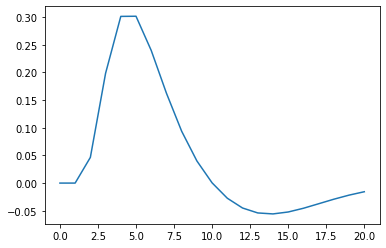

In [17]:
plt.plot(HRF)

In [18]:
n   = len(parametric_stimulus_data['WPM_0050'])
data_wpm_0050 = np.convolve(parametric_stimulus_data['WPM_0050'],HRF,'full')[:n]
data_wpm_0350 = np.convolve(parametric_stimulus_data['WPM_0350'],HRF,'full')[:n]
data_wpm_0650 = np.convolve(parametric_stimulus_data['WPM_0650'],HRF,'full')[:n]
data_wpm_0950 = np.convolve(parametric_stimulus_data['WPM_0950'],HRF,'full')[:n]
data_wpm_1250 = np.convolve(parametric_stimulus_data['WPM_1250'],HRF,'full')[:n]

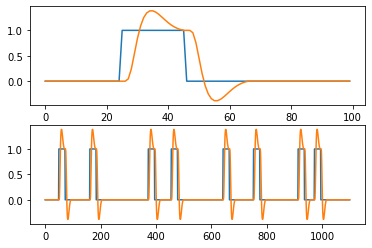

In [19]:
# plot the new EVs:
fig, a = plt.subplots(2, 1)
a[0].plot(parametric_stimulus_data['WPM_0050'][:100])
a[0].plot(data_wpm_0050[:100])

a[1].plot(parametric_stimulus_data['WPM_0350'])
a[1].plot(data_wpm_0350)

## Design Matrix

In [20]:
data_wpm = [data_wpm_0050, data_wpm_0350, data_wpm_0650, data_wpm_0950, data_wpm_1250]
mean_subtracted_data = [dt - np.mean(dt) for dt in data_wpm]
design_matrix = np.asarray(mean_subtracted_data +[np.ones_like(mean_subtracted_data[0])]).T

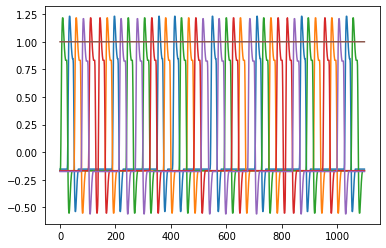

In [21]:
plt.plot(design_matrix)

## HRF Experiments

In [22]:
import numpy as np
frame_times = np.linspace(0, 30, 61)
onset, amplitude, duration = 0., 1., 1.
exp_condition = np.array((onset, duration, amplitude)).reshape(3, 1)

In [23]:
stim = np.zeros_like(frame_times)
stim[(frame_times > onset) * (frame_times <= onset + duration)] = amplitude



In [24]:
hrf_models = [None, 'glover + derivative', 'glover + derivative + dispersion']

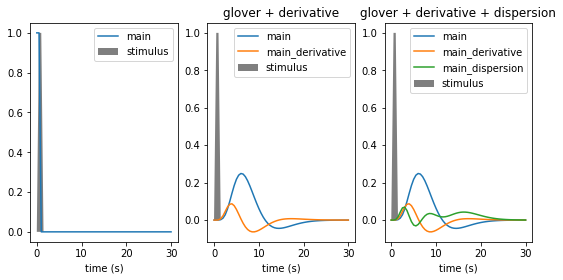

In [25]:
from nilearn.glm.first_level import compute_regressor
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(9, 4))
for i, hrf_model in enumerate(hrf_models):
    # obtain the signal of interest by convolution
    signal, name = compute_regressor(
        exp_condition, hrf_model, frame_times, con_id='main',
        oversampling=16)

    # plot this
    plt.subplot(1, 3, i + 1)
    plt.fill(frame_times, stim, 'k', alpha=.5, label='stimulus')
    for j in range(signal.shape[1]):
        plt.plot(frame_times, signal.T[j], label=name[j])
    plt.xlabel('time (s)')
    plt.legend(loc=1)
    plt.title(hrf_model)

# adjust the plot
plt.subplots_adjust(bottom=.12)
plt.show()

## continue GLM

In [26]:
from fsl_experiment_suite.glm import glm

In [27]:
mask_glm = np.ones_like(fmri_without_background[0])>0
beta, t = glm(Y=fmri_without_background, X=design_matrix, mask = mask_glm)
t_fmri = masking.unmask(t, background_mask)
beta_fmri = masking.unmask(beta, background_mask)

/home/anukoolpurohit/Documents/Workspace/Nueromatch/FSLexperiments/fsl_experiment_suite/glm.py:41: RuntimeWarning: invalid value encountered in true_divide
  tstat[:,mask] = cope[:,mask] / np.sqrt(varcope[:,mask])


### Alternate GLM

In [28]:
# from scipy import stats
# from sklearn.linear_model import LinearRegression
# model = LinearRegression()
# model = model.fit(design_matrix, fmri_without_background)
# model.coef_.shape
# design_matrix.shape

# tstat   = np.zeros_like(model.coef_)
# r = fmri_without_background - (design_matrix@(model.coef_.T))
# dof  = design_matrix.shape[0] - np.linalg.matrix_rank(design_matrix)
# sig2 = np.sum(r**2,axis=0)/dof
# varcope = np.outer(np.diag(np.linalg.inv(design_matrix.T@design_matrix)),sig2)
# tstat = model.coef_.T / np.sqrt(varcope)

# tstat.shape

# t_fmri = masking.unmask(tstat, background_mask)

## Plot T-scores

/home/anukoolpurohit/anaconda3/envs/FSL/lib/python3.9/site-packages/nilearn/_utils/niimg.py:61: UserWarning: Non-finite values detected. These values will be replaced with zeros.
  warn(


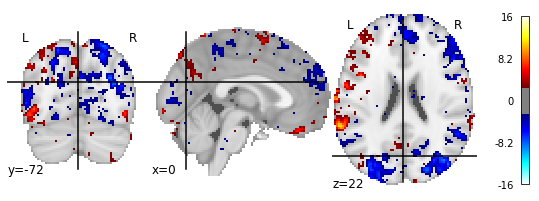

In [29]:
plot_stat_map(image.index_img(t_fmri, 0), threshold=2.5)


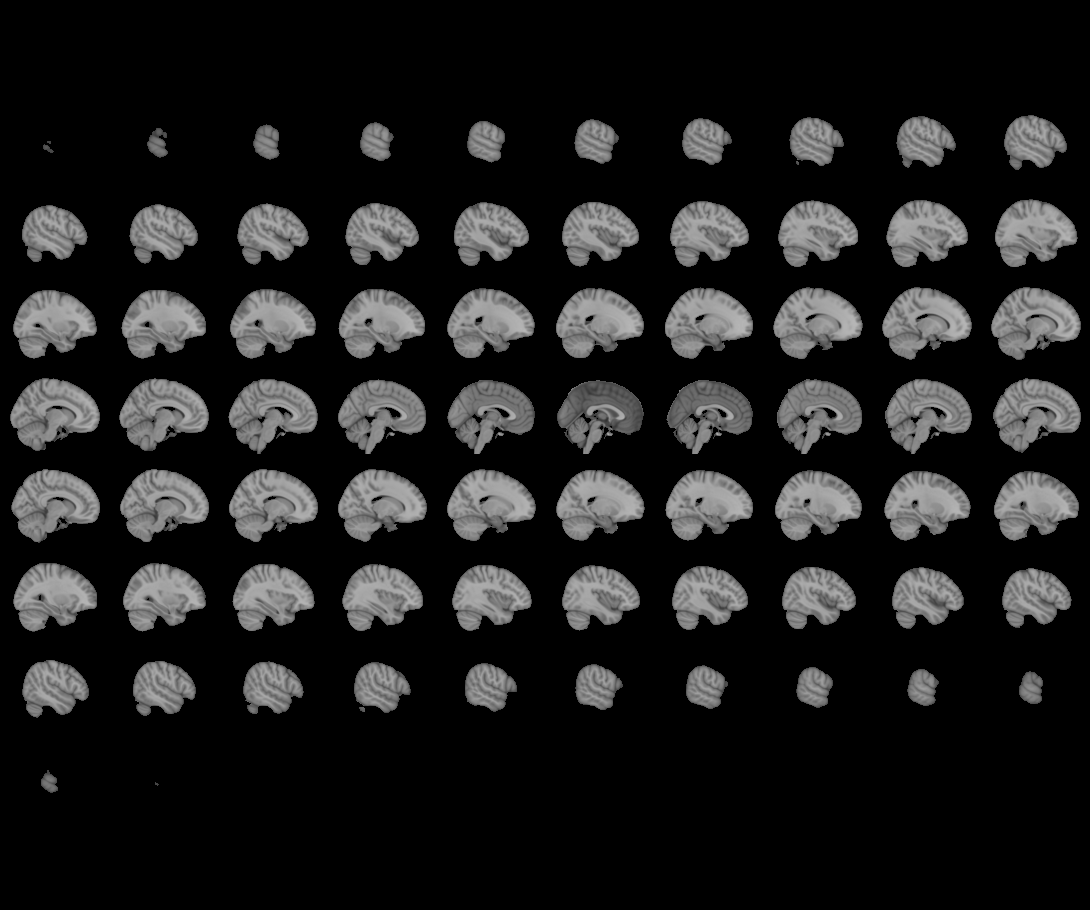
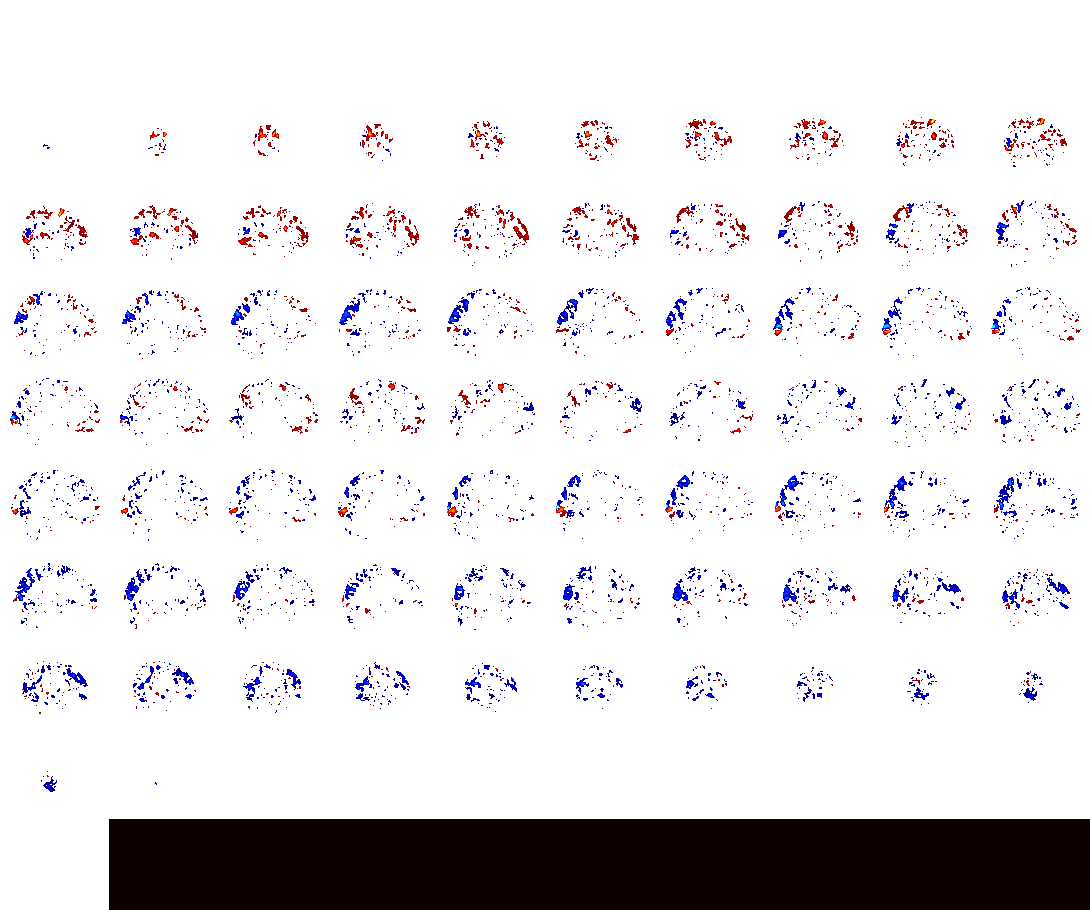

In [30]:
# 50 WPM
plotting.view_img(image.index_img(t_fmri, 0), threshold=2.5)

In [31]:
print(list(parametric_stimulus_data.keys()))

['WPM_0050', 'WPM_0350', 'WPM_0650', 'WPM_0950', 'WPM_1250']


/home/anukoolpurohit/anaconda3/envs/FSL/lib/python3.9/site-packages/nilearn/_utils/niimg.py:61: UserWarning: Non-finite values detected. These values will be replaced with zeros.
  warn(



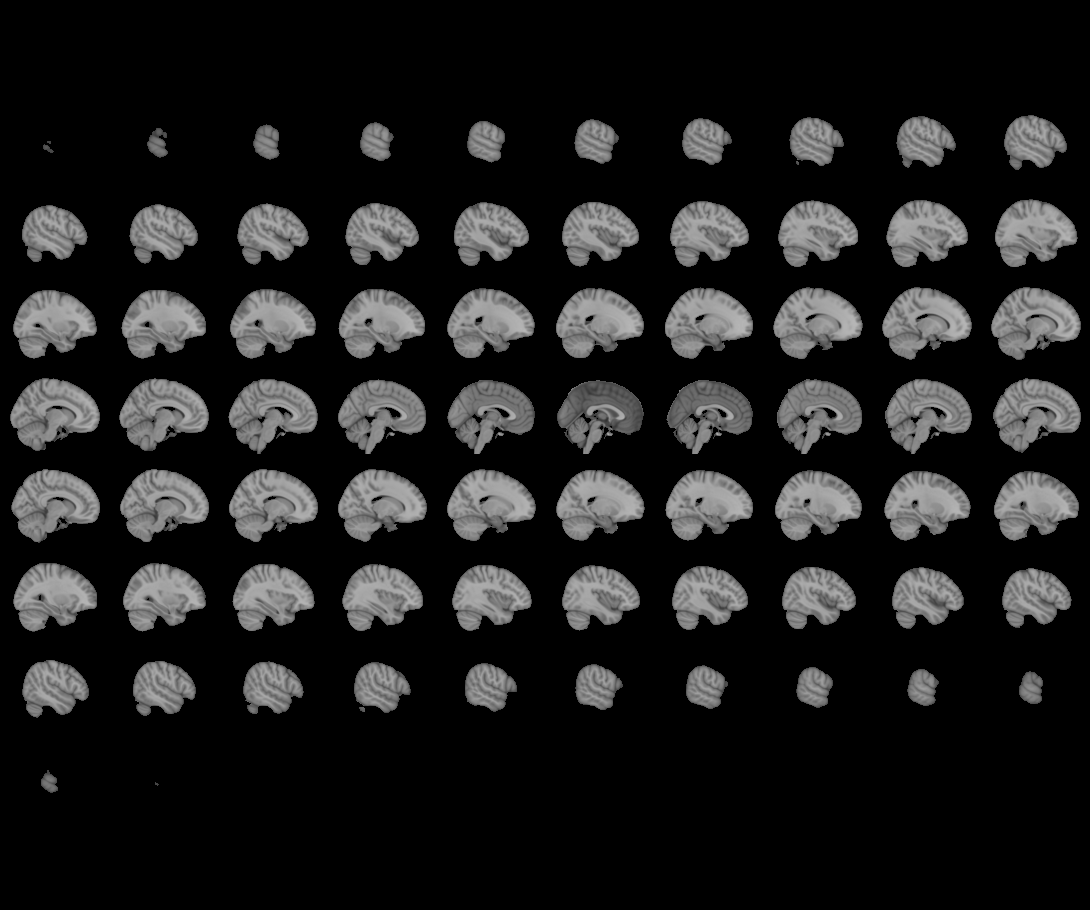
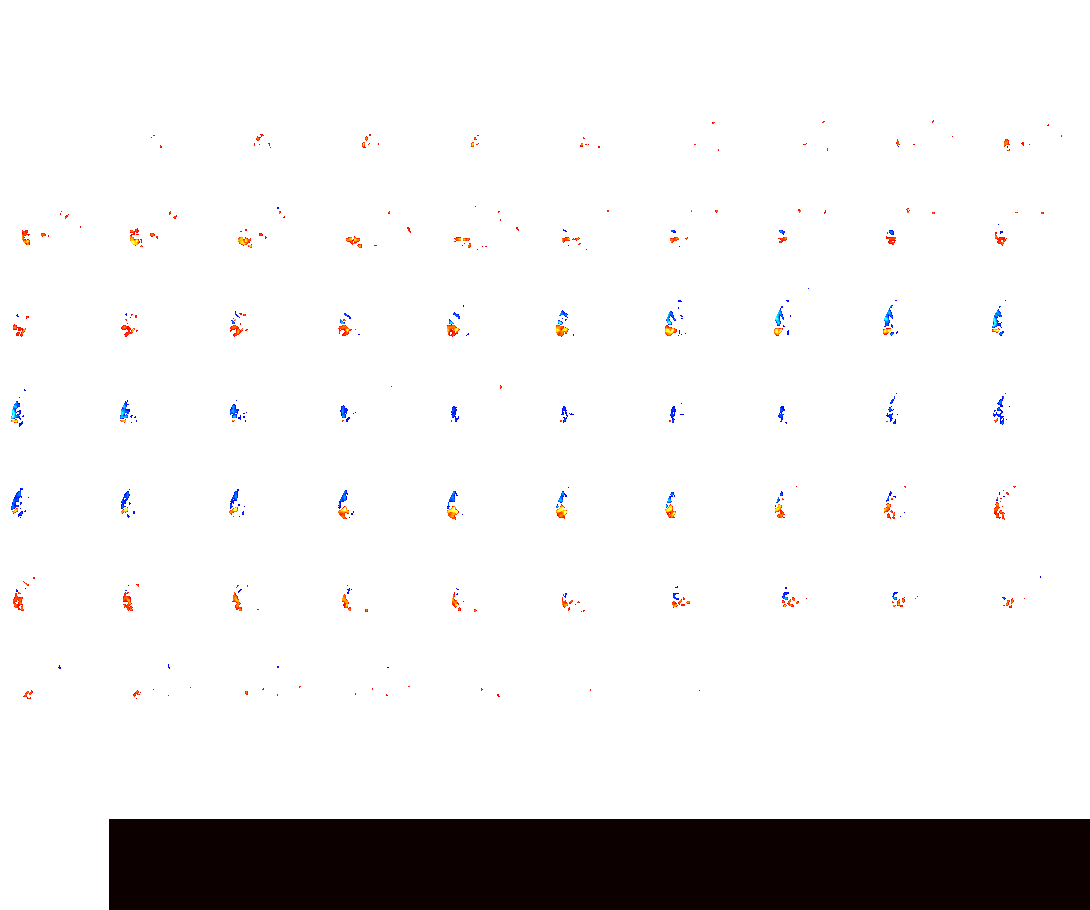

In [32]:
# 650 WP<
plotting.view_img(image.index_img(t_fmri, 2), threshold=10)

In [33]:
# nilearn.image.index_img(fmri_img, [1:25]).shape

/home/anukoolpurohit/anaconda3/envs/FSL/lib/python3.9/site-packages/nilearn/_utils/niimg.py:61: UserWarning: Non-finite values detected. These values will be replaced with zeros.
  warn(



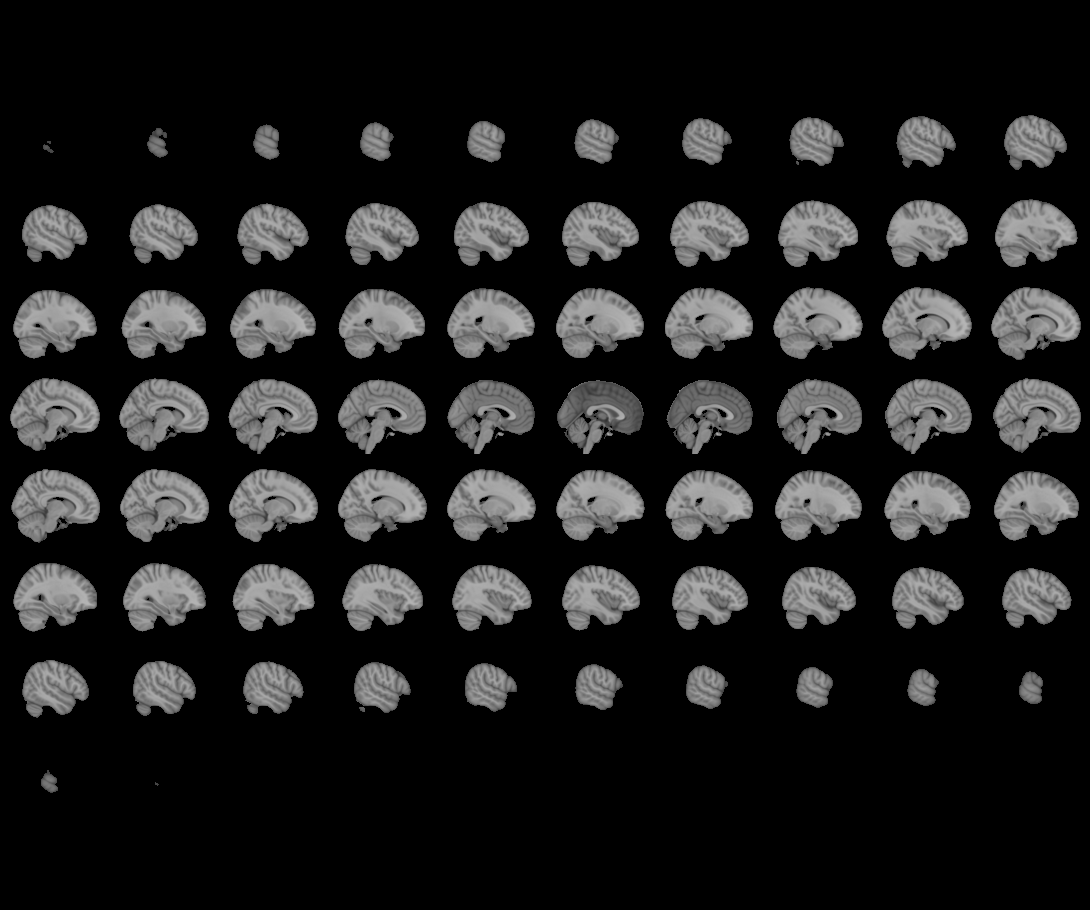
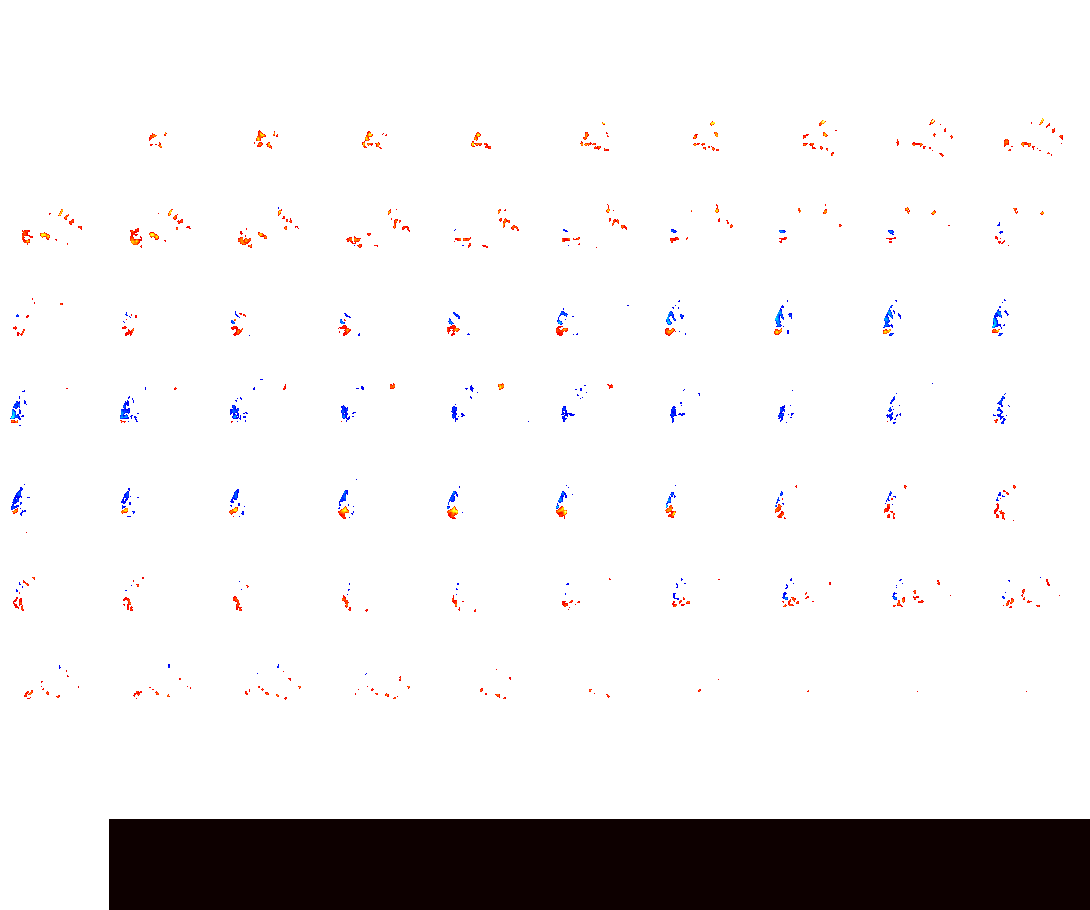

In [34]:
plotting.view_img(image.index_img(t_fmri, 4), threshold=10)

# Exploring Harvard-Oxford Atlas

In [35]:
from nilearn.datasets import fetch_atlas_harvard_oxford

In [36]:
atlas = fetch_atlas_harvard_oxford("cort-prob-2mm")

In [37]:
for i, label in enumerate(atlas.labels):
    print(f"Label {i}: {label}")

Label 0: Background
Label 1: Frontal Pole
Label 2: Insular Cortex
Label 3: Superior Frontal Gyrus
Label 4: Middle Frontal Gyrus
Label 5: Inferior Frontal Gyrus, pars triangularis
Label 6: Inferior Frontal Gyrus, pars opercularis
Label 7: Precentral Gyrus
Label 8: Temporal Pole
Label 9: Superior Temporal Gyrus, anterior division
Label 10: Superior Temporal Gyrus, posterior division
Label 11: Middle Temporal Gyrus, anterior division
Label 12: Middle Temporal Gyrus, posterior division
Label 13: Middle Temporal Gyrus, temporooccipital part
Label 14: Inferior Temporal Gyrus, anterior division
Label 15: Inferior Temporal Gyrus, posterior division
Label 16: Inferior Temporal Gyrus, temporooccipital part
Label 17: Postcentral Gyrus
Label 18: Superior Parietal Lobule
Label 19: Supramarginal Gyrus, anterior division
Label 20: Supramarginal Gyrus, posterior division
Label 21: Angular Gyrus
Label 22: Lateral Occipital Cortex, superior division
Label 23: Lateral Occipital Cortex, inferior division


In [38]:
atlas_map = nib.load(atlas.maps)

In [39]:
atlas_map.shape

(91, 109, 91, 48)

/home/anukoolpurohit/anaconda3/envs/FSL/lib/python3.9/site-packages/numpy/ma/core.py:2825: UserWarning: Warning: converting a masked element to nan.
  _data = np.array(data, dtype=dtype, copy=copy,


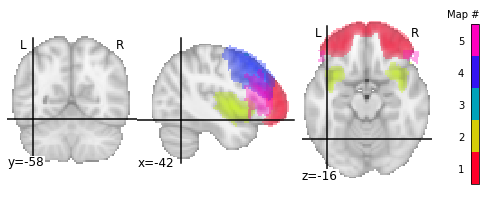

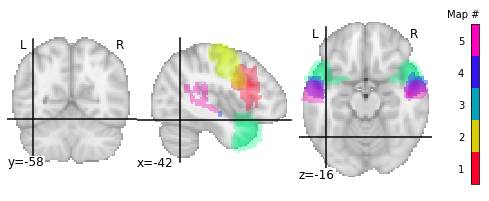

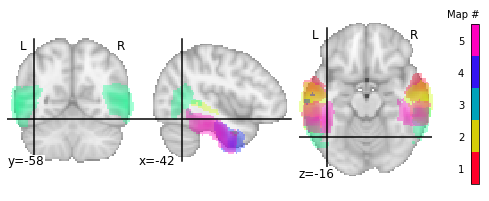

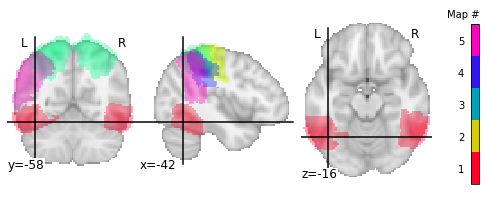

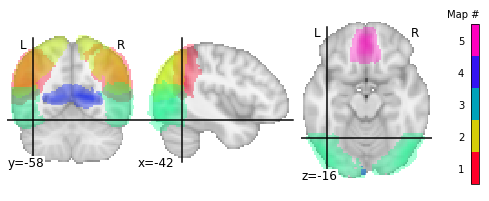

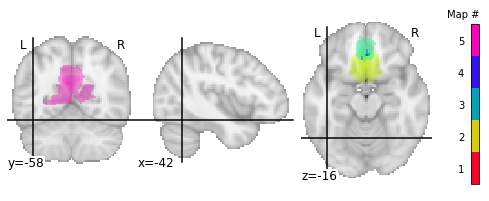

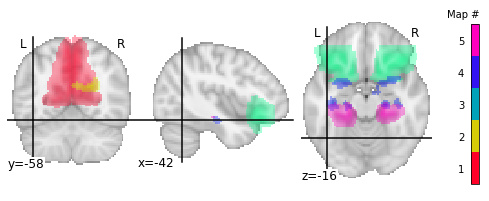

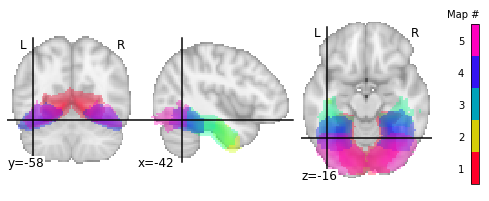

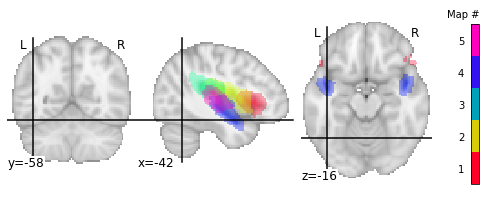

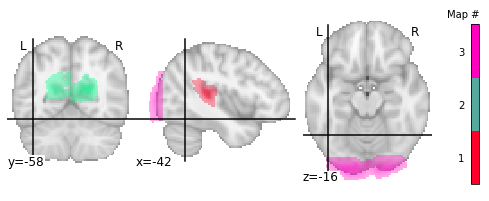

In [157]:
for i in range(0, 48, 5):
    plot_prob_atlas(image.index_img(atlas_map, slice(i, i+5)), cut_coords=(-42, -58, -16), colorbar=True)

/home/anukoolpurohit/anaconda3/envs/FSL/lib/python3.9/site-packages/nilearn/plotting/html_document.py:56: UserWarning: It seems you have created more than 10 nilearn views. As each view uses dozens of megabytes of RAM, you might want to delete some of them.
  warnings.warn('It seems you have created more than {} '



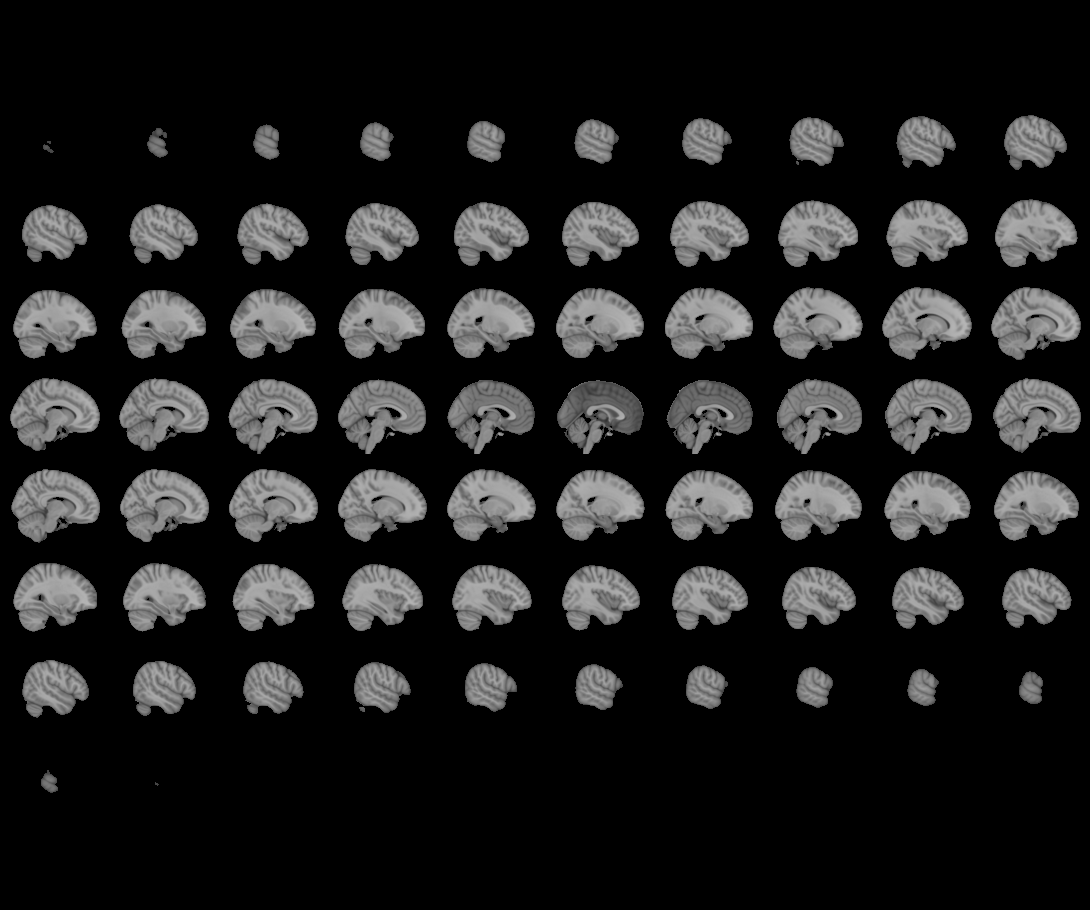
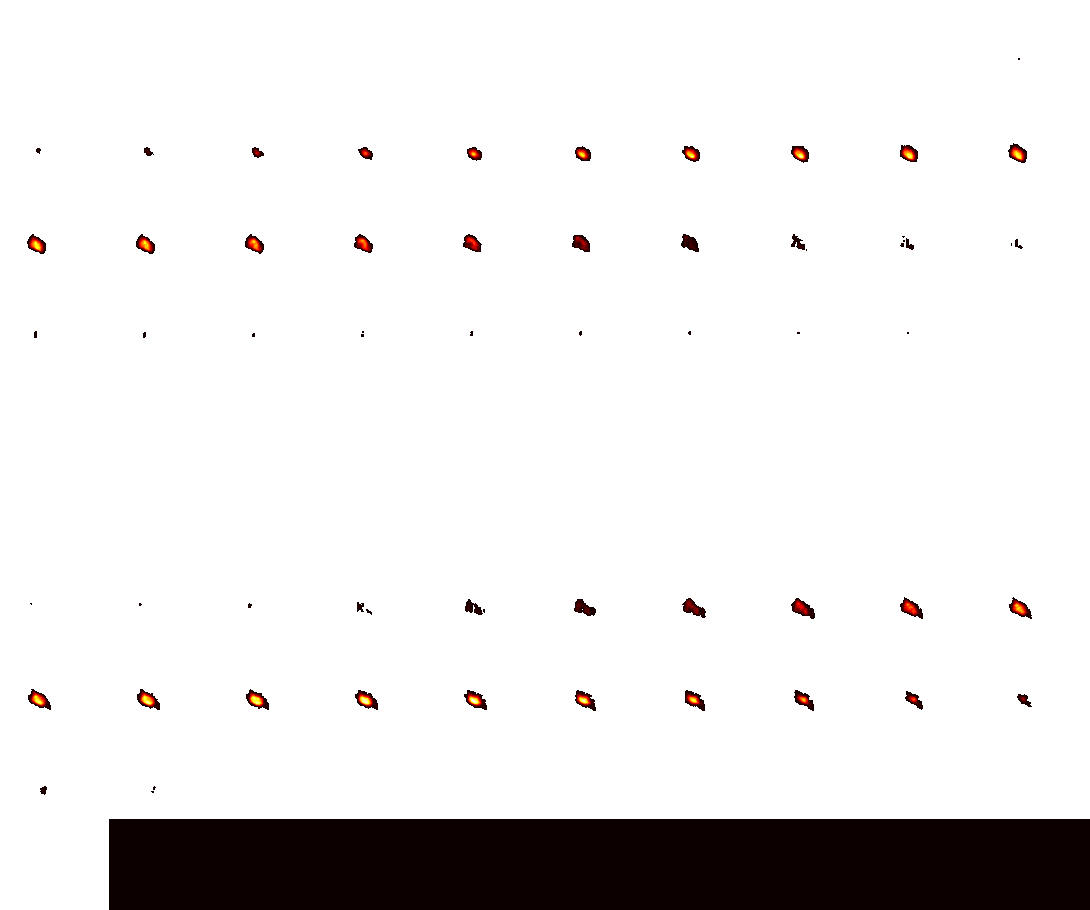

In [173]:
plotting.view_img(image.index_img(atlas_map, 15), cut_coords=(-54, -62, -6))

# Playing with T- stats

In [41]:
mask_glm.shape

(229007,)

In [42]:
dummy = np.array([.5, 1 , 5, 1, .5])
dummy = dummy[None, :]
print(t[:5].shape, dummy.shape)

(5, 229007) (1, 5)


In [43]:
beta_dummy, dummy_t = glm(t[:5], dummy.T,  mask=mask_glm)

In [44]:
dummy_t.shape

(1, 229007)

/home/anukoolpurohit/anaconda3/envs/FSL/lib/python3.9/site-packages/nilearn/_utils/niimg.py:61: UserWarning: Non-finite values detected. These values will be replaced with zeros.
  warn(



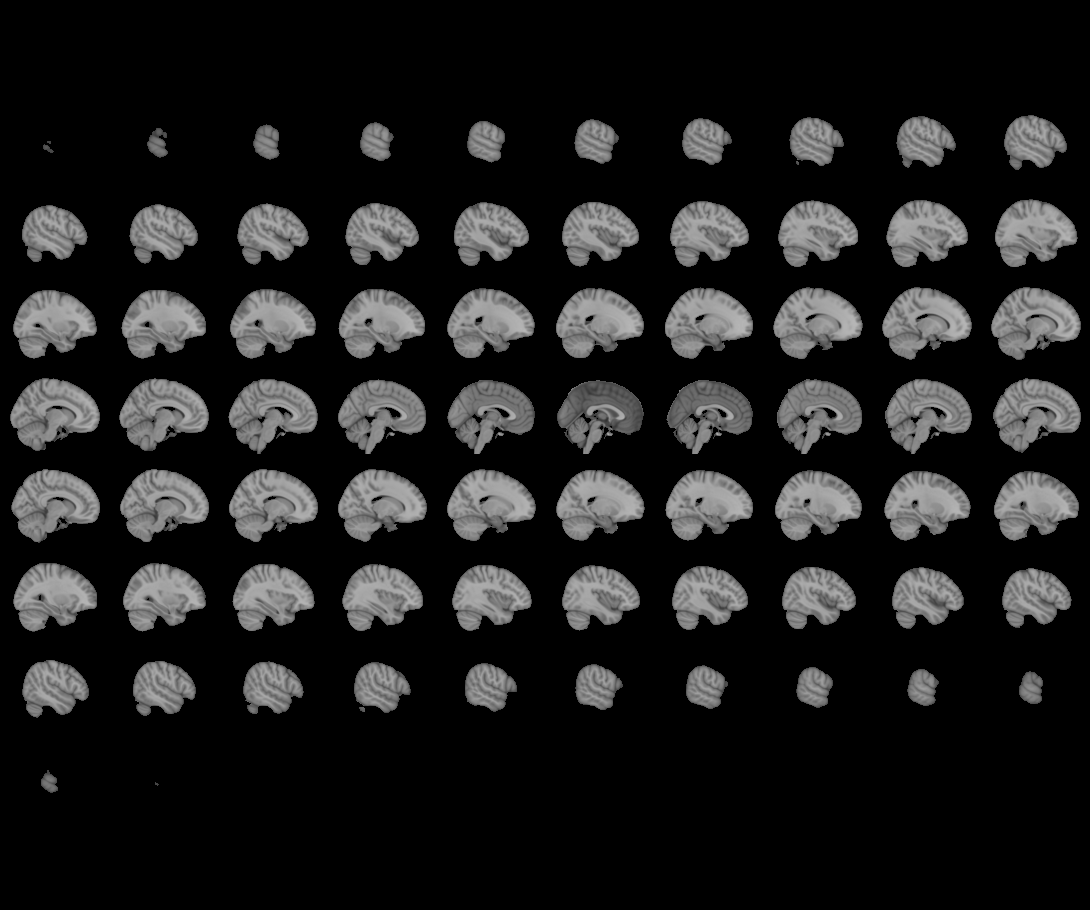
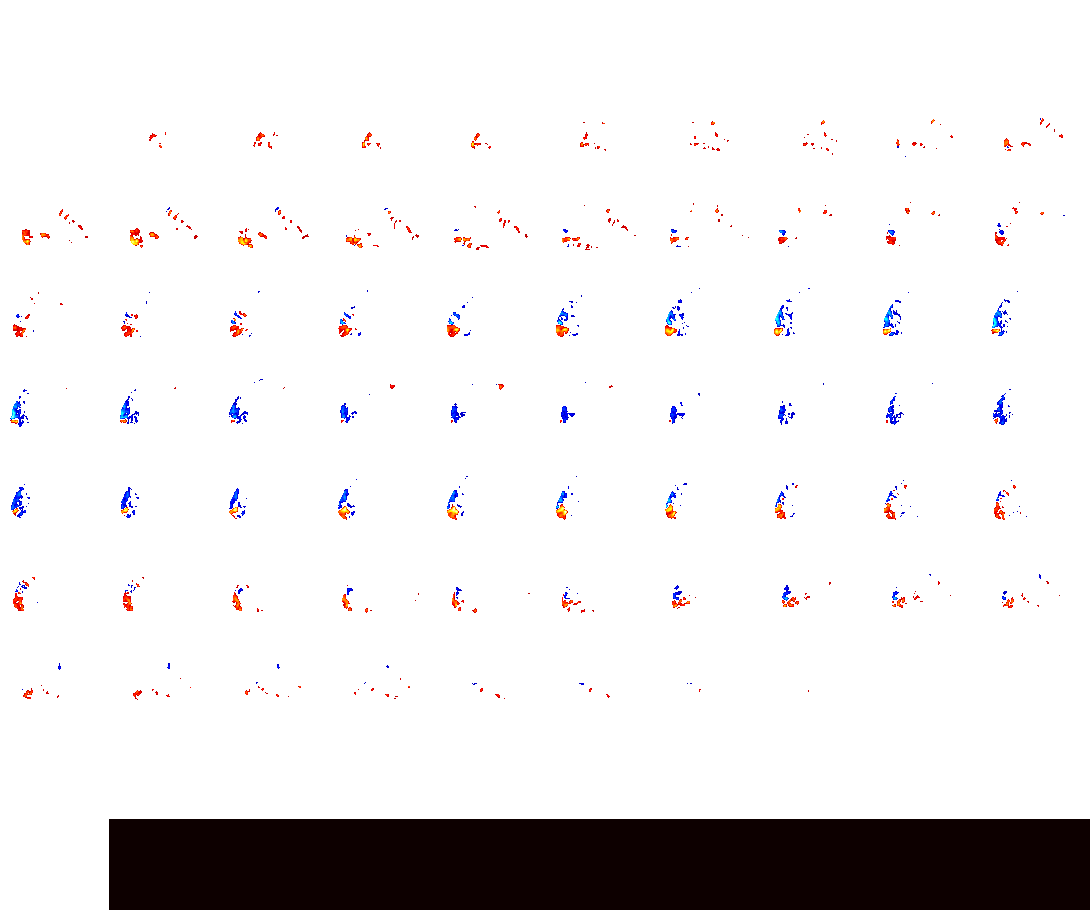

In [45]:
dummy_t = (dummy @ t[:5,:])
(dummy_t[None, :]).shape
dummy_t_fmri = masking.unmask(beta_dummy, background_mask)
plotting.view_img(dummy_t_fmri, threshold=2.0)

# Plotting Regions in the atlas

In [46]:
from nilearn.input_data import NiftiMapsMasker

In [47]:
masker = NiftiMapsMasker(maps_img=atlas_map, standardize=False, memory="nilearn_cache", verbose=5)

In [48]:
time_series = masker.fit_transform(image.index_img(t_fmri, slice(0, 5)))

[NiftiMapsMasker.fit_transform] loading regions from Nifti1Image('/home/anukoolpurohit/nilearn_data/fsl/data/atlases/HarvardOxford/HarvardOxford-cort-prob-2mm.nii.gz')


/home/anukoolpurohit/anaconda3/envs/FSL/lib/python3.9/site-packages/nilearn/image/image.py:1054: FutureWarning: The parameter "sessions" will be removed in 0.9.0 release of Nilearn. Please use the parameter "runs" instead.
  data = signal.clean(
/home/anukoolpurohit/anaconda3/envs/FSL/lib/python3.9/site-packages/nilearn/_utils/cache_mixin.py:303: UserWarning: memory_level is currently set to 0 but a Memory object has been provided. Setting memory_level to 1.
  warnings.warn("memory_level is currently set to 0 but "


[Memory]0.5s, 0.0min    : Loading filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


In [49]:
time_series.shape

(5, 48)

In [50]:
list(time_series[:, 23])

[-0.02366995648866711,
 -0.09761970528194727,
 -0.10110976649140069,
 -0.08579950953190742,
 -0.10580501760764663]

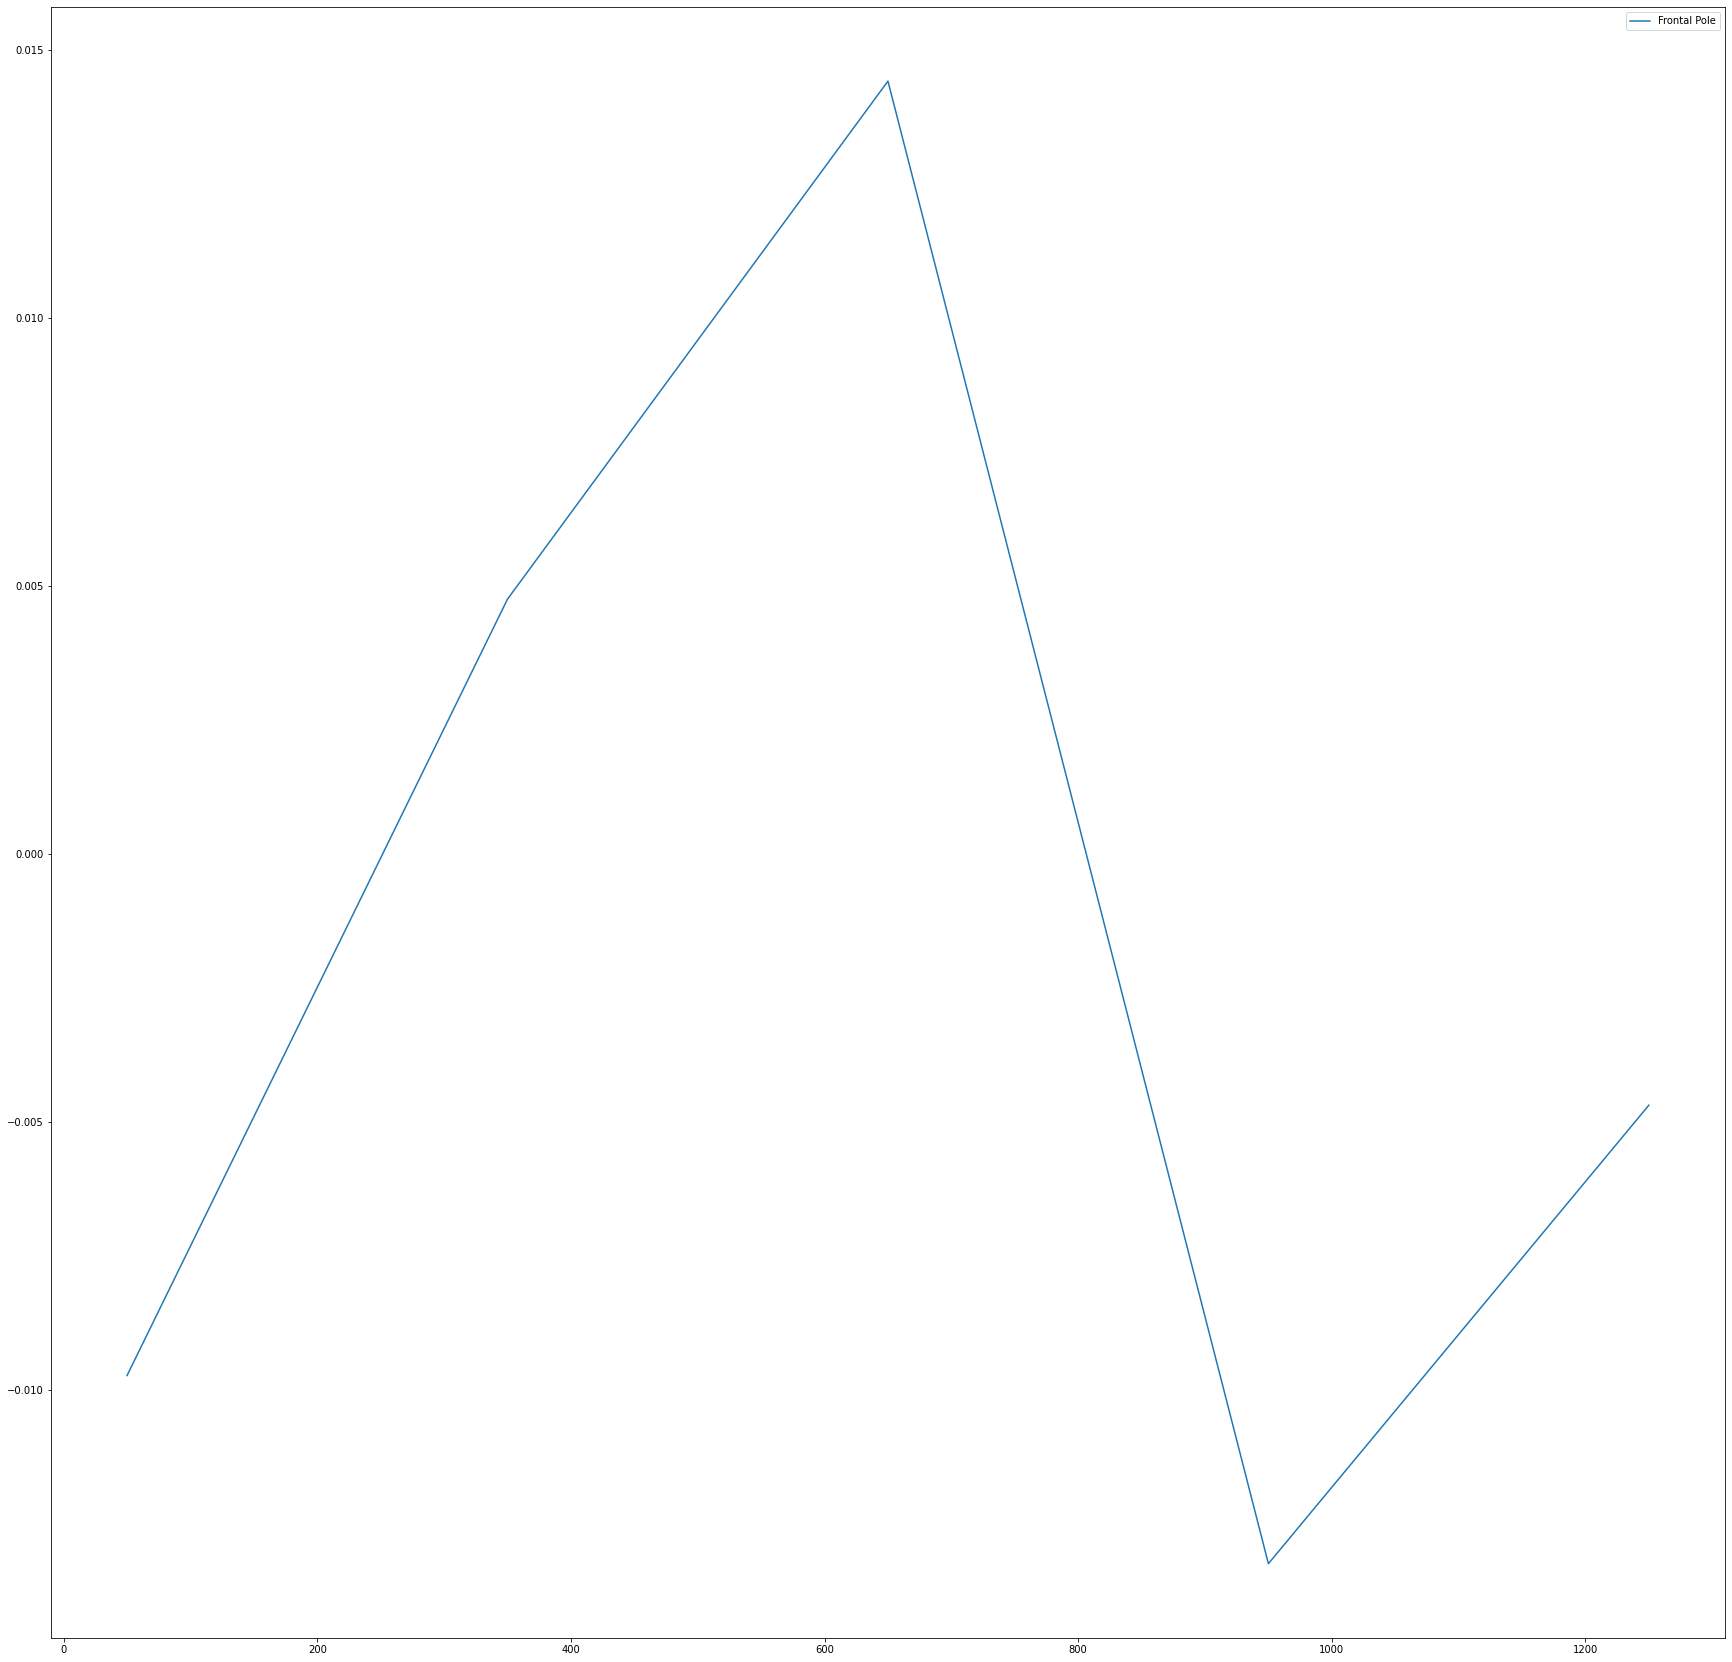

In [169]:
fig = plt.figure(figsize=(30, 30))
plt.plot([50, 350, 650, 950, 1250], time_series[:, 15])
plt.legend(atlas.labels[1:])

# Region Extraction

In [132]:
for i, label in enumerate(atlas.labels):
    print(f"Label {i-1}: {label}")

Label -1: Background
Label 0: Frontal Pole
Label 1: Insular Cortex
Label 2: Superior Frontal Gyrus
Label 3: Middle Frontal Gyrus
Label 4: Inferior Frontal Gyrus, pars triangularis
Label 5: Inferior Frontal Gyrus, pars opercularis
Label 6: Precentral Gyrus
Label 7: Temporal Pole
Label 8: Superior Temporal Gyrus, anterior division
Label 9: Superior Temporal Gyrus, posterior division
Label 10: Middle Temporal Gyrus, anterior division
Label 11: Middle Temporal Gyrus, posterior division
Label 12: Middle Temporal Gyrus, temporooccipital part
Label 13: Inferior Temporal Gyrus, anterior division
Label 14: Inferior Temporal Gyrus, posterior division
Label 15: Inferior Temporal Gyrus, temporooccipital part
Label 16: Postcentral Gyrus
Label 17: Superior Parietal Lobule
Label 18: Supramarginal Gyrus, anterior division
Label 19: Supramarginal Gyrus, posterior division
Label 20: Angular Gyrus
Label 21: Lateral Occipital Cortex, superior division
Label 22: Lateral Occipital Cortex, inferior division


In [53]:
atlas_map.shape

(91, 109, 91, 48)

In [184]:
ofg_map = image.index_img(atlas_map, 15)
# ofg_map = dummy_t_fmri
map_data = ofg_map.dataobj
map_data = (map_data > 2.0)
# mask_22 = map_data

/home/anukoolpurohit/anaconda3/envs/FSL/lib/python3.9/site-packages/nilearn/plotting/html_document.py:56: UserWarning: It seems you have created more than 10 nilearn views. As each view uses dozens of megabytes of RAM, you might want to delete some of them.
  warnings.warn('It seems you have created more than {} '



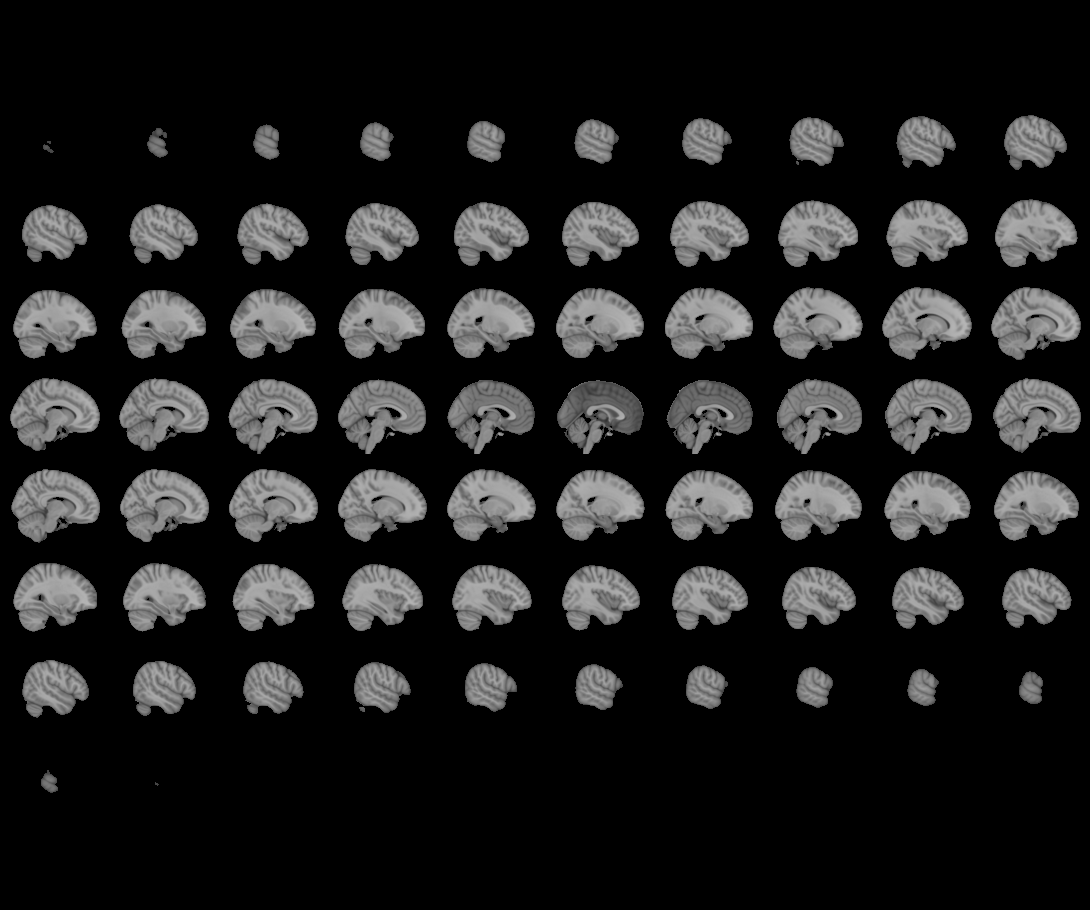
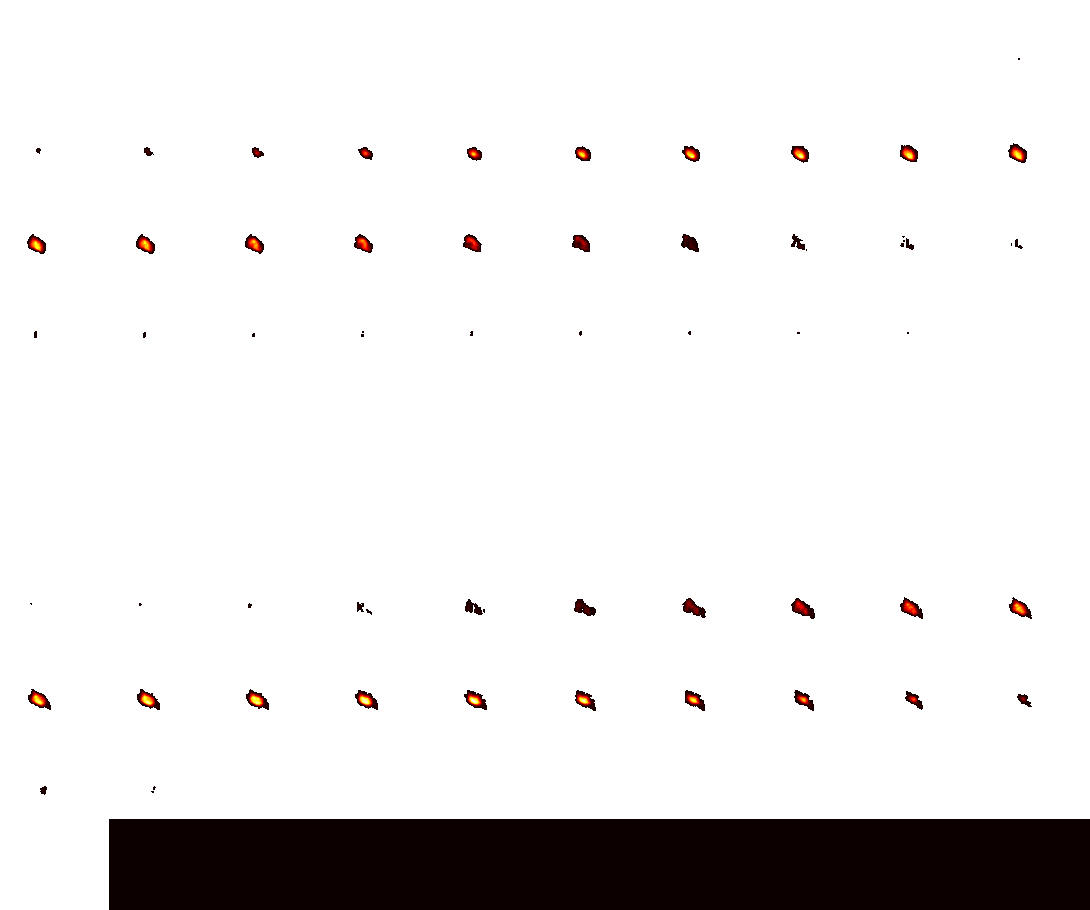

In [186]:
plotting.view_img(ofg_map, cut_coords=(-54, -62, -6))

(91, 109, 91, 1)

In [191]:
map_data = mask_22[:,:,:,0] * map_data

In [192]:
ofg_mask = image.new_img_like(fmri_img, map_data)

In [193]:
ofg_mask.shape

(91, 109, 91)

/home/anukoolpurohit/anaconda3/envs/FSL/lib/python3.9/site-packages/nilearn/image/resampling.py:527: UserWarning: Casting data from int32 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/home/anukoolpurohit/anaconda3/envs/FSL/lib/python3.9/site-packages/nilearn/image/resampling.py:273: UserWarning: Resampling binary images with continuous or linear interpolation. This might lead to unexpected results. You might consider using nearest interpolation instead.
  warnings.warn("Resampling binary images with continuous or "
/home/anukoolpurohit/anaconda3/envs/FSL/lib/python3.9/site-packages/nilearn/plotting/html_document.py:56: UserWarning: It seems you have created more than 10 nilearn views. As each view uses dozens of megabytes of RAM, you might want to delete some of them.
  warnings.warn('It seems you have created more than {} '



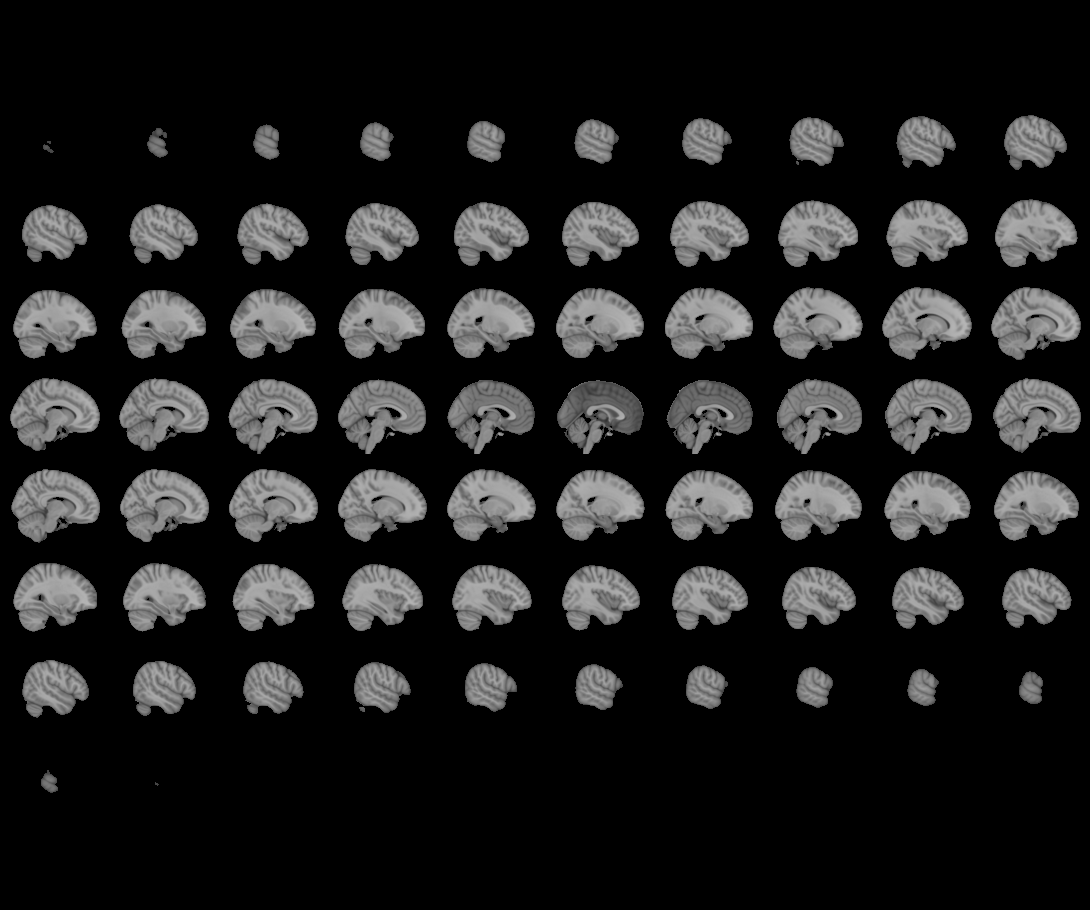
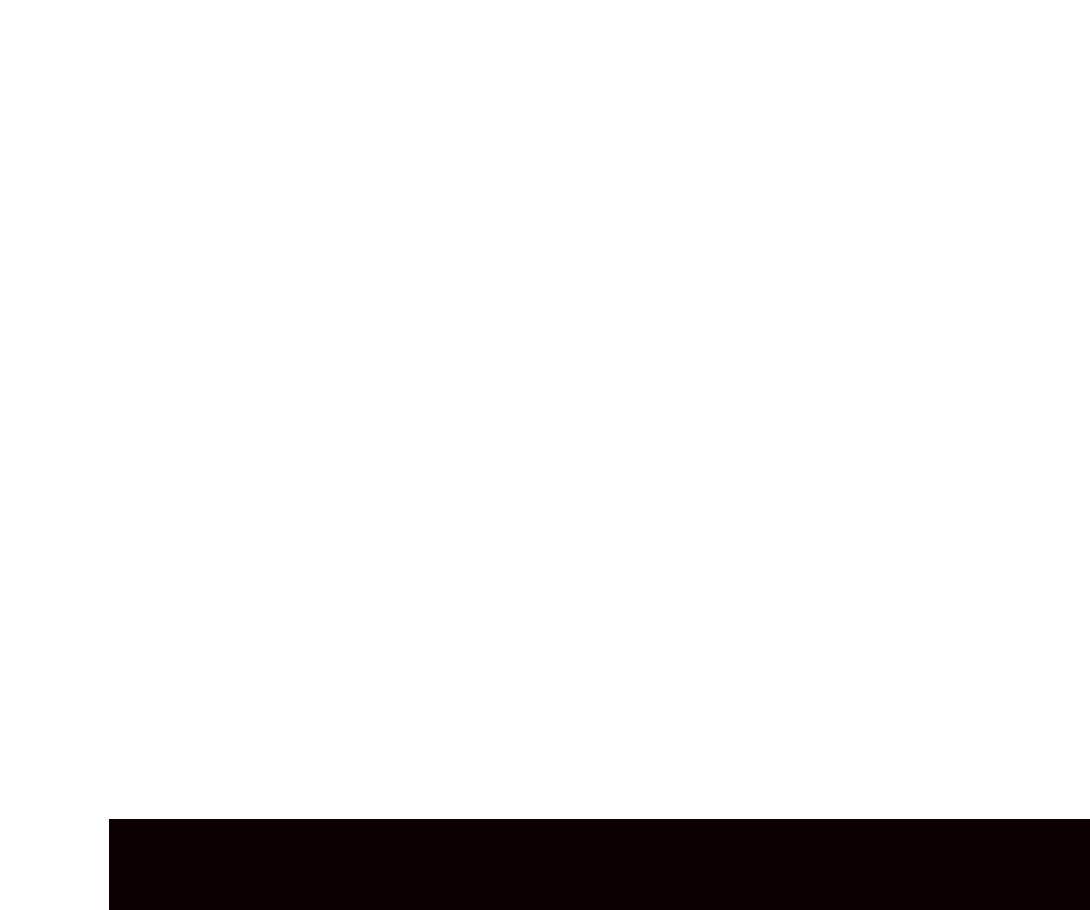

In [194]:
plotting.view_img(ofg_mask)

In [61]:
masked_ofg = masking.apply_mask(fmri_img, ofg_mask)

In [62]:
masked_ofg.shape

(1100, 17294)

# Polynomial <s>Regression</s>  Interpolation Experiments

In [82]:
from tqdm import tqdm
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Lasso

In [64]:
test1 = np.linspace(-5, 5)
test2 = test1 ** 2 + np.random.normal(0, 1, size=test1.shape)

## setup

In [93]:
poly_coefs = np.polyfit

array([ 1.03008409,  0.05046068, -0.42058047])

In [ ]:
poly_coef = 

## plotting

In [66]:
polyreg = make_pipeline(PolynomialFeatures(degree), Lasso())

In [67]:
poly_coefs = np.polyfit(test1, test2, 2)

In [68]:
poly_res = poly_coefs  @ np.array([test1**2, test1, np.ones_like(test1)])

In [69]:
poly_res.shape

(50,)

In [86]:
words_per_min = np.array([50, 350, 650, 950, 1250])

polynomial_fmri = []
for i in tqdm(range(t_fmri_wpms.shape[1]), leave=False):
    polynomial_fmri.append(np.polyfit(words_per_min, t_fmri_wpms[:, i], degree))
polynomial_fmri = np.array(polynomial_fmri)
polynomial_fmri = polynomial_fmri.T
print(polynomial_fmri.shape)

(3, 229007)


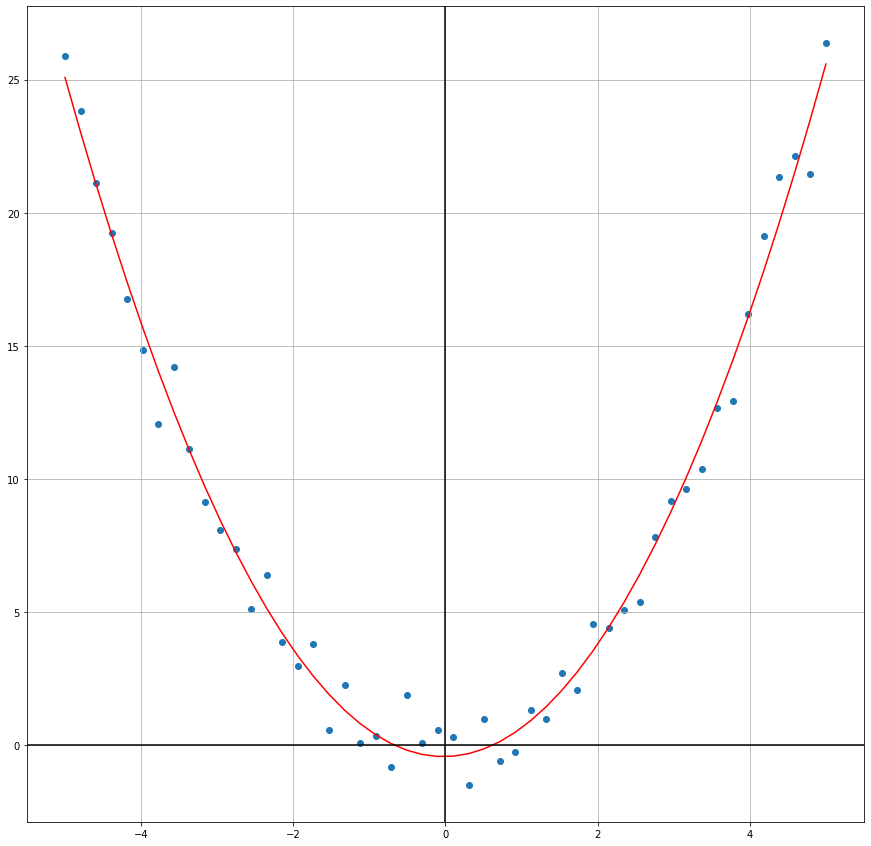

In [70]:
plt.figure(1, figsize=(15, 15))
plt.scatter(test1, test2)
plt.plot(test1, poly_res, 'r')
beta
plt.axvline(x=0, c="black")
plt.axhline(y=0, c="black")
plt.grid()
plt.show()

In [101]:
# [t[:, i].shape for i in range(t.shape[1])]

## Polynomial interpolation

In [107]:
np.log10(words_per_min,)

array([1.69897   , 2.54406804, 2.81291336, 2.97772361, 3.09691001])

In [109]:
degree = 2

words_per_min = np.array([50, 350, 650, 950, 1250])


polynomial_fmri = []
for i in tqdm(range(t_fmri_wpms.shape[1]), leave=False):
    poly_coefs = np.polyfit(np.log10(words_per_min), t_fmri_wpms[:, i], degree)
    if abs(poly_coefs[0]) > abs(poly_coefs[1]):
        print(poly_coefs)
    polynomial_fmri.append(poly_coefs)
polynomial_fmri = np.array(polynomial_fmri)
polynomial_fmri = polynomial_fmri.T
print(polynomial_fmri.shape)

  1%|▎                                  | 1888/229007 [00:00<00:23, 9515.06it/s]

[ 0.41828002  0.0385487  -1.5766839 ]
[ 0.61314816  0.14325526 -4.65911732]
[ 0.18428783 -0.04229512 -4.51144344]
[ 0.25059796  0.21801472 -4.42249294]
[ 0.19169719  0.18710165 -0.59424268]
[ 0.18768289  0.16224525 -3.46037546]
[ 1.06570354 -0.85349774 -2.10210021]
[ 0.30036064  0.19558151 -2.13227602]
[ 0.46817779 -0.35886338 -4.07211397]
[ 0.68168812  0.07172489 -3.61846072]
[ 0.36267736 -0.33835288 -2.96848603]
[-0.50512662  0.02790038  0.20815557]
[-0.30991748  0.30535014 -0.91179423]
[-0.52721927  0.39091533 -0.30826651]
[ 0.50497877  0.2049663  -5.50279986]
[-0.38546925  0.28894366  0.80589502]
[-0.57182334 -0.17403274  4.00906428]
[ 0.23263834 -0.08876296 -5.12783388]
[-0.19613272  0.10463538  0.67930687]
[ 0.13580423 -0.11201104 -0.4003845 ]
[ 0.28206235  0.12413523 -1.42395097]
[ 0.5910262  -0.42503489 -3.40125919]
[0.30740301 0.01823128 1.03623082]
[ 0.49882321 -0.13775058 -3.64940565]
[-0.67330361  0.31788161  3.58510529]
[ 0.91795197 -0.73019776 -7.27401567]
[-0.52901641 -0

  2%|▌                                  | 3856/229007 [00:00<00:23, 9663.91it/s]


[-0.7251215  -0.26430048  4.19584954]
[-1.04402902  0.99103206  1.91716684]
[ 0.37952382  0.11875559 -3.76714294]
[ 0.22953684 -0.04211564 -2.58706793]
[-0.25779601  0.17752631 -1.79976002]
[ 0.21705789  0.16375333 -1.24045798]
[ 0.16658602 -0.09831626 -0.88428346]
[-0.24371755  0.0857963  -0.05702579]
[-0.28438542 -0.10233036 -1.68103393]
[-0.78986488  0.48766553  0.77696279]
[-4.62795863e-01  8.44902353e-04  1.47312054e+00]
[-0.64383589  0.56239226  2.26015294]
[-0.28563662  0.15612695  1.40208677]
[-0.29083383 -0.08369189  1.54503881]
[-0.10927038  0.03739374 -0.49921303]
[0.21484529 0.02254947 0.1126707 ]
[ 0.1914802  -0.14454423 -3.34232898]
[ 0.16283163  0.1391517  -3.24624828]
[ 0.29577663 -0.2302519  -0.70586096]
[-0.67890322  0.46418619  1.98824836]
[-1.04887731  1.04460309  3.35346492]
[-0.33872604 -0.01209253  1.17269893]
[ 0.23942913 -0.06460603 -1.43518921]
[ 0.17435114  0.15140714 -6.43322401]
[-0.0462671  -0.01369759 -2.04257154]
[-0.5704318   0.35153818  1.27656995]
[ 

  3%|▉                                  | 5899/229007 [00:00<00:22, 9932.52it/s]


[-0.29688758 -0.2255569   1.23397801]
[-0.07193362  0.04562404  1.23682337]
[-0.4018177  -0.33877119  1.29297847]
[-0.14789206  0.09139695  0.7773043 ]
[-0.09404267 -0.0911651  -0.16682889]
[-0.23730707 -0.00840431  0.32609023]
[-0.8341126  -0.59836127  3.33497482]
[-0.38359416 -0.17746606  0.71432867]
[ 1.3095613  -0.69665529 -4.49680701]
[ 0.8375022   0.49980348 -6.66598949]
[ 0.85763336  0.0362454  -4.67045721]
[-0.18821534 -0.05199591 -1.87451525]
[ 0.77775772 -0.66702974 -8.56345793]
[ 0.40073061  0.00852848 -6.23790865]
[ 0.52438624 -0.2729702  -0.7747217 ]
[-0.62494857 -0.22460644  2.15472663]
[ 0.49347685 -0.38447666 -1.26674453]
[ 0.2352277   0.05321173 -1.26791915]
[-0.41454442  0.18217038  1.55656857]
[-0.05949039  0.04365596 -2.50652388]
[-0.14948743 -0.14591283 -0.43134234]
[-0.77288227  0.51484445  1.35799813]
[-0.44807107 -0.40633117  3.57507718]
[ 0.29822048 -0.14561208 -2.88416185]
[-0.15379262 -0.1529345  -0.00502554]
[-0.16131095  0.02261557 -0.32270826]
[ 0.3966413

  4%|█▎                                | 8995/229007 [00:00<00:21, 10217.69it/s]

[ 0.35362336 -0.06731725 -1.49536128]
[-0.08307804 -0.01173434  1.68663195]
[-0.25586616  0.07596849  0.9717808 ]
[-0.19518081  0.12626826  0.1668914 ]
[ 0.40783361 -0.3248264   0.52406619]
[ 0.1539875  -0.07039157 -2.95867617]
[-0.30193291  0.01486042  1.02264338]
[ 0.83433696  0.34488438 -4.09449442]
[ 0.96468615 -0.3983563  -6.33916076]
[ 0.55500986 -0.10624488 -6.02687442]
[ 0.32414507  0.05763103 -2.28572697]
[ 0.44543148 -0.16639086 -1.5117113 ]
[ 0.67916182 -0.61252516 -4.8155095 ]
[-0.59925962  0.59367225 -1.44403403]
[-0.60826966  0.60266103  0.87685518]
[ 0.33440456  0.06643279 -1.67949326]
[ 0.40942604 -0.10391975 -0.89449575]
[ 0.29064894 -0.22500322 -0.75823724]
[ 0.29689688 -0.26008461 -1.88822067]
[-0.40250589  0.33840953  2.19964266]
[ 0.29906558 -0.07375214 -2.4016512 ]
[-0.16756231 -0.02317243  1.45346864]
[-0.23714508  0.1702573  -1.57591189]
[-0.38589588  0.25485467  0.10534612]
[-0.38100971  0.03785509  1.20950877]
[ 0.37447275  0.32469963 -3.99360513]
[-0.05387501

  5%|█▌                               | 11029/229007 [00:01<00:21, 10019.89it/s]


[-0.03717986  0.02243501 -1.48406801]
[-1.06713712  0.95289669 -0.47899954]
[-0.85146534  0.48427147  0.94564841]
[-0.63411071 -0.17107044  3.26743313]
[-0.16380194 -0.00514027  2.04489837]
[0.12146355 0.01470491 0.15705149]
[ 0.37064736 -0.16907682 -2.35027312]
[-0.21875732  0.0488298   0.82047265]
[ 0.41165282  0.32906869 -2.27500474]
[-0.38923794 -0.16073162  1.91217815]
[ 0.58526796 -0.21650664 -4.39543035]
[ 0.37247282  0.21718123 -2.91032625]
[-0.13907603 -0.02429927  0.78894899]
[-0.25549093  0.17461876  0.53693823]
[ 0.25878319 -0.2379654  -0.44015926]
[ 0.79046391 -0.38253547 -3.71920649]
[ 0.57154309 -0.12627702 -6.51546004]
[ 0.69784685 -0.67521938 -3.98455224]
[ 0.64708552  0.39901183 -6.02083649]
[ 0.43172433  0.41620212 -5.95664885]
[ 0.30637752  0.05742659 -2.19339727]
[ 0.24108278  0.01086277 -2.58931557]

  6%|██                                | 13997/229007 [00:01<00:22, 9663.80it/s]


[-1.01420061  0.96970109  2.10799215]
[-0.41309561  0.16618004  0.87517151]
[-0.29168669  0.08892694  1.64583921]
[ 0.16460702  0.10623944 -2.69121653]
[-0.22145602 -0.00143087 -1.08890102]
[-0.20715035  0.09555348  4.19491749]
[ 0.19698077  0.11473318 -1.55620366]
[0.417994   0.31282125 0.25765372]
[ 0.2701245  -0.1648627  -1.77446592]
[ 0.35837369  0.08131105 -3.77608002]
[ 0.2402764  -0.23963379 -1.08825414]
[ 0.07917725 -0.02809119 -0.73092637]
[-0.10541749 -0.10502971  1.90597485]
[-0.08879072 -0.04570699 -0.08575355]
[0.05802292 0.05221584 0.09131908]
[-0.00616933 -0.00346808  0.80938982]
[ 0.33823774 -0.08655411 -1.00598603]
[-0.16788891  0.12910535  0.39455052]
[-0.21574191  0.09048692  0.31246409]
[-1.31179792  1.23459328  3.77973719]
[ 0.25546367 -0.2245131  -0.37278237]
[-0.69902375  0.27197886  4.02549854]
[ 0.13016389 -0.10000887  1.08141358]


  7%|██▌                               | 16930/229007 [00:01<00:21, 9672.74it/s]

[ 0.40369898 -0.12821568 -1.38309289]
[ 0.29417969 -0.1758812  -1.52362213]
[ 0.47454377 -0.14642052 -3.16354729]
[ 0.36834747 -0.33856992 -0.7698103 ]
[ 0.4265571   0.36954628 -4.79957027]
[ 0.48365922  0.16283475 -3.12467944]
[ 0.33275126  0.09135385 -5.54079836]
[ 0.49870935 -0.41723502 -1.93288764]
[ 0.65185382  0.31064713 -7.36140039]
[ 0.12986658 -0.01344852 -0.22225225]
[ 0.37331254  0.09218547 -2.37905081]
[-0.45769189 -0.08541523 -1.8562519 ]
[-0.35173859  0.34902268  1.00959818]
[-0.556427   -0.43807266  3.49786161]
[-0.15250997  0.12722297 -0.56613655]
[-0.35165219  0.34277581  1.65107957]
[-0.41247739  0.27142883  2.74543465]
[-0.53812888  0.33877602  0.13459078]
[-0.3034957   0.08340858  1.2005837 ]
[0.30726147 0.2319706  0.73541252]
[ 0.49153761  0.34641126 -0.23621574]
[-0.43201747 -0.3914253   3.05578209]
[-0.20633315  0.00808907  0.76306546]
[-4.06006137e-01 -5.22417115e-04  2.53902640e+00]
[ 0.10416761  0.06183555 -0.89915315]
[-0.08757745 -0.06336383  0.64379304]
[ 0

  9%|██▉                              | 20078/229007 [00:02<00:20, 10130.92it/s]

[ 0.42753928 -0.40969803 -5.1307487 ]
[-0.16020578  0.1126029   1.08826142]
[ 0.80098636 -0.59950084 -3.43690613]
[-1.07973972 -1.05060204 -1.5992799 ]
[-0.84751286 -0.80098562  3.95567058]
[-0.13498629  0.13061677  0.82922804]
[-0.29915328 -0.1078231   1.76607238]
[-0.22742385 -0.20078281  1.12443971]
[-0.34880017  0.04604275  2.51189988]
[-0.34438152 -0.17238139  2.24778218]
[-0.11087253 -0.03726044  0.86564853]
[ 0.37883224  0.26802085 -2.16915002]
[-0.41438621  0.37861306  0.34310725]
[ 0.17838937  0.1056098  -0.85453653]
[ 0.21906353  0.00679471 -1.7516696 ]
[ 0.15204752  0.13544837 -2.66814594]
[ 0.29124754 -0.10413308 -3.34099316]
[ 0.14669693 -0.06878233 -1.14186582]
[ 0.26812124 -0.10634724 -2.52894597]
[-0.04551404  0.03082394  1.03018868]
[ 0.55633757 -0.4595028  -1.33057362]
[ 0.30607465  0.00078361 -0.7367947 ]
[ 0.30802523 -0.09875499 -0.82812239]
[ 0.12426063 -0.11307607 -1.60428077]
[-0.41644082  0.08615923  1.35060029]
[ 0.1971499  -0.14453614  0.13228678]
[-0.56412982

 10%|███▎                             | 23224/229007 [00:02<00:20, 10025.07it/s]

[-0.33935535  0.03770253 -6.14860222]
[ 0.04731596  0.03969234 -3.54661084]
[-0.69715671 -0.21126814  1.80679731]
[-0.0400694   0.03908807  0.59598472]
[-0.46452087  0.26324083  3.19390634]
[-0.42560563  0.0284749  -0.99475118]
[-0.91620194  0.26083566  3.83750387]
[-0.10596822 -0.02087607  1.55535442]
[-0.31452723  0.07367164  1.46723114]
[-0.31787023  0.22196796  0.4289738 ]
[-0.46794036 -0.29112743  3.2382594 ]
[-0.16104073 -0.05489209  1.23278793]
[ 0.20749955 -0.11571505 -1.54728377]
[ 0.40441097  0.16966321 -2.55258298]
[ 0.51163     0.10470458 -1.00332675]
[ 0.26220968  0.04214482 -2.12785259]
[-0.34929627  0.20650528  1.32337116]
[ 0.25981116 -0.19492833 -0.88339542]
[-0.31162822 -0.02246909  2.25431932]
[ 0.15234215  0.01285751 -0.4772151 ]
[-0.28158319  0.01506996  0.77777216]
[ 0.12908371 -0.10569027  0.18357004]
[ 0.30364765  0.05954638 -2.56333605]
[ 0.35326379  0.25538068 -1.63591871]
[ 0.15694092 -0.11671884 -0.8048642 ]
[ 0.15699963 -0.02471195 -1.75777653]
[ 0.19580628

 11%|███▋                             | 25337/229007 [00:02<00:19, 10295.07it/s]

[-1.52886731  0.87653509 -2.94354525]
[-0.49764629 -0.17346962 -1.88986389]
[-1.00168698  0.6301885  -5.00088156]
[-0.44120718  0.22759418 -6.47017011]
[-0.67482171  0.52600494 -6.1774722 ]
[-0.72306359 -0.13481025 -3.55510295]
[-0.37596566  0.02241207 -4.93995484]
[-0.84780752  0.72214567 -4.09112252]
[-0.88648288  0.85910905 -2.9109933 ]
[-0.91466843  0.15855227 -1.14327438]
[ 0.25429689 -0.0704695  -5.44833045]
[-0.65792334  0.10210554  0.62088694]
[-0.30614072  0.24939204 -0.64075731]
[-0.53314394 -0.35371657  2.02760329]
[-0.65296833  0.3257443   3.72395785]
[-0.15715975 -0.086213    2.36538887]
[-0.26032342  0.11793794  1.0510847 ]
[ 0.1932273  -0.03993115 -3.65418895]
[ 0.23820304 -0.19642051 -1.41617129]
[-0.42396905  0.23026302  2.9017979 ]
[-0.15647239  0.05551316  0.74646278]
[-0.30428889  0.17110039  3.116247  ]
[-0.09477113  0.01040252  0.3708031 ]
[ 0.24816881 -0.23372631  1.52409123]
[-0.1307807   0.08710282  0.19336346]
[ 0.22415212 -0.12533061 -2.02496065]
[-0.12599781

 12%|████                             | 28467/229007 [00:02<00:19, 10367.55it/s]

[ 0.92965484  0.32428482 -1.69969685]
[-0.51440675 -0.39871952 -1.56642142]
[-1.48397727  0.96540504 -2.10834366]
[-0.99064976 -0.28524905 -1.8281678 ]
[-0.76375027  0.56118647 -5.51357009]
[-0.96544665  0.59761923 -4.68606438]
[-0.32704739 -0.03116299 -3.99328285]
[-0.04986271 -0.03324885 -1.37826276]
[-0.57991625 -0.5555493   0.8983056 ]
[-0.56274609  0.50601519  0.39603118]
[-0.3857607   0.03365143  0.88877759]
[ 0.43887035 -0.33015432  0.16964408]
[ 0.34518222 -0.19413789 -0.10596436]
[-0.21433307 -0.067212    1.45856899]
[ 0.2325014   0.0629912  -1.31848591]
[ 0.51586744 -0.12674453  0.16419253]
[ 0.39049504  0.38930127 -0.03352786]
[ 0.27718516 -0.09594855 -3.11812537]
[ 0.18344011 -0.1098829  -1.9850706 ]
[ 0.37736693  0.26439081 -2.14765096]
[ 0.25900699  0.0024636  -0.67071474]
[-0.05918031  0.01939411 -0.64230101]
[-0.22688674  0.21736125  1.66609561]
[ 0.04512704 -0.0380729   0.93169745]
[-0.21815853  0.16673121 -0.03242685]
[ 0.07377336 -0.06236206 -0.63225085]
[-0.1545045 

 13%|████▍                            | 30509/229007 [00:03<00:19, 10004.32it/s]


[ 0.16945202 -0.03017495 -1.70916469]
[ 0.41060289 -0.16842377  0.15914988]
[ 0.39599673 -0.33828047 -1.78311881]
[ 0.44499687 -0.39230888 -2.58991361]
[-0.21623807  0.08948806 -2.8759851 ]
[-0.32002245  0.18820183 -0.8025536 ]
[-0.25332987  0.1129913   0.38973219]
[-0.33310345  0.2564269   2.39517135]
[-4.89266011e-01 -1.92121810e-03  2.55240647e+00]
[-0.13356317 -0.04263113 -0.51509717]
[ 0.57858891 -0.576968   -3.876264  ]
[-0.17786145  0.08228466  1.76794214]
[0.22341816 0.03802104 0.39906143]
[-0.10921562  0.00378112  0.14244079]
[-0.18024291 -0.03852245  0.04523191]
[ 0.07422057 -0.01690069  0.42231161]
[ 0.20033129 -0.19175131 -2.31261467]
[-0.63881229  0.53638837  0.3316461 ]
[ 0.36255334  0.35463481 -1.12974884]
[ 0.18505015  0.11265494 -2.58946342]
[ 0.17822348  0.03353548 -0.11831827]

 15%|████▉                             | 33597/229007 [00:03<00:19, 9983.27it/s]


[ 0.14935557 -0.11744019 -2.58330777]
[ 0.08931052 -0.0860438   0.59946833]
[ 0.46412552 -0.2700779   1.42082112]
[-0.16494368 -0.03418201  1.39665659]
[ 0.23779821  0.05048364 -2.5414008 ]
[ 0.37681746 -0.27929575 -2.03895117]
[ 0.21347805 -0.03213877  0.57717434]
[-0.2996137  -0.03607823  0.19113766]
[-0.08144747 -0.00941403  0.8037722 ]
[-0.05514666 -0.01843833  0.75304502]
[-0.61801123  0.49833118  1.09902902]
[-0.15269943 -0.0496617  -0.37129103]
[-0.07027166  0.01696308  1.17387366]
[ 0.27478413 -0.16603643 -1.53511381]
[-0.30676658 -0.12827278  0.12019472]
[-0.3025949  -0.11211832  3.41590482]
[ 0.46379809 -0.42233476 -0.96542883]
[ 0.11568095  0.08838828 -1.69059623]
[-0.07312034  0.00166957 -0.34932299]
[ 0.35698925 -0.16024847 -2.42761813]
[ 0.11617638  0.09809961 -1.41324283]
[-0.26366315  0.08448673  1.73949009]
[ 0.13014639 -0.07413616 -2.37179346]
[ 0.63392394  0.22408735 -4.56192264]
[ 0.15006222  0.11685384 -0.44446417]
[-0.20569853  0.0073759  -0.32749989]
[ 0.3605849

 16%|█████▎                            | 35614/229007 [00:03<00:19, 9776.61it/s]

[ 1.81979389 -0.77916116 -4.13201749]
[ 1.8042742  -0.57964816 -4.2866168 ]
[ 1.29911358  0.7857488  -6.50377114]
[ 1.34882918  0.41119255 -5.46965878]
[ 1.07823712  0.42741253 -5.49768799]
[ 0.82632859 -0.2749437  -4.94555056]
[ 0.22688424  0.1433656  -2.64553767]
[ 0.04159404 -0.02687153 -0.83383251]
[ 0.31071025 -0.20921122 -2.48499934]
[ 0.62946594  0.09869385 -5.10515367]
[-0.20605333  0.05886354  0.25409909]
[-0.34047619  0.2959079  -0.03859413]
[ 0.18852769 -0.12880165  0.5788086 ]
[-0.2647858   0.19223912  1.85451101]
[-0.32834871 -0.04219108  2.83792325]
[-0.17259834  0.12364504  2.46864227]
[ 0.60531184  0.485694   -6.08224611]
[-0.21021891  0.19301099  0.94999224]
[ 0.11996277 -0.09699174  0.77928537]
[-0.42000857  0.41367172  2.1709255 ]
[-0.37709252  0.27611584  0.75147057]
[ 0.18277006  0.15462554 -2.65670614]
[-0.21161251 -0.18461047 -1.26294488]
[ 0.28061777  0.06975887 -5.36961292]
[ 0.18656667 -0.04885381 -1.46241747]
[ 0.13340529  0.03431058 -1.28696077]
[ 0.38524023

 17%|█████▋                            | 38595/229007 [00:03<00:19, 9834.09it/s]


[ 0.25479968 -0.17391338 -1.25004054]
[ 0.72084987  0.6815372  -6.63976759]
[ 0.25368063 -0.19809835 -1.38350065]
[ 0.33863542 -0.23518767 -0.93066589]
[-0.20525931 -0.09428565 -0.87699112]
[ 0.07041322 -0.0247706  -0.99326773]
[ 0.23050576 -0.1962795   0.49424764]
[ 2.16015615 -0.17415793 -1.96453058]
[ 1.63045247  1.35349205 -3.12546351]
[ 2.26553888 -1.78918789 -3.59818214]
[ 0.50131833 -0.37071034 -0.67337293]
[-0.22398963  0.21784888 -0.10939887]
[-0.58185187  0.14427846 -5.52806424]
[ 7.56849432e-01 -3.19435276e-03 -5.98227562e+00]
[ 0.14556366 -0.02869816  0.00510048]
[ 0.65209074  0.1026831  -3.01730132]
[-0.00920625  0.0007301  -0.46676402]
[ 0.18373798 -0.01295401 -0.62246536]
[-0.1932782   0.16969067 -0.29248844]
[ 0.4937214  -0.03995798 -2.78217324]
[ 0.31432565 -0.30298849 -0.9993786 ]
[0.14741445 0.07318631 0.16256314]
[ 0.10137368 -0.03130585  0.04210027]
[ 0.18495558  0.16559198 -2.27776947]
[-0.19072344  0.08003322 -1.64508948]
[ 0.3120844   0.01138582 -3.02917213]
[-

 18%|██████                           | 41686/229007 [00:04<00:18, 10215.26it/s]


[ 0.08743831  0.02645314 -0.42320618]
[ 0.22036681  0.10563501 -1.76908545]
[-0.14393046  0.09817891 -0.68682162]
[ 0.02671517 -0.00725958 -0.45062322]
[ 0.10417586  0.08553457 -0.97202943]
[ 0.17280062 -0.07887735 -0.42831305]
[-0.09432218  0.08786554  1.74337078]
[ 0.87495582 -0.30692653 -5.34937028]
[-0.36473337  0.35020423  1.51660559]
[ 3.32516323e-01  8.29955303e-04 -2.42331118e+00]
[ 0.63292277  0.08457933 -5.6308311 ]
[-0.24761131  0.00767525  1.59583661]
[-0.21766498  0.09437142  0.31673848]
[ 0.75157326 -0.21187855 -4.41400738]
[ 0.20268277 -0.19289449  0.36540164]
[ 0.05114118 -0.02345523 -0.29168576]
[ 0.18714519 -0.09826031 -0.55778361]
[-0.28381904  0.08739823  1.05969309]
[ 0.12815571  0.11954599 -1.60825578]
[ 0.15616552  0.05409484 -1.83586114]
[-0.27533276 -0.05908536 -0.57255866]
[ 0.16925707  0.10205308 -1.53175849]
[ 1.87489389  1.31663326 -6.39609037]
[ 1.52609107  1.07178741 -9.88393025]
[ 1.70168806 -0.90119183 -4.68806742]
[ 0.349873    0.02789075 -3.7607082 ]

 19%|██████▎                          | 43729/229007 [00:04<00:18, 10144.77it/s]


[ 0.15526071 -0.13581639 -0.16468818]
[ 0.07233957 -0.01213149 -0.60667615]
[ 0.1848614   0.02253434 -0.47597156]
[ 0.38260781  0.13284105 -1.70467239]
[-0.27546552  0.12106214 -0.57944372]
[-0.24782539  0.18626384  0.34226465]
[-0.33222408  0.3024166   0.09448769]
[ 0.19860674 -0.1110559  -0.37488637]
[-0.13877234  0.00594428  1.20160274]
[-0.26247646  0.19673676  0.15313765]
[ 0.5007091  -0.34188976 -1.83257335]
[-0.06153834  0.04277096  0.01866615]
[-0.37511486 -0.28706815  1.66845152]
[-0.53110422 -0.33339708  2.4945945 ]
[-0.22305736  0.2227846   1.30130229]
[-0.35553619 -0.34199365  1.65216342]
[-0.12709381 -0.06464871  1.69620868]
[-0.35285586  0.25983087 -0.55394375]
[-0.43032866  0.30305911  1.37314574]
[-0.26302235  0.24868512  0.69185838]
[ 0.28049088 -0.24289797 -2.82240788]
[ 0.28081828  0.06730641 -3.1811304 ]
[ 0.21407959 -0.02583981 -1.15238116]
[ 0.20126786 -0.01432405 -1.754254  ]
[ 0.13611547  0.02320314 -1.65572053]
[ 0.37381979  0.18733465 -4.29301914]
[ 0.1972166

 20%|██████▋                          | 46829/229007 [00:04<00:17, 10162.55it/s]


[ 0.1711609  -0.02048285 -2.07824427]
[-0.15251024  0.15227042  0.00523133]
[-0.13266499 -0.02683071  0.96904859]
[-0.3856637   0.1238215  -0.74044862]
[-0.51879465  0.30814049 -1.05803697]
[ 0.32999734  0.25993868 -1.45512614]
[ 1.8702046   0.15566127 -5.61666557]
[ 1.68127939  1.63450524 -7.45456553]
[ 1.58995844 -0.91733985 -4.93851676]
[ 2.24521609 -1.40329231 -7.91756102]
[ 1.02470226 -0.19285686 -7.18290979]
[-0.42699311  0.03460195 -2.97736604]
[-0.79217185  0.22594844 -1.13706904]
[ 0.04074361 -0.03133201  0.54325976]
[ 0.05755559  0.01796817 -1.49398468]
[ 0.15610752 -0.13972523 -0.48197952]
[-0.2323575   0.01719593  1.27648964]
[-0.24670723 -0.18816117 -1.64226964]
[ 0.32178218  0.24454221 -5.33752839]
[-0.52631162  0.40292644  1.34405628]
[-0.22993184  0.14578327  0.37986735]
[-0.26752648  0.09877799  2.09206893]
[-0.51408614  0.45519807  1.87342958]
[-0.38149476  0.30265567  1.73249144]
[-0.39251842  0.3892367  -0.92558656]
[-0.10636268 -0.0613422   0.49213682]
[ 0.1475246

 22%|███████▏                         | 50064/229007 [00:04<00:17, 10521.17it/s]

[ 0.1742539  -0.13362485 -1.64999631]
[-0.22428194 -0.06032756  0.71665418]
[ 0.11513947 -0.01659279 -1.62368537]
[-0.18100126 -0.13510025  0.29907207]
[ 0.45961979 -0.28846655 -3.39429039]
[0.23557206 0.11029778 0.04962774]
[-0.18555495 -0.05174762  0.96858623]
[ 0.17564771 -0.15082567  0.02197254]
[ 0.24754732 -0.097857   -1.70210004]
[ 0.24865685 -0.15285453 -1.23222758]
[ 0.26201334 -0.16485895 -1.85309638]
[-0.26744316  0.26176262  0.42769545]
[ 0.76403924 -0.57756255 -4.18166626]
[ 0.55296698 -0.35025445 -3.48660839]
[-0.27607588 -0.23993153 -0.08677818]
[ 0.18634665 -0.1762732   0.69313815]
[ 0.50861511  0.41876894 -3.23223039]
[-0.61300659 -0.3922535   4.16969674]
[ 0.55358286  0.34480211 -3.91333957]
[ 1.90584619  1.22758417 -8.79957409]
[ 1.82461715  0.15332521 -8.4583811 ]
[  1.49366615   0.542568   -12.91339983]
[ 0.70357286 -0.22771918 -2.51556073]
[-0.14116863 -0.04562721 -0.42207211]
[ 0.234914    0.14902315 -4.31131312]
[ 0.23339137 -0.20647866 -3.45539794]
[ 0.22631536

 23%|███████▌                         | 52158/229007 [00:05<00:17, 10088.46it/s]

[ 0.31105694 -0.29427112 -0.52116289]
[-0.18749496  0.09726421  0.19266546]
[-0.71890471 -0.17619847  1.97439327]
[-0.57143325 -0.12322637  1.26471713]
[-0.13122172  0.08778001  0.5664934 ]
[ 0.61976902  0.11543527 -6.65425577]
[-0.37234927  0.16939723  2.19168801]
[-0.09019621 -0.02161531  0.47883007]
[-0.16800516 -0.13753884  1.31727625]
[ 0.2596416  -0.1132603  -1.69283931]
[ 0.26240316 -0.08061389 -1.01867431]
[ 0.39656471 -0.38694083 -0.41803933]
[-0.14836981  0.00353153  0.24081619]
[ 0.2223034  -0.18087067  0.26962305]
[-0.18702214  0.07105147  1.08291021]
[-0.26548505 -0.10803782  0.36489716]
[ 0.03077463 -0.01233489  0.85701521]
[ 0.31626712 -0.21769851 -4.5781868 ]
[ 0.18122059 -0.18017287 -0.62803487]
[-0.1933796  -0.12845983  2.44898107]
[ 0.13758633  0.06015271 -0.93185655]
[ 0.13093887  0.03926834 -1.70965576]
[ 0.0713475   0.02930981 -2.26230496]
[-0.12163124  0.0919842   0.12886745]
[ 0.16532793 -0.12194172 -2.22998733]
[-0.12541492  0.07830633  0.52656562]
[-0.16291436

 24%|███████▊                         | 54272/229007 [00:05<00:16, 10326.57it/s]


[ 2.23167313 -1.04210386 -6.36199462]
[ 2.35008793 -1.90829791 -2.88937821]
[ 1.40579934  0.73204637 -6.85269293]
[ 1.61943665 -0.25929132 -9.88190401]
[ 0.51460518 -0.12007692 -2.76419491]
[ 0.14916248 -0.03195538 -0.70038997]
[ 0.48361481 -0.01832216 -6.61071999]
[-0.15671398 -0.07814955  1.14090816]
[-0.29550002 -0.16073165 -0.21613344]
[-0.34505552  0.00812421  1.47295271]
[ 0.09210557 -0.07079229  2.62697906]
[-0.45179799 -0.19636773  1.55409474]
[-0.28597683  0.06354791  0.25024082]
[-0.29895708  0.15217253  0.63739443]
[ 0.42877555 -0.41684547 -0.41110008]
[-0.2209794   0.02214045  1.90043384]
[-0.12549803  0.01472694  0.05843891]
[ 0.28259923  0.01139245 -1.07668404]
[ 0.60592069  0.38127238 -6.11844759]
[-0.1294478  -0.02738927  0.96136919]
[-0.52415427 -0.38010708  0.80837053]
[-0.43928857  0.25715737  2.23945111]
[-0.41842477 -0.29128865  3.8536326 ]
[-0.2609056   0.19985153  0.68152834]
[-0.11081065  0.07432792 -1.23758883]
[-0.334991   -0.24384007  4.05374614]
[0.12839094

 25%|████████▎                        | 57394/229007 [00:05<00:16, 10378.18it/s]


[ 0.16099819 -0.06747244 -0.86365158]
[-0.08045028 -0.07693659  0.4409014 ]
[-0.1700449   0.05884723 -1.36863876]
[ 0.0328584   0.02832779 -0.65332708]
[-0.1921832   0.07696631  0.88405913]
[-0.10332811 -0.02879858  0.85318826]
[-0.02688467 -0.02513039 -0.5965691 ]
[ 0.12344947 -0.08593302  1.05192527]
[-0.18319664 -0.17296628 -0.16452857]
[ 0.03605728 -0.00705615 -2.10074508]
[ 0.26290531 -0.06800323 -1.66728299]
[ 0.50901638  0.1459105  -4.43802838]
[ 0.38417982 -0.25090412 -1.91934626]
[ 0.35629495 -0.30828984 -2.70642676]
[-0.08270959 -0.00989684  0.47525663]
[ 0.08334389 -0.02158148 -0.70916927]
[-0.29798433  0.1098555   3.03090747]
[ 0.19506395 -0.10222785  0.84517487]
[-0.85057214  0.80090342  3.65667028]
[-0.36308415  0.08296993  3.00813855]
[ 1.91683751 -1.56243099 -6.19177752]
[ 1.76145234 -1.60840953 -3.95649394]
[ 0.66208035 -0.22093353 -5.21810732]

 26%|████████▋                        | 60476/229007 [00:06<00:16, 10109.05it/s]


[ 0.90450322 -0.24091091 -8.56182871]
[ 0.21779003 -0.13479994 -5.80554102]
[ 0.53235935  0.17309548 -1.96262991]
[-0.53733156  0.13533449 -4.41592058]
[-0.11534587  0.10412723 -0.1709678 ]
[-0.40704731  0.31158853  0.3962041 ]
[-0.31385802  0.10048059 -1.80562539]
[-0.22428223 -0.08110388  1.51685822]
[-0.43964841  0.20898373 -2.06741401]
[-0.1742011   0.0597798   0.43760162]
[ 0.18292339 -0.06254298 -1.0354735 ]
[ 0.23045927 -0.21020595 -4.6952276 ]
[-0.08258351 -0.00104521  0.51723781]
[ 0.06479332  0.049513   -1.48064738]
[-0.43901466  0.07168907  3.70720625]
[0.02150886 0.01389952 0.91206181]
[-0.14174669 -0.078959    2.04676027]
[-0.33811476  0.26134474  0.26192024]
[-0.670509    0.35195385  0.42214006]
[-0.13456048  0.10750905  0.33423185]
[-0.27209978 -0.16784199  0.37596525]
[-0.46637113  0.33188274  1.60589281]
[-0.62169694  0.24786336  0.74011434]
[ 0.18380713 -0.07574901 -3.93247574]
[ 0.21370254  0.11818894 -2.63128465]
[-0.06666427  0.00477657 -0.98070959]
[-0.19845394  

 27%|█████████                        | 62657/229007 [00:06<00:15, 10539.49it/s]

[ 0.41155765  0.17614148 -4.10234614]
[ 0.32710388 -0.21823893 -2.58868993]
[ 0.16318709  0.0029197  -2.02493097]
[-0.13639839 -0.09100069  1.83486522]
[ 0.21871401  0.14737674 -1.80936448]
[-0.02288408  0.01504224  1.48746455]
[ 0.32987897 -0.18526719 -1.05260991]
[ 0.24079009  0.12506153 -2.07789809]
[-0.36573353 -0.20022883  3.82550773]
[-0.53710764 -0.10206838  3.15922883]
[-0.67693864  0.60231616  2.28859922]
[-0.10867883  0.01369799 -0.79147405]
[0.07722526 0.00692062 1.5475623 ]
[-0.65622185 -0.47733224  4.98875995]
[ 1.05682531  0.98917543 -6.22142995]
[ 1.65548297 -1.21478044 -4.70451855]
[ 1.38337758  0.07184419 -4.61396617]
[ 0.97203928  0.48746691 -1.53475302]
[-0.33778176 -0.19547156  2.86462727]
[ 0.97399286 -0.95129994 -7.76407916]
[-0.0462701   0.04316407 -0.80510349]
[ 0.08253052 -0.07357919  0.00352418]
[ 0.28301741 -0.25777542  0.72480986]
[-0.16514884  0.04958853  0.27914496]
[-0.47482635  0.14898714 -0.85262487]
[-0.19797771  0.16947201  0.76573462]
[-0.25398955  0

 29%|█████████▋                       | 66812/229007 [00:06<00:15, 10167.45it/s]

[ 0.11546975 -0.0238387  -1.13056457]
[ 0.32358696 -0.29899074 -1.75035237]
[-0.05152426 -0.00689476  0.35616891]
[ 0.35708676 -0.01987089 -3.19857873]
[ 0.07978711 -0.00937531 -1.30606073]
[ 0.30733627 -0.22606554 -4.2053991 ]
[ 0.1691043  -0.03550453 -1.0260185 ]
[ 0.28984005 -0.02575264 -3.21432286]
[-0.13434725  0.0634372   0.58601723]
[ 0.1366308  -0.13094342 -0.58695332]
[ 0.14423278 -0.01998299 -1.74231771]
[ 0.47071793  0.0277491  -2.63977884]
[ 0.06730801 -0.00958712 -1.53541695]
[-0.07538766 -0.03327545  2.16704579]
[ 0.13116097  0.09106345 -0.89290253]
[-0.55840906  0.42538179  1.9872179 ]
[ 0.13252213 -0.09997967 -1.68171476]
[-0.11449397 -0.09813913 -1.12036882]
[ 0.40556021 -0.10251085 -1.61621455]
[-0.09385151  0.05893384  1.19006731]
[ 0.08577261  0.03623837 -0.9932177 ]
[ 0.11233207 -0.03111136 -1.51034151]
[-0.4538034   0.31536286  1.76142215]
[-0.36681867  0.03653606  1.99107443]
[-0.14838369 -0.12080862  0.14546828]
[-0.14420226  0.09483766  1.57481932]
[-0.12120407

 30%|█████████▉                       | 68885/229007 [00:06<00:15, 10134.63it/s]

[ 0.5456509   0.40522259 -1.91480337]
[-0.24297835  0.18625312 -0.81337162]
[-0.31108039  0.05583714  2.91239555]
[-1.03753127e-01 -9.67499550e-04  1.35216601e+00]
[ 0.15848002  0.05288524 -0.63340018]
[ 0.19237767  0.02955788 -2.55880104]
[-0.552431    0.00700474  0.73068504]
[-0.04415618  0.03554138  0.04219537]
[-0.1308684   0.07131743  0.04971084]
[-0.36659507  0.08965274  1.93528045]
[ 0.20082325 -0.06906307 -0.73393193]
[-0.17981783  0.10876697 -0.11661141]
[-0.01932348 -0.00102047  0.62517031]
[-0.26962174  0.16249327  1.02230222]
[-0.05444631  0.05216115 -0.82875676]
[-0.25233858  0.23279825  2.16383576]
[ 0.13753906 -0.1134223  -0.34967496]
[ 0.2967686  -0.05636859 -2.85108029]
[ 0.14974187 -0.13286961 -2.30494351]
[ 0.04955481  0.02013338 -0.14350289]
[ 0.30127508 -0.09308352 -0.70369571]
[ 0.26046618  0.16324806 -3.81370757]
[-0.36114895 -0.10411941  1.43436763]
[-0.1479476   0.05784228  1.87380965]
[-0.40454477  0.15294246  2.90475892]
[-0.39707795 -0.2842466   2.89890151]


 31%|██████████▍                      | 72030/229007 [00:07<00:15, 10231.83it/s]

[ 2.39848622 -1.34333675  2.11275781]
[ 2.62386819 -2.37962636  4.64764208]
[ 2.26010018 -0.69628254  3.43187032]
[ 0.21831608 -0.04313053 -1.50550649]
[ 0.39344602 -0.16043759 -2.53599924]
[-0.74736947  0.34217498  4.22615763]
[-0.7540916   0.52897777 -1.15517978]
[-0.67854152 -0.17830998 -0.08319478]
[-0.42439233 -0.39289079  0.48405036]
[ 0.20870731 -0.07657275  0.2452527 ]
[-0.13707187  0.03015981 -1.68906862]
[-0.56834095  0.39210865  2.04113339]
[-0.37650294 -0.328382   -1.21826846]
[-0.33927093 -0.0278776   1.70597115]
[ 0.61543818 -0.43682593 -1.33716532]
[-0.4468663   0.16278174 -1.74984832]
[-0.60127982  0.07519487  0.39971063]
[ 0.16176546 -0.10561403 -1.5188993 ]
[ 2.10940610e-01  4.14452799e-04 -1.26076713e+00]
[-0.7665537   0.72318754 -0.64124304]
[-0.63255079  0.26761098  0.80322298]
[-0.36416798 -0.04554674  1.98163937]
[ 0.09979623 -0.06741382 -1.34161586]
[0.03641329 0.00384497 0.31240949]
[-0.32231146 -0.09919235  1.59684244]
[-0.30960864 -0.17630892  2.22118422]
[ 0

 33%|██████████▊                      | 75133/229007 [00:07<00:15, 10231.31it/s]


[ 0.25010358 -0.24464193 -1.694969  ]
[ 0.15133988 -0.06202445 -0.80430711]
[ 0.54562644 -0.44970958 -2.1921495 ]
[-0.20955588  0.11964967  1.40369487]
[ 0.20635894 -0.06883558 -2.74629578]
[ 0.15320107 -0.0611746  -2.16370389]
[-0.49334378  0.38421603  3.34315725]
[ 0.29036138 -0.19296313 -1.54480839]
[ 0.36530854 -0.18001633 -2.21424321]
[ 0.38618009 -0.25983129 -1.57996488]
[-0.33543028  0.08936723  1.49993117]
[ 0.42134615 -0.25100556 -1.43474188]
[ 0.14837791  0.1229848  -2.49861367]
[ 1.40382337 -0.46844202 -1.84034513]
[ 1.26806516 -1.21960175 -0.55499841]
[ 2.21482398  0.42308891 -3.81395788]
[-0.58635971  0.51236152 -0.09624367]
[-0.70894536  0.42225644  0.23694991]
[-0.23741377 -0.15265943  1.9751427 ]
[-0.95758158  0.12756225  3.60634454]
[-0.83840168 -0.15838681  2.22946527]
[-0.6402215  -0.35497309  1.44931592]


 34%|███████████▎                     | 78280/229007 [00:07<00:14, 10373.39it/s]

[-0.21977273  0.20266444 -1.68136429]
[-0.33600009  0.2100737  -1.79439659]
[-0.24545785  0.02583365  2.03269927]
[-0.27609536 -0.22199164 -0.40703196]
[ 0.06151804  0.04833849 -1.48644762]
[-0.47080257 -0.18601701  1.34555377]
[ 0.39294039 -0.37515787 -0.43331156]
[ 0.14320506  0.0646274  -1.02596008]
[ 5.75437729e-02  1.78866259e-04 -4.37502921e-01]
[ 0.33173552 -0.22085871 -1.08300502]
[-0.46936582  0.3338468  -1.59889169]
[-0.36841648 -0.24059158  3.06470025]
[-0.34787763 -0.13941778  0.73428768]
[-0.06062989 -0.03780086 -1.25184718]
[-0.1014932  -0.05602745  1.21995679]
[-0.29812575  0.069905    2.16076491]
[ 0.26200479 -0.13376232 -1.32684767]
[-0.24485817  0.22916494  1.87748181]
[ 0.32754226 -0.1773529  -2.14831058]
[ 0.24332534 -0.12825332 -0.98264053]
[ 0.04147963  0.00671696 -0.79337688]
[-0.06715619 -0.00642417 -0.42450741]
[-0.17323111 -0.04951223  0.22338396]
[-0.24788126  0.18450938  1.78425824]
[ 0.25088844  0.0465606  -2.318545  ]
[-0.48438908  0.15810794 -0.83747547]


 36%|███████████▋                     | 81364/229007 [00:08<00:14, 10019.58it/s]


[ 0.51706493 -0.38625177 -1.97879362]
[ 0.10287451 -0.04296301 -1.60520923]
[ 1.33007157e-01 -1.55857996e-03 -1.70986182e+00]
[ 0.70006852  0.10788681 -4.29418029]
[ 0.29100865 -0.17252686 -0.84934285]
[ 1.97405978  1.48711865 -4.77503145]
[ 0.24236394  0.04984958 -5.6966001 ]
[-0.43631981 -0.16803922  2.84333024]
[-0.50856856  0.05178117  4.10285224]
[-0.27991508  0.13247969 -0.05285695]
[-0.58475389  0.22991301 -1.16653911]
[-0.32192254  0.21418702 -1.0208507 ]
[-0.25154865  0.19293878 -2.75564322]
[-0.4884615  -0.29814963  1.9832762 ]
[-0.27503826  0.06314289 -2.65684009]
[-0.07150486  0.0042032   0.51468073]
[ 0.50589022  0.04702842 -2.4323748 ]
[-0.30728286  0.13364401 -1.02374049]
[ 0.16814682 -0.0142457  -0.81457846]
[ 0.10512765  0.05794731 -0.07418379]
[-0.18734517  0.15304638 -0.68032175]
[-0.02914338  0.01070505  0.71447479]
[-0.14209586 -0.13084409  0.43739253]
[-0.39176782  0.37813183  0.59244631]
[-0.28921907 -0.01089326  2.25962067]
[-0.64960485  0.63730325  3.02771805]

 36%|████████████                     | 83456/229007 [00:08<00:14, 10210.85it/s]


[ 0.11091612 -0.06492441 -1.05293728]
[-0.28453596 -0.01478079  1.32893796]
[ 0.58070543  0.2277102  -3.40076135]
[ 0.2473879  -0.23655463  1.08808797]
[ 0.3315191   0.10691093 -2.57108493]
[-1.10929394  1.04278025  1.21718757]
[-0.9528422 -0.2203849 -0.2680521]
[ 1.83528148  1.09853056 -5.30393312]
[-0.72661593  0.26167956  1.00063648]
[-0.11519857 -0.04215104 -1.05759313]
[ 1.36710897  0.45225165 -2.26104629]
[-0.64630597  0.41619409 -4.13293103]
[-0.41010628 -0.11001427 -0.21959012]
[ 0.14242561 -0.03373924 -3.3714619 ]
[-0.47458574  0.059481   -0.6307773 ]
[-0.1840586   0.01504756  0.56435803]
[-0.3023506  -0.17341528 -0.16195988]
[ 0.50059406 -0.09144525 -3.45528998]
[-0.34151495 -0.01441184 -2.16330633]
[-0.32583647  0.29665601 -0.3565329 ]
[-0.28781793  0.21465907 -0.02322541]
[-0.28776432 -0.24213295  1.27847132]
[-0.25241309  0.06031875 -1.00791112]
[-0.48115327 -0.17084648  0.71465538]
[-0.33425137  0.29096238 -0.19295808]
[-0.46619425  0.45983233  1.44645373]
[-0.24184042 -

 38%|████████████▍                    | 86583/229007 [00:08<00:13, 10360.95it/s]

[-0.236245   -0.13265756  2.02703453]
[-0.56546284 -0.19413483  0.76594386]
[ 0.08279719 -0.05385378  1.35871904]
[-0.30739689 -0.04982843  1.1056296 ]
[-0.24714445 -0.04818118  0.03406775]
[ 0.0827506   0.05943952 -2.2863107 ]
[ 0.222561   -0.1626602  -1.49635341]
[ 0.15865663  0.07243065 -0.89209654]
[0.08828659 0.00213723 0.69718115]
[-0.27433164  0.1975882   2.32899099]
[-0.38603377  0.07695452 -0.07791836]
[-0.22567014 -0.01115594  0.4466339 ]
[-0.56729447  0.0996971   0.93719341]
[-0.29543555  0.2675443   0.14259598]
[-0.43616094 -0.01265999  0.85126258]
[-0.55402447 -0.26993045  2.71480499]
[-0.40254074  0.15927377  1.65895945]
[-0.71077181  0.65645198  0.04764546]
[ 0.38693333 -0.32674165 -2.08245673]
[ 0.18729554 -0.14055475 -0.97791778]
[-0.32649935  0.03926339  1.56778212]
[-0.47819345  0.1786531   1.86454384]
[-0.40923237  0.27425102  0.82076338]
[ 0.17885689  0.14644797 -2.79629554]
[-0.19916414  0.06681176 -0.07813905]
[-0.09749734 -0.00261429 -0.24106838]
[-0.07241673  0

 39%|████████████▊                    | 88648/229007 [00:08<00:13, 10171.34it/s]


[-0.43615874 -0.41650321  3.36134829]
[-0.47331143 -0.01993268  2.16144426]
[ 0.13185991 -0.0576662  -0.89760316]
[-0.36772644 -0.04670636  1.25427173]
[-0.55094825  0.36108954  3.31723306]
[ 0.19313087  0.16945854 -1.08301026]
[ 0.34052215  0.2635334  -4.52581038]
[ 0.19762296 -0.10371298 -0.34219613]
[ 0.1906499   0.0911874  -0.89623642]
[-0.91274839  0.67688113  0.61287912]
[-1.4862445   0.97802778 -0.43458389]
[-1.03961259  0.13493117  2.57071254]
[-0.90287986 -0.26490674  0.42803428]
[-0.20627234  0.03225514  0.22862199]
[ 0.51219385 -0.14196313 -2.02027604]
[-0.45238611  0.05224278 -1.85913119]
[-0.12974666 -0.05258629  0.59964454]
[-0.47312628  0.26700446 -4.45008084]
[-0.62185923  0.20389168 -1.99363419]
[-0.386315    0.32025295 -2.01481056]
[-0.43281489 -0.30563201 -0.47184535]
[-0.47811734  0.3332609   1.25238945]
[-0.04814811  0.04065142 -1.3515118 ]
[-0.45796871 -0.18659237  2.17276412]
[-0.15896263  0.0804847   1.09113286]
[-0.20271832 -0.16077427  1.45246335]
[-0.2465028

 40%|█████████████▌                    | 91722/229007 [00:09<00:13, 9991.68it/s]


[-0.44689443 -0.40006906  3.12582114]
[-0.42528066 -0.35818647  1.55217687]
[ 0.29271118 -0.24257672 -2.00296035]
[ 0.33209674  0.13855241 -2.95093503]
[-0.05692608 -0.03120205  0.54857438]
[ 0.1891061  -0.16221473 -1.79767592]
[-0.31064385  0.14990677  1.34675863]
[ 0.01855834 -0.0117496  -0.37847175]
[ 0.14986524 -0.10852208 -1.2232369 ]
[-0.28767089  0.05544203  1.77567121]
[-0.0970952  -0.02314187  1.61341438]
[ 0.09427403 -0.06027116 -0.33048988]
[-0.31200817  0.02878792  0.81106543]
[ 5.11222337e-01 -1.44674753e-03 -3.50503159e+00]
[ 0.40723176 -0.15568806 -1.61053376]
[ 0.1378033   0.07551368 -0.93728447]
[ 0.10382618 -0.08702973 -0.81163058]
[ 0.21727676  0.21124064 -2.49383832]
[ 0.29571153 -0.16921551 -0.96873377]
[ 0.15830765  0.07006794 -0.2910824 ]
[-0.3041692   0.19772642  1.86609319]
[ 0.14262544 -0.06312587 -0.19853636]
[ 0.13002695  0.04938284 -1.05996082]
[-0.29257301  0.25763857  0.90486046]
[ 0.18424545 -0.06963348 -0.87302723]
[-0.54805105 -0.06728062  2.20858216]

 41%|█████████████▌                   | 93792/229007 [00:09<00:13, 10001.60it/s]

[ 0.2356538   0.01155259 -2.43604873]
[-0.44097666 -0.04367543  4.30472692]
[-0.67640956  0.01913328  5.42697566]
[-1.20321307 -0.59983482  3.31117009]
[-0.99327073 -0.95801416  5.23061409]
[-0.65606122 -0.14381748  2.99647056]
[-1.34155806 -0.08989292  2.34786911]
[-1.02134751  0.46985618  1.33617204]
[-0.76597187  0.57650073 -0.59067582]
[-1.00572101 -0.48411441  0.83559947]
[-1.07018624  0.81106494 -1.62368974]
[-0.20538717 -0.07672843 -1.48495049]
[-0.5069025   0.12658519  0.11058984]
[-0.42902892  0.20736824  2.96005932]
[-0.3393342  -0.03847314 -3.10423631]
[-0.74266523  0.0494594   2.54796179]
[-0.56658249  0.24305154  2.52892303]
[-0.90751441 -0.46079753  4.78631898]
[-0.36738361  0.30083685  1.51154832]
[ 0.1655478  -0.06066747 -1.98832633]
[-0.66261782  0.29863818  0.580238  ]
[-0.85267764  0.74597131 -1.00834264]
[-0.72430601  0.56073464 -1.35953963]
[-0.45637141  0.16552426  1.25650757]
[-0.27012281 -0.08776664  1.55161115]
[-0.22409731  0.17176725  1.61368313]
[ 0.19896231

 42%|██████████████▏                   | 95804/229007 [00:09<00:13, 9972.82it/s]


[ 0.19051498  0.09002476 -1.80513849]
[-0.50427269  0.26786265  0.15343401]
[-0.03719713  0.00198733 -0.57461044]
[ 0.3761997  -0.35672684 -0.61819533]
[-0.35577564  0.12528711  3.52627668]
[ 0.48660398 -0.43100477 -1.18605718]
[-0.32920178  0.11314974  4.10624209]
[-0.37871337 -0.03796133  4.18380103]
[-0.16598073  0.05539054  0.98037218]
[ 0.45506788 -0.07266122 -1.85847295]
[ 0.64031727  0.31360034 -4.891504  ]
[ 0.5009752  -0.4788304  -3.15324737]
[-0.36664255 -0.05680287  1.56611008]
[ 0.61808212 -0.04545    -2.94066439]
[-0.33910533 -0.10538982  0.73684144]
[ 0.1232638  -0.00451089 -0.19165903]
[-0.16634467 -0.11826768  0.27828565]
[ 0.26710491 -0.11855856 -2.43390875]
[ 0.18780538  0.06370086 -2.22073439]
[ 0.36134396  0.34269546 -4.74235038]
[ 0.177688   -0.02082005 -1.79879722]
[-0.43308731 -0.38643687  2.07277647]
[-1.15939665  1.10882386  1.40366073]
[-1.34577619 -0.07974822  3.09095273]
[-2.03281791  1.70821851  0.15006709]
[-1.69078995  0.94083398  0.25223887]
[-1.0191764

 43%|██████████████▎                  | 98943/229007 [00:09<00:12, 10306.82it/s]

[-0.30938646  0.29369369 -0.03531933]
[-0.29336277  0.27463771 -3.8389505 ]
[-1.44017147  1.11100307  4.75787137]
[-1.16641528 -0.50661178  7.39545588]
[-0.54711758  0.43185645  1.42530505]
[-1.1713233   0.24819868  1.96133335]
[-0.3177241  -0.03580772  0.82261415]
[-0.23971941  0.06452636  0.55715197]
[-0.32166265 -0.20541989  1.90691206]
[ 0.03394069 -0.02692749 -0.44748789]
[ 0.06452465 -0.04252434 -0.87431248]
[-0.09215495  0.01672279  0.29021226]
[-0.1662131  -0.09501413 -0.91335666]
[ 0.33421031 -0.16147773 -0.7706309 ]
[-0.37283458  0.29446797  0.57599064]
[-0.32754989  0.03148708 -0.75313528]
[-0.22503573  0.00907791 -0.74492098]
[-0.46399762 -0.11315113  0.34003363]
[-0.42977048  0.14767957  0.01338793]
[-0.94863401  0.01956512  2.82784461]
[ 0.20362233 -0.19060034 -1.31694282]
[ 0.15852235 -0.01116171 -1.25666182]
[-0.26094546 -0.23417645  2.07044896]
[ 0.18686737  0.11007526 -1.77655729]
[ 0.12957709  0.11858332 -2.08624857]
[-0.16536042  0.00358493  0.24676918]
[-0.31137304

 45%|██████████████▎                 | 102191/229007 [00:10<00:11, 10672.04it/s]


[ 0.13483631  0.04778861 -2.16873971]
[-0.08475562  0.05507832  0.58957948]
[-0.14720336  0.12190544  0.80750457]
[-0.37000155  0.29725368  1.64573189]
[ 0.35063523 -0.2527034  -1.80315188]
[ 0.17058337 -0.0941429  -2.10653311]
[ 0.16501128 -0.05010928 -1.63080545]
[ 0.48301269 -0.27394714 -3.78925637]
[ 0.15287257  0.00905966 -0.84375971]
[-0.16883716  0.12108872  1.7898752 ]
[ 0.20623347  0.10047396 -3.03183036]
[ 0.51228455 -0.07898568 -3.22080515]
[ 0.44200631  0.19084633 -4.3706858 ]
[-0.54185175  0.26360184  1.7508153 ]
[-0.52703532  0.32482097  0.8443282 ]
[-0.30732042 -0.12698404  1.24468589]
[ 0.16311831 -0.14789218 -1.99091688]
[ 0.34229747  0.15352046 -4.04999866]
[-0.22739607  0.11376335  0.51521282]
[-0.25174203  0.24359723 -0.32245102]
[-0.4084259   0.23716329  1.71023818]
[-0.92709906 -0.82571765  3.71586519]
[-0.83747024  0.07362086  0.06552346]
[-1.28114589  0.91857983  1.72567107]
[-1.04495613  0.81131612 -0.27636947]
[-0.23953719  0.23811376 -2.5804938 ]
[-0.9339212

 46%|██████████████▌                 | 104321/229007 [00:10<00:12, 10206.66it/s]

[-0.02818772 -0.00591159  0.06769123]
[-0.52344584  0.1016459   1.62051838]
[-0.20711117 -0.13579454  1.6498165 ]
[-0.5584618  -0.35850695  1.68874618]
[ 0.31002039 -0.27879933 -1.92147286]
[-0.59972869  0.14607813  2.16110475]
[-0.24129436 -0.18249844 -0.76195877]
[-0.08113816  0.02050753 -0.30533558]
[-0.40876469  0.0742454   1.49248825]
[ 0.27789455 -0.23597117 -2.84242084]
[-0.35080578 -0.22545258  2.30969028]
[-0.58367896  0.15075949 -0.01276887]
[-0.14261794  0.02572996 -1.83104108]
[ 0.32681363 -0.23009308 -1.62785422]
[ 0.21635568  0.08095758 -2.36403962]
[ 0.23295839  0.22503346 -2.67971926]
[ 0.16844379  0.14214756 -0.83234044]
[ 0.35548962 -0.26585786 -1.98642135]
[ 0.20596385 -0.01667771 -3.12768197]
[ 0.11549632 -0.04663651 -1.31605934]
[ 0.04724582  0.00767886 -0.34072506]
[-9.82939972e-03 -7.30525092e-04  2.42882143e+00]
[-0.10626988 -0.10068992 -0.6033733 ]
[-0.2992432  -0.02564826  1.9084823 ]
[-0.13415492  0.09826151  1.88209404]
[ 0.07010382  0.00987568 -0.43105083]


 47%|███████████████                 | 107385/229007 [00:10<00:12, 10032.50it/s]

[-0.32945978 -0.30017978 -1.93271651]
[ 0.22919551 -0.18543431 -0.88326742]
[-0.21967     0.17034096  0.77192064]
[-0.216033    0.16111128 -0.48440108]
[-0.17629044 -0.04363312 -0.34423631]
[-0.12718125  0.06827359  0.56695597]
[-0.01421018 -0.00675231  0.16176405]
[ 0.3641437   0.04841341 -1.05631344]
[-0.67106809 -0.01799555  3.06581397]
[-0.95548858  0.25978625  3.60042772]
[-0.70984311  0.06750087  4.41089661]
[-0.17783526 -0.15076483  1.47882284]
[-0.17838995  0.05426916  1.13505925]
[ 0.26277065  0.08438751 -2.93069714]
[-0.58498748 -0.18353162  2.53084467]
[ 0.17359389  0.13505597 -1.2815173 ]
[-0.53327271 -0.30213688  2.11368551]
[-0.80752068  0.70323198  0.28508986]
[-0.72200323  0.10040488  4.09353479]
[ 0.22251913  0.16046148 -2.96451347]
[-0.12033354  0.02904607  0.49553192]
[ 0.30943874 -0.18256061 -2.33838318]
[-0.16581467  0.13116965 -1.46215774]
[ 0.08931959  0.01504748 -0.90482831]
[-0.41323605  0.38201899  0.520499  ]
[-0.58089442  0.20792579  0.92428265]
[ 0.15306539

 48%|███████████████▊                 | 109392/229007 [00:10<00:12, 9682.57it/s]


[ 0.09967459 -0.07531943 -1.0339838 ]
[-0.20645825  0.13710414 -1.08746306]
[ 0.09125071 -0.01945923 -0.32545815]
[-0.10611242 -0.05133417  1.00023067]
[-0.39617746  0.29325202 -0.01151929]
[-0.04174391 -0.02820744  1.32518716]
[-0.51925452 -0.31350365  1.2682093 ]
[-0.36449937  0.24371056  1.05391717]
[-0.27752486 -0.22704743  2.69795236]
[ 0.25555733 -0.09548503 -4.01789475]
[0.04732069 0.03636858 0.14502255]
[ 0.91943613 -0.86760064 -5.06089407]
[-0.21913701  0.02596452 -0.67424391]
[-0.17934053  0.14748067  1.12265843]
[-0.7762001   0.57492109  3.70505653]
[-0.24146398 -0.21030166  2.04961195]
[ 0.57572419 -0.18785415 -6.50442252]
[-0.57810058 -0.32197016  3.88165418]
[-0.5039307   0.27151156  1.87199084]
[ 0.06768193 -0.0610862   0.07109619]
[ 0.46844745 -0.18169339 -1.177262  ]
[-0.08682792 -0.06692319 -1.0646368 ]
[-0.30449322  0.25084499 -1.46917007]
[-0.59811913  0.27378667  2.30631752]
[ 0.14308791  0.02215311 -1.74504802]
[-0.56775905 -0.48340232  2.82113412]
[-0.70582618  

 49%|███████████████▌                | 111493/229007 [00:11<00:11, 10075.71it/s]


[-0.60243027  0.23035249  0.24864001]
[-0.3284676   0.2986302  -0.26619866]
[-0.88323317  0.45378912  3.69619136]
[-0.63989027  0.20055656  3.7992945 ]
[-0.18519113  0.08790572  0.69526386]
[-0.65942152  0.57274229  1.95517708]
[ 0.00387902 -0.00194022 -0.69616394]
[-0.42494782 -0.40589704  3.81119544]
[-0.11521312  0.01749424 -0.15835667]
[-0.48495863 -0.46424357  1.56736425]
[-0.92167937 -0.84999454  4.74245995]
[-0.71349512  0.02594104  0.07238789]
[-1.03111557  0.59404952  3.742785  ]
[-0.8526129  -0.50378532  5.16398196]
[-0.14678052 -0.05717399  1.13055531]
[-0.80438169  0.60852236 -1.62326554]
[ 0.16299471 -0.11569272 -0.20066508]
[ 0.08373265  0.06002928 -2.04789017]
[-0.2380979  -0.08028843  2.24808909]
[0.13073372 0.06013447 0.04796413]
[ 0.1276624   0.05974384 -0.46037917]
[-0.23140532  0.14455489  2.25699513]
[-0.39795942 -0.17168691  3.15944188]
[-0.26253067  0.21951668  0.14617051]
[-0.72609664  0.61062245  0.82591483]
[-0.15382431  0.12185269  1.12299935]
[-0.22772705  

 50%|████████████████                | 114632/229007 [00:11<00:11, 10376.32it/s]

[-0.46015589  0.15701415  1.34606072]
[-0.34113846 -0.03844915  1.80525309]
[ 0.23006142  0.13132056 -4.00438642]
[ 0.00953479 -0.00906616 -0.80569055]
[-0.27960062  0.13854245  0.22715307]
[ 0.50391747 -0.44822638 -2.46161987]
[-0.34991209 -0.18530965  3.22720494]
[ 0.20813716  0.02950611 -2.37783387]
[ 0.03155369  0.01775222 -4.46022028]
[-0.7314247   0.09878212  6.54721364]
[ 0.37239176 -0.3277813  -2.35616242]
[-0.89117241  0.63800586  2.34072942]
[ 0.23887344 -0.21390592 -4.0334599 ]
[-1.04363195  0.24210724  5.74645712]
[-0.67915131  0.1926208   2.24767652]
[0.9560053  0.01854062 1.00347033]
[-0.42467138  0.30234871  1.28882924]
[-0.2989823  -0.02903278  2.69132721]
[-0.22765186 -0.20608831  0.08551493]
[-1.02287756  0.27602634  4.22337412]
[-0.14041123 -0.05399409 -1.36766838]
[-0.05929005  0.0289145  -0.09911153]
[-0.60013823  0.14792903  3.6436737 ]
[-0.44202782  0.31268344  1.67393134]
[-0.79278812  0.76428077  1.42828422]
[-0.7066729  -0.3478053   2.96466023]
[-0.9068589   0

 51%|████████████████▍               | 117782/229007 [00:11<00:10, 10397.35it/s]


[-0.09314544  0.08402122 -0.77356113]
[-0.28667267  0.20808561  0.2031493 ]
[-0.72013417  0.31519317  1.22064128]
[-0.19328521 -0.15594578  0.32050903]
[-0.55575632 -0.22931251  1.94257173]
[-0.24158486 -0.16659524  0.77149909]
[-0.1091722   0.06820482  0.68192465]
[-0.15662486  0.06752613  0.87576561]
[ 0.36682833 -0.15777864 -0.81291203]
[-0.40608014  0.02182979  1.69010732]
[-0.36324692 -0.04640504  1.37935258]
[-0.14528186  0.02536331 -1.07685081]
[-0.25654637  0.05756472  0.67770536]
[ 0.35659906 -0.26703707 -3.74959455]
[-0.33040717 -0.1987159   1.80396789]
[-0.38590457 -0.29710611  2.28577119]
[0.06636798 0.05697463 0.67622361]
[-0.37831353  0.30882932  0.79188672]
[-0.20923186  0.10986551 -0.53454089]
[-0.51176384  0.29186778  1.1643769 ]
[-0.2870273  -0.14785706  0.84201604]
[-0.06074328  0.05005005 -2.21274241]
[-0.05638239 -0.0071883  -1.35845284]
[-0.06307069 -0.04788907 -1.19599964]
[-0.70323361 -0.50319396  3.00256347]
[-0.45441196  0.36651376 -0.16305089]
[-0.26716669 -

 52%|████████████████▋               | 119858/229007 [00:11<00:10, 10231.02it/s]


[-0.45971204 -0.2346603   4.67201893]
[-1.0218179  -0.08145967  1.93508852]
[-0.69690605  0.48566281 -1.04356892]
[-0.13318316  0.06160268  1.39444257]
[ 0.28656574 -0.16505837 -2.72736099]
[-0.99053311 -0.0551079   0.99317905]
[-0.69220001 -0.22115682  1.02127843]
[-0.50557196  0.13265927  2.54593145]
[-0.60262224  0.29009525 -0.3665914 ]
[-0.79840768  0.33629941 -0.62671016]
[-0.32190843 -0.14968232 -0.80983419]
[-0.2628021  -0.05605882  2.12277698]
[-1.009598    0.95571975 -1.56306762]
[-0.83370553  0.02670034  2.49814857]
[ 0.21619025 -0.21273669 -1.29684171]
[-0.24819941  0.19411576  1.28364653]
[-0.42892219 -0.26844847  2.4285831 ]
[ 0.22361192 -0.08740629 -1.72926625]
[ 0.31575541 -0.31110526 -1.9612802 ]
[-0.47068419 -0.03499236  3.54325978]
[ 0.10530219 -0.07437009 -0.21024992]
[-0.79063633  0.76563509  4.47953078]
[-0.13561252  0.11514095  0.26572786]
[-0.37351004  0.30210574  3.60213544]
[ 0.19053983 -0.17110389 -1.6330899 ]
[-0.47711649  0.34295925  3.3420527 ]
[ 0.1885258

 53%|█████████████████               | 121886/229007 [00:12<00:10, 10028.09it/s]


[ 0.40135677  0.31225314 -4.69410024]
[-0.51131601  0.46925724  2.13255456]
[-0.0681561  -0.00125504 -0.52863415]
[ 0.26591328 -0.11124319 -2.79574945]
[-0.41391559  0.08360352  1.41067612]
[-0.21501395  0.02789827  0.50232453]
[-0.38831277  0.20989678  0.18480102]
[-0.18681518 -0.09467892 -1.64009408]
[-0.35719768 -0.22037456 -0.04579222]
[-0.19742479  0.10305702 -3.53945713]
[-0.94905518 -0.02907504  4.79397017]
[-0.27236519  0.0948653  -2.85446909]
[-0.22418777 -0.00782344 -2.90282524]
[-0.3526794  -0.12493081  1.32989393]
[-0.47783971  0.05191323  1.30900989]
[-0.71200681  0.12940861  2.46098394]
[-1.26710953  0.96414861  3.81928474]
[ 0.82295403 -0.31074979  3.73888053]
[-1.16260799 -0.10712865  2.13357978]
[-0.97691565  0.36954314  1.2697347 ]
[-1.28419766  0.62224481  2.92181862]
[ 0.28134614 -0.27557196 -1.99931484]
[-1.49095961  1.31900986  5.33813398]
[-1.31806312  1.17219465  4.0956512 ]
[-1.11667237  0.56632097  5.46773074]
[ 0.11199085  0.08578123 -1.33062468]
[-0.1895188

 55%|█████████████████▍              | 124970/229007 [00:12<00:10, 10062.93it/s]

[ 0.01767108 -0.00845167 -1.56901943]
[-0.23787944 -0.22212233  1.14450969]
[-0.67850274  0.58991953  0.37472504]
[-0.62352006  0.1933421   0.46788472]
[-0.63181366  0.42557052 -0.52600654]
[-0.31051827 -0.00763566  0.01113932]
[-0.05658985 -0.03155995  0.33841982]
[-0.4075852   0.14858721  2.20830855]
[-0.17112589  0.13039365  1.74427662]
[-0.71486014 -0.07969494 -1.07839259]
[-0.64745405 -0.08985064  2.53662571]
[-0.27448869 -0.0166997  -1.23206375]
[-0.45924644  0.30720622  2.03477443]
[-0.25861721  0.17478079  1.48646459]
[-0.1723899   0.02438424  2.20977707]
[-0.42139467 -0.16626238  3.50433866]
[-0.3087033   0.02427998  2.1802409 ]
[-0.1226999   0.09030657 -0.05934923]
[ 0.25884638 -0.06534424 -0.89606203]
[-0.13072148 -0.119691    1.42261149]
[-0.32765093  0.1323535   0.77020712]
[-0.1124156   0.0809798   0.71226773]
[ 0.25298543 -0.17409998  3.79370619]
[-0.32868477 -0.14440639  3.60280822]
[ 0.09705634  0.01372003 -0.87621207]
[ 0.22946812 -0.06645906 -1.66875103]
[0.80819729 

 55%|█████████████████▋              | 127020/229007 [00:12<00:10, 10012.14it/s]


[-0.51773274 -0.21607855  5.90538159]
[ 0.14578317 -0.03788621 -0.55159516]
[-0.80719389  0.74975971  3.55948222]
[-0.34750813  0.05930047  1.70652288]
[-0.22170245  0.00592797  0.09170512]
[-1.00280722 -0.45235816  7.10503184]
[-0.67562861 -0.11549134  4.76385183]
[ 0.27374753 -0.18432647 -1.01118689]
[-0.46087493  0.33088501 -1.8193339 ]
[-0.34961661 -0.18937428  0.85633039]
[-0.07677462  0.0279892   0.21643063]
[-0.26451821  0.25329267 -2.26375246]
[-0.94020983  0.2019637   5.02004887]
[-0.47692441  0.10640525  2.75150084]
[-0.23457038  0.09355634  0.28458447]
[-1.22017608  1.20161204  3.63218561]
[-0.72086014  0.24362578  0.44703895]
[-0.58254823 -0.19467907  0.57642303]
[-0.8597982   0.05066233  5.1156685 ]
[-0.77983811 -0.52536572  4.56163825]
[-0.47183783 -0.22982481  1.61352935]
[-0.79580154  0.07203634  3.35658278]
[-0.57147425  0.19719427  0.91899213]
[-0.1638921   0.12834071 -0.48190675]
[-0.1796211  -0.10438054  2.11225323]
[-1.11855243  0.12888924  4.55500216]
[-0.2190105

 56%|██████████████████▌              | 129002/229007 [00:12<00:10, 9608.22it/s]


[-0.18709283 -0.05077065  0.31797579]
[-0.05779235  0.01143184  0.30992429]
[-0.23167499 -0.17093378  1.42476283]
[-0.39989756 -0.08790799  1.53594292]
[-0.43679436 -0.00625251  0.74147878]
[-0.15750416  0.15386037  1.12869967]
[ 0.09423081  0.07353224 -0.88755529]
[ 0.33744608 -0.256511    1.9380404 ]
[0.65079061 0.27896528 1.16166525]
[-0.4519686  -0.04437741  1.86065683]
[-0.21015877  0.08767315 -1.58782057]
[-0.23647271  0.10315288  0.95241248]
[-0.59178901  0.24409614  0.17720525]
[-0.59700113  0.1779419   2.35540913]
[-0.21750065 -0.05620088  0.73990031]

 57%|██████████████████▊              | 130887/229007 [00:13<00:11, 8697.44it/s]


[-0.1952825   0.1427566   2.46224634]
[-0.40254024  0.40049797  0.12965385]
[-0.42788321 -0.00931889  2.7231546 ]
[-0.73139005  0.25865716  3.90113875]
[-0.53847651 -0.31091406  3.36641407]
[ 0.08171006 -0.06854627 -0.67082754]
[ 1.99234964  1.77054365 -7.30824132]
[-0.81984689  0.0602937   1.514958  ]
[-0.53780466  0.07989065 -2.05070624]
[ 0.31945017 -0.08964363 -0.96367171]
[ 0.25911113  0.05170793 -0.73397855]
[-0.70344925  0.33910193  3.12695844]
[-0.26407663  0.08565893  2.40539016]
[-0.78520022  0.00695555  1.78727138]
[-0.12262398  0.01896455  0.25139977]
[-0.69838965  0.62124888  1.52349459]
[-0.64102065  0.05697738  1.26458761]
[-0.13510714  0.08419325  0.97646506]
[-0.64972248  0.42611838  1.71103686]
[-0.64816386  0.00852706  2.79842695]
[-0.22145451  0.2069499   0.43698057]
[-0.63270567 -0.41940914  4.15699495]
[-0.55372818 -0.32046023  3.27556945]
[-0.40429431  0.10903936  1.90020944]
[-0.44679269  0.23628025  0.6851342 ]

 58%|███████████████████▎             | 133700/229007 [00:13<00:10, 9020.22it/s]


[-0.25038675  0.22316802  0.76997803]
[ 0.24695324 -0.04816097 -1.45990877]
[-0.30267241  0.1420038   1.69521524]
[-0.21376892  0.05693191  1.81209299]
[-0.16574207  0.11363026  0.95769249]
[-0.04339402  0.01839338  0.4710252 ]
[-0.22661049  0.19973702  0.99241355]
[-0.20828015  0.01720459  1.83079175]
[ 0.33308331 -0.08774118 -1.76795713]
[ 0.19246482 -0.1918976  -1.30018166]
[ 0.11377128  0.00971596 -2.40179366]
[-0.15475094  0.04696088  0.08175455]
[-0.11893417 -0.0780234   1.10029841]
[-0.59584519  0.43899163  0.4400687 ]
[-0.1817919  -0.07719848 -0.58751194]
[ 0.04878928  0.0336002  -0.85317239]
[-0.19435985 -0.14840633  2.59157471]
[-0.12617847  0.08818639  1.31602132]
[-0.10177543 -0.00590629 -1.56230934]
[-0.15443302  0.0309388   0.10895337]
[-0.16199226  0.01986317  1.15398505]
[ 0.28650423 -0.03635421 -2.14977164]
[-0.30032858  0.21673131  0.56500838]


 59%|███████████████████▌             | 135673/229007 [00:13<00:09, 9432.92it/s]

[ 0.25584159  0.05299731 -2.19170753]
[-0.55832375  0.08062685  2.35866208]
[-0.49410652  0.21183617  2.47313591]
[ 0.14850876 -0.01088384 -1.26021079]
[-0.16145371 -0.0089868   0.68691721]
[-0.15159353  0.10676613  0.51357043]
[-0.06539841  0.01475967 -0.74535659]
[-0.43573767 -0.37305772  3.66380875]
[-0.11985243  0.10133674  0.0389952 ]
[-0.62340969  0.58630715  1.81633307]
[-0.6557504   0.52819362  3.27170856]
[-0.16466618 -0.01120446 -0.41879547]
[-0.93910225  0.90582455  2.83027453]
[-0.3307784  -0.23877779  1.96154383]
[-0.15681124  0.00670919  0.02004436]
[ 0.04318918  0.0016213  -0.54011789]
[-0.28133845  0.15844422 -1.62938572]
[-0.82846098  0.67889065  1.03235349]
[-0.55542024  0.51210901  1.17711988]
[-2.00588816  1.01746127  8.62682355]
[-0.69003283  0.39143509  0.9313117 ]
[-0.82253171  0.50445906  3.82268448]
[-0.06965392 -0.02542205  0.95663945]
[ 0.03685638 -0.03541039  1.00490678]
[-0.159057   -0.11702819  1.5616896 ]
[-0.4665415   0.17071189  2.42623223]
[-0.54969209

 60%|███████████████████▉             | 138502/229007 [00:13<00:09, 9264.30it/s]


[-0.30195777 -0.03488331  2.00426025]
[-0.31387171  0.18931355 -0.3687752 ]
[-0.32104595 -0.22814589  2.0141364 ]
[-0.13262654  0.06588655  0.66125208]
[ 0.16323192  0.1469141  -1.22877046]
[ 0.11037998 -0.09160275 -2.29499736]
[-0.49065291  0.21543337 -0.23579149]
[-0.70175868  0.61867048  2.70758327]
[-0.59583593  0.05476728  2.22154978]
[0.29233775 0.23003422 1.59742319]
[-0.39306683  0.28559554 -1.2088958 ]
[-0.06579126 -0.06555566 -0.11028544]
[-0.07458067 -0.01480525  0.95428921]
[ 0.10839389 -0.05855136 -2.62798128]
[-0.17095556  0.15252208 -0.10018507]
[-0.35645356 -0.35309567  1.95200398]
[-0.06295352 -0.00344749  2.4284903 ]
[ 0.01721666  0.00081332 -0.31907277]

 61%|████████████████████▎            | 140594/229007 [00:14<00:08, 9863.59it/s]


[-0.59123583  0.36077078  0.21612882]
[-0.63400879  0.63247037  1.2076311 ]
[-0.13326561 -0.13200243  0.40006114]
[-0.46296993  0.26717561  4.45627934]
[-0.40020864  0.10112518 -0.24181164]
[-0.42192068  0.37056984  0.30833765]
[-0.56470889 -0.24373397  5.41216015]
[-0.56780964 -0.54862717  4.77530719]
[-0.94759143  0.71733486  4.32926965]
[-0.44352384 -0.18024409  2.94832634]
[-0.60020223  0.52545896  2.77729362]
[-0.28924898  0.11633771  3.78385166]
[ 1.97991755  1.29171211 -2.79377716]
[-1.45953347 -0.18140847  2.95117389]
[-0.9506556  -0.77709848  3.07377918]
[-0.5174599  -0.05309888  1.2807455 ]
[-0.58832643 -0.01757439  1.1121691 ]
[-0.25047587  0.02386441  0.79217109]
[-0.09087395  0.0800923   0.57853394]
[-0.44465206 -0.25449064  4.38828065]
[-0.65827627  0.4514049   3.3896168 ]
[-0.15631206 -0.14423024  2.67425942]
[-0.58262546  0.15489197  1.58805393]
[-0.43845874 -0.20192728  2.03512578]
[-0.13320671  0.11627031 -1.26820433]
[ 0.4516628  -0.43975993 -1.90487397]
[ 0.4064231

 63%|████████████████████            | 143727/229007 [00:14<00:08, 10140.10it/s]

[ 0.23460771 -0.2037499  -0.48001093]
[-0.06040878 -0.0274656   0.38867248]
[ 0.35801091  0.11152141 -3.0010677 ]
[-0.28291252 -0.10353886  2.3783396 ]
[-0.06547613  0.03095867  0.28789292]
[-0.09699304 -0.03786255  2.88802098]
[ 0.21289253 -0.1551592  -0.39781608]
[-0.19808111 -0.15712204  3.7267961 ]
[-0.11971229  0.02257175  0.05518218]
[-0.09869367 -0.00207969  1.22870266]
[ 0.13775558 -0.09731139 -1.87365625]
[ 0.13481223  0.08150643 -2.04875168]
[ 0.15152155  0.11834336 -1.46516241]
[-0.45146784  0.25984255  2.51754239]
[-0.1516654   0.14329982  0.18797048]
[-0.25386419  0.10796655  1.55540661]
[ 0.21634075  0.15525422 -2.28275962]
[-0.45262367 -0.05074482  1.67853443]
[-0.9330406  -0.10078429  4.65212161]
[0.16925416 0.03121292 0.64191266]
[-0.39161767  0.19029615  2.09613275]
[-0.66096239 -0.48761086  5.37489022]
[-0.65660324 -0.5544427   5.23745497]
[ 2.37143714 -1.57099099 -0.95772274]
[-0.4365452   0.27529781  1.62325817]
[-0.56884235  0.56550556  0.27552815]
[-0.68149132  0

 64%|████████████████████▌           | 147007/229007 [00:14<00:07, 10713.68it/s]


[-0.46081046  0.36279357  1.9183106 ]
[-0.45637664 -0.12864585  2.08209454]
[ 0.18681286  0.07972933 -1.88771702]
[-0.55675689 -0.5472426   3.69245717]
[-0.44850431  0.13065872  0.07969144]
[-0.3285618  -0.28953359  0.22234501]
[0.12927649 0.03916704 0.28603247]
[-0.58596301  0.29706018  3.22526392]
[-0.15400565  0.08587607  0.55603659]
[-0.30732379 -0.25533933  2.17952143]
[-0.27850866  0.18972595  1.29494765]
[ 0.06163074 -0.0614567   0.05653016]
[-0.19808243  0.19627332  0.64244178]
[0.06704926 0.02317655 0.13104271]
[-0.08961917  0.01573047  1.15346805]
[ 0.29019193  0.00778531 -0.81834845]
[-0.69789877 -0.08311949  2.52238197]


 66%|████████████████████▉           | 150180/229007 [00:14<00:07, 10202.74it/s]

[-0.23969171 -0.22188812  2.39420938]
[-0.05554647  0.02222451  0.39772781]
[-0.25945373  0.19975785  0.27248507]
[-0.6245402   0.56698118  3.10187763]
[ 0.08870337  0.03790009 -1.13492447]
[ 0.11677408  0.01639837 -0.75258654]
[-0.07869819 -0.02856776  0.96224481]
[-0.2162223  -0.0118089   3.76751158]
[ 0.08228904 -0.04320061  0.05163837]
[-0.27399272 -0.08252413 -0.2787502 ]
[ 2.53906508 -0.41388512 -1.95284131]
[-0.67606881  0.0807876   0.08536676]
[ 0.78064623  0.68101997 -3.02827869]
[ 1.85857831  0.11510758 -2.99895925]
[-0.53321727 -0.31162831 -1.55090571]
[-0.17696012 -0.00716267 -1.34239453]
[-0.21949001 -0.16703385  2.67974586]
[-0.50419854 -0.43329213 -0.62437742]
[ 0.36825842 -0.26462359 -2.5840025 ]
[-0.50670004 -0.18432956  2.55807789]
[-0.63228037  0.05300465  2.25538922]
[-0.28368081  0.17874088 -4.3305743 ]
[-0.47153583  0.40658768  0.19693703]
[-0.09034526 -0.02383815  0.58472774]
[-0.18380934  0.13532643 -3.46249387]
[-0.32700822 -0.09925367  2.26099199]
[-0.31658767

 66%|█████████████████████▉           | 152221/229007 [00:15<00:07, 9925.59it/s]

[-0.03948255 -0.02738952 -0.37124508]
[-0.22779656  0.103746    1.9293261 ]
[-0.08129501  0.04945188  0.80046784]
[-0.19699921 -0.01301803  0.53633594]
[ 0.32329305 -0.08659518 -0.62473367]
[-0.26615482  0.01832063  2.17489866]
[-0.21243766  0.04867273  2.33227341]
[ 0.17171533 -0.12462579 -1.13828761]
[ 3.66062684e-01 -8.78271135e-05 -4.62901093e+00]
[-0.43390587  0.20567459  2.15299521]
[-0.20576419  0.1748372   1.26617408]
[-0.48987432 -0.3320319   4.87707057]
[-0.38143098  0.02624691  3.63893382]
[-0.17026932  0.00391189 -1.09644507]
[-0.11205088  0.05986744  0.96599401]
[-0.43837255  0.39347056  2.55649449]
[-0.19412878  0.15134024  0.59829096]
[-0.22771947  0.06202082 -0.39315576]
[-0.31221465  0.09027702  1.9141593 ]
[-0.52719947  0.34379415  2.854941  ]
[ 0.09830717 -0.01625234  1.28939311]
[-1.12656314  0.31795834  6.96347767]
[-0.92274291 -0.11732301  6.02335501]
[ 2.20152532 -1.83227212 -1.50692832]
[ 3.05864394 -1.08099695 -1.64338384]
[ 1.8636904   1.24438061 -5.60768611]


 68%|█████████████████████▊          | 156275/229007 [00:15<00:07, 10080.75it/s]

[-0.27212647 -0.21650286  3.54619141]
[ 0.12330436 -0.02212252  0.09590419]
[-0.27929885 -0.27407267  1.05748118]
[-0.30152027 -0.06685946  0.93119588]
[-0.09428312  0.09295135 -0.50466192]
[-0.26883447  0.24077331  1.0574274 ]
[ 0.07260127 -0.04514498 -0.27533773]
[-0.09936375 -0.05509553  1.0597524 ]
[-0.33400783 -0.328775    3.4167595 ]
[ 0.11365143 -0.07551885 -1.56030728]
[-0.07978556 -0.03377562  0.90807868]
[-0.09718154  0.06482026  0.22459103]
[-0.04335449  0.04055991 -0.45811505]
[-0.18546876  0.05007247  0.72048815]
[ 0.02163877 -0.00516717  0.22668193]
[-0.23806995  0.03058615  1.51487648]
[ 0.2830912  -0.22541755 -1.08252733]
[-0.36829623 -0.02448893  3.98200859]
[-0.46396955 -0.08001669  2.87367967]
[-0.21123113  0.08774498  1.86797159]
[ 0.18071679 -0.0535361   0.00416432]
[-0.09639357  0.03896425  0.93101078]
[ 0.20346214 -0.05685878 -0.87490602]
[-0.50519444  0.41012059  2.20005721]
[-0.05790815 -0.02223562  0.1693907 ]
[ 0.37396031 -0.25251012 -4.03585946]
[-0.13545275

 69%|██████████████████████          | 158301/229007 [00:15<00:06, 10105.71it/s]

[-0.4393207   0.22109602 -0.74532447]
[-0.17020563 -0.10183382  0.50565317]
[-0.24141311 -0.01795044  3.59598766]
[-0.76975771  0.08665109  4.39254971]
[-1.1316314   1.04988204  3.45677402]
[-0.90827758 -0.3639845   5.91686042]
[-0.64820435  0.57435897 -2.44496235]
[ 0.11457925 -0.05010585 -0.5819616 ]
[-0.7830897   0.58558164  1.11254279]
[-0.51303742  0.11822293  1.68738756]
[-0.60514311  0.44603055  0.87537735]
[-0.23252372 -0.17874409  1.8768325 ]
[ 1.80618598 -0.50318437 -3.76806219]
[ 2.40250152 -2.0006674  -0.94404684]
[ 1.77187776 -0.29773194 -6.23744881]
[ 2.29156929 -0.43240115 -4.96258713]
[ 2.10554886 -1.67235084 -3.10693818]
[ 2.7685642  -0.47388324 -2.40443953]
[ 1.68181199 -1.08186929 -2.30179631]
[ 3.07052469 -3.02805329 -0.67883146]
[-0.81179912  0.72564341 -0.46247389]
[-0.08553793 -0.00673926 -0.25326729]
[ 0.47563698  0.47231238 -1.51894586]
[0.10197776 0.01202078 0.09455498]
[-0.14081989 -0.0286749   1.5542859 ]
[-0.36605253  0.15669045  0.23888787]
[-0.21168546 -0

 70%|███████████████████████▏         | 161321/229007 [00:16<00:06, 9957.73it/s]


[-0.37173465  0.34420824  2.00539809]
[-0.03302029  0.03214668  1.04744751]
[-0.21719166  0.17463704  0.39957905]
[ 0.11998511 -0.01548213 -1.73032752]
[-0.17982755  0.03610336  1.27598228]
[-0.33079845  0.10072135  0.91749275]
[-0.24491078  0.03274102  0.86983796]
[-0.07233404  0.0462826   1.29949254]
[ 0.06477511  0.05941866 -0.65016531]
[-0.33211698  0.16465757  1.93555323]
[-0.43529861  0.25830802  0.30314442]
[-0.6889975   0.67302201  2.79001187]
[ 0.10095135 -0.05751146  0.33064472]
[-0.14425569  0.09539763  0.9126965 ]
[-0.17664823  0.10242858  2.14270088]
[ 0.09996716  0.04260335 -0.43726218]
[-0.6733237   0.55573064  2.67426554]
[-0.73523714  0.3215641   3.8738474 ]
[-0.84485064 -0.49986854  6.01206895]
[ 0.05399891  0.02678085 -0.32617014]
[-0.49986318  0.1176719  -0.55268986]
[-0.278356    0.23128428  2.83618877]
[-0.46163785  0.09087759  2.55010023]
[-0.55107132 -0.15275149  3.75243441]
[-0.5275423   0.28377218  0.15347607]
[-0.74304621  0.70423245  0.64488897]


 72%|██████████████████████▉         | 164488/229007 [00:16<00:06, 10315.36it/s]

[ 1.83103876 -1.40415509 -3.59848668]
[ 1.48186557  1.0410005  -6.31115587]
[  1.16924644  -0.77257377 -10.34490144]
[ 2.04052231 -0.06200928 -3.26828663]
[ 2.64413612 -2.53042507  0.61928098]
[ 1.77530446 -1.27712552 -7.63727968]
[ 1.88881653  1.72810381 -3.78499479]
[ 2.30662426  0.05957239 -3.70588211]
[ 0.91735312  0.05950311 -6.94457076]
[-0.794098    0.3364385   2.24144579]
[ 1.06762119  0.91199645 -2.29939488]
[ 4.75638407e-01  2.20937656e-03 -4.75991626e+00]
[-0.48998507 -0.36525389  0.12200869]
[-0.69569903  0.66780248  3.30501789]
[ 0.0354352  -0.02334169  0.95019773]
[-0.1222515   0.08002133 -0.91450245]
[-0.23062605 -0.15725106 -4.63400973]
[-0.09618125 -0.07066719  0.1633227 ]
[-0.23689423 -0.17442875 -1.2300978 ]
[-0.32912546  0.32636788  1.31469832]
[-0.33078982  0.07076016  2.20103039]
[-0.14926826  0.04806017  1.16859355]
[-0.06301657 -0.02990278  1.12005188]
[-0.2168324  -0.02554391  1.46620661]
[-0.31680314  0.25343904  3.34354992]
[-0.2263254  -0.05362246  1.7022512

 73%|███████████████████████▍        | 167587/229007 [00:16<00:06, 10178.56it/s]

[ 0.36335321 -0.15131054 -0.35229607]
[ 0.27985824 -0.04732445  0.10038712]
[-0.16681979  0.07348827 -0.22469041]
[-0.87105271  0.51672663  2.95059837]
[-0.70616907  0.14177473  5.58151413]
[-0.77530966 -0.11974916  8.16012295]
[-0.53499822 -0.15936241  6.88260773]
[-0.65104901 -0.58248533  3.36783767]
[-0.59996974 -0.4717863   3.85577659]
[-1.10241053  0.91125274  2.9985541 ]
[-0.82683982 -0.26560885  3.15622776]
[-0.86098068  0.59998969  0.74007448]
[-0.08708613  0.01724889  0.98040762]
[ 0.15645862  0.07498183 -1.26351222]
[ 1.81625679 -1.694211   -2.60158033]
[ 1.6244172   0.03191075 -5.81814681]
[ 1.50001581 -0.79946511 -2.87683736]
[ 1.36866597  0.73685166 -4.21519737]
[ 1.8471465  -1.73650102 -1.31533083]
[ 0.18673228 -0.10924566 -1.97276687]
[ 0.96304905  0.31133671 -2.64649959]
[ 0.40662226 -0.14966529 -3.28275923]
[ 0.5381247  -0.23179263 -1.38616059]
[-0.46379684  0.27913414  0.37146593]
[-0.15485669 -0.14709457  3.09322527]
[-0.24604365  0.23035183 -1.67709405]
[ 0.12904037

 75%|████████████████████████▌        | 170619/229007 [00:16<00:05, 9960.85it/s]

[-0.15408108 -0.04869775  0.8294466 ]
[ 0.12184421 -0.05757948 -1.03409265]
[-0.39933617  0.19140571  1.01396457]
[-0.12207275 -0.11321301  1.26906841]
[-0.35653153  0.19678923  1.07015936]
[ 0.08140965 -0.07717027  0.1656374 ]
[-0.29693797 -0.17358479  1.90470265]
[-0.52630542  0.47714802  0.03948099]
[-0.21991649 -0.20316045  2.01770405]
[ 0.01646213  0.00579329 -0.4930648 ]
[ 0.31725711 -0.0253534  -3.59798073]
[-0.14787661 -0.1163518   1.85860167]
[-0.05182076 -0.05056226  0.11053565]
[-0.13130696 -0.09715299  3.02142597]
[ 0.20614906 -0.10516859 -0.78311988]
[-0.29874657  0.0789504   1.31614509]
[-0.28290107  0.2071215   0.22325407]
[-0.32131129  0.12211727  2.74828121]
[-0.46422688  0.12243833  3.85908154]
[-0.2103221  -0.16688354  2.10005189]
[ 0.36829121 -0.16947377 -0.93529061]
[-1.29435896  0.92332205  4.76025655]
[-0.14815469 -0.12752334  3.7623058 ]
[ 0.26625266 -0.23262837  0.52179889]
[-0.56852254  0.01412982  2.07049391]
[-0.27741806 -0.20210354  1.84229072]
[-0.49660342

 75%|████████████████████████▉        | 172633/229007 [00:17<00:05, 9715.88it/s]

[-0.1700768  -0.01392466  1.19436721]
[ 0.28880329  0.24378795 -1.60721341]
[-0.25708333  0.0965717   2.41079645]
[ 0.26976697 -0.02821645 -0.84944176]
[-0.23441659 -0.11009306  1.42908911]
[ 0.39590197 -0.05153204 -4.42165303]
[ 0.4124911  -0.12990562 -2.86860623]
[-0.33328651  0.2303694   3.20631   ]
[-0.31558247 -0.25945138  3.93960951]
[-0.30769091  0.11730501  0.62835116]
[-0.19141822  0.1896277   1.82734965]
[-0.3891533   0.09652683  3.70902001]
[-0.5615447   0.37618109  3.19141162]
[-0.17552767 -0.09120882  1.36926209]
[ 0.21530771 -0.12003638 -0.86164234]
[ 0.25877823 -0.21741043 -1.11268212]
[-0.13397203  0.0588958   0.94383475]
[ 0.39265155 -0.31215366 -1.88436151]
[ 0.34829062 -0.30089042 -0.74172071]
[ 0.3199191  -0.08628991 -2.05693337]
[ 0.3654384  -0.13021624 -3.2213419 ]
[ 0.24213673 -0.21060885 -2.56287704]
[ 0.21408572 -0.2070505  -2.76185977]
[-0.16334863  0.15146151  1.43900147]
[-0.39905545  0.27703695  1.3358963 ]
[ 0.2011972  -0.01291979  0.01286284]
[ 0.0730108 

 77%|████████████████████████▌       | 175707/229007 [00:17<00:05, 10060.29it/s]

[-1.21290808  1.07776026  3.10132769]
[-0.90901823 -0.7785769   5.10138341]
[-0.4563369   0.35211054  2.54101624]
[-0.92582919 -0.89332088  8.49738403]
[-1.00412729 -0.82818625  8.05918962]
[-1.36466623  1.23228214  5.6644413 ]
[-0.42973067 -0.23552092  2.93436742]
[-0.403589   -0.34393474  3.13638251]
[-0.59546851  0.24859891  2.05408566]
[ 1.64419277 -1.50823423 -3.66821022]
[ 1.18936547  0.93989923 -6.09558509]
[  1.18271326   1.15717749 -11.43684647]
[-0.26925534 -0.13053364 -3.07365755]
[ 2.19380514 -1.7540563  -4.09946602]
[ 1.87105332  0.79099332 -9.04578503]
[-0.7297234  -0.03281444 -3.00485405]
[ 1.87778621  0.15692483 -8.11750811]
[ 1.01890331 -0.62412073  0.52532088]
[ 1.09717423 -0.87332152 -1.32724185]
[-0.78412553 -0.56582349  5.45620289]
[-0.3402197   0.28133791  0.4672665 ]
[ 0.05191558 -0.04095498  0.44955191]
[ 0.39968023 -0.16859998 -0.49125717]
[ 0.63371927 -0.46328346 -1.17125714]
[ 0.80748543 -0.72333658 -2.76702094]
[-0.4027599  -0.01532258  1.82723805]
[-0.41907

 78%|████████████████████████▉       | 178749/229007 [00:17<00:05, 10043.23it/s]

[ 0.09148008  0.077958   -0.5926972 ]
[-0.34863701  0.1888121   3.19271165]
[ 0.24617449  0.00850353 -3.55524074]
[0.12875649 0.08127146 0.87677427]
[ 0.21482263  0.06027368 -0.05677743]
[-0.15272936  0.05328316  0.54688621]
[ 5.95807568e-01 -1.56312852e-05 -3.87605946e+00]
[ 0.14763666  0.05834921 -1.86701006]
[-0.21176464  0.13521282  1.48815326]
[ 0.26857158  0.11665191 -2.08361243]
[ 0.20393543  0.17300379 -0.48900114]
[ 0.37755215 -0.34101985 -2.64696691]
[-0.38269378  0.21859327  2.05994938]
[-0.73005451  0.48431666  1.06917226]
[-0.41634793 -0.30135655  1.33122952]
[-0.56097491  0.54776001 -1.37062453]
[-0.34370027  0.07548466  2.65697397]
[-0.2143029  -0.2053161   0.99152626]
[-0.98623093  0.18276061  3.57858569]
[-0.67787767  0.28093754  2.8933239 ]
[-1.03362595  0.43296867  5.00652159]
[-0.36776224  0.21991039  1.38629594]
[-0.66498691  0.47039773  0.76063764]
[-0.7816506   0.6312125  -0.40195143]
[ 1.70941876 -0.70653493 -5.68829944]
[ 2.44068704 -2.181207   -3.79665371]
[ 2

 79%|█████████████████████████▍      | 181856/229007 [00:18<00:04, 10296.96it/s]

[ 0.663944   -0.59627192 -2.65313496]
[0.08600323 0.07374455 1.34045895]
[-0.32268369 -0.05120818  2.20562822]
[-0.22998552  0.22228037  0.38421639]
[-0.16026192 -0.06105985  1.04914559]
[-0.13582854 -0.09069991  0.31431982]
[-0.05908641  0.04019619  0.21027683]
[-0.37934605  0.17654597 -2.14889409]
[-0.1989271  -0.0508563   0.04314123]
[-0.44291217  0.02162387  1.89681893]
[-0.2040325   0.1743376  -1.46087307]
[ 0.10382079  0.01928399 -2.57936419]
[-0.18813892 -0.18049912  0.71597929]
[0.36807142 0.25404559 0.17009338]
[-0.20755939 -0.04991697  1.67167313]
[ 0.28216637 -0.00950389 -1.11006345]
[ 0.40090908 -0.28584241 -2.5471582 ]
[-0.25615369  0.18061272  0.88387969]
[-0.30686349 -0.22918195 -0.76191383]
[ 0.28986081 -0.12493972 -1.38434037]
[ 0.01464263  0.00729256 -0.25802358]
[-0.03096056  0.02735169 -1.1424444 ]
[-0.1311509   0.09094961  0.89657451]
[-0.66432308  0.09534854 -0.32857802]
[-0.46062264 -0.35229127 -0.17637313]
[-0.61362579  0.40982951 -1.93898494]


 80%|█████████████████████████▋      | 183992/229007 [00:18<00:04, 10488.90it/s]

[-0.56698802 -0.53886875  1.53229882]
[-0.12597454 -0.07276883  2.26875926]
[-1.00218467  0.44933612  1.46004559]
[-0.82586956  0.06288522  3.3526644 ]
[-0.83387801  0.07887846  4.15890587]
[-0.18623787 -0.06393994  0.80693977]
[-0.35286922  0.00911262 -1.33540169]
[-0.36438267 -0.26056176 -5.40367118]
[-0.9347106   0.76663269 -2.51162345]
[ 1.63644891 -1.51751473 -4.05117506]
[-0.46950997 -0.20327538  3.2049198 ]
[-0.45867426  0.22239593  3.95844727]
[-0.65436246  0.2650411   6.04492326]
[-0.72930759  0.51094084  2.89177426]
[-0.29735304  0.08997223  0.53497071]
[-0.41487314  0.39611397  0.85852242]
[ 0.32805065  0.30938502 -2.71745415]
[-0.29340938  0.13799161  1.75489803]
[-0.31990818  0.08866717  1.14136616]
[ 0.19678428 -0.04187019 -1.08899343]
[ 0.08093322 -0.07378032 -1.50211502]
[ 0.2843243   0.1114657  -2.73733187]
[-0.26368655 -0.00814128  0.74868786]
[-0.1358215   0.05401983  0.20956714]
[-0.39761431  0.25430874  0.61603732]
[-0.39464809 -0.03164199  2.50223566]
[-0.37069953

 81%|██████████████████████████▊      | 186064/229007 [00:18<00:04, 9801.88it/s]

[-0.57007154  0.5524085   1.46690502]
[-0.32444597  0.24988332  1.16088062]
[-0.16944647 -0.00704174  1.02423685]
[-0.23568163 -0.07224649  1.62532366]
[-0.45200945  0.11107712  2.91943163]
[-0.38581735  0.12541355  2.81385073]
[-0.51174138 -0.11681306 -2.28362583]
[-0.78687995 -0.04359917 -0.67049292]
[-0.28359245  0.11381975  1.72676028]
[-0.61349511 -0.24917942  0.14639924]
[ 0.19272863  0.17474707 -1.69290261]
[-0.33659593  0.18179553  3.76903355]
[ 0.80581808 -0.01857459 -5.78809656]
[-0.46507456 -0.12792148 -2.18495276]
[-0.11409671  0.00773295 -1.67463   ]
[ 1.62838602  0.3047914  -7.86011293]
[-0.81154882 -0.12518268  0.48022166]
[-0.82963248  0.27410207  5.76714142]
[-0.284738   -0.17434667  0.56656539]
[-0.23576935  0.22140337  0.03762472]
[-0.13739645 -0.1098435   1.91174997]
[ 0.44182867 -0.33576388 -3.08716237]
[-0.13402063 -0.03654824  0.89494533]
[ 0.16770804  0.0935205  -1.62749018]

 83%|███████████████████████████▏     | 188996/229007 [00:18<00:04, 9543.26it/s]


[ 0.28625415 -0.24615976 -1.19520814]
[-0.49424258  0.20363208  3.31027777]
[-0.26851608  0.16936024  1.55325056]
[-0.16942716  0.08475126  1.14255521]
[-0.11155183 -0.04255892  1.17355534]
[ 0.19148602 -0.06811024 -0.6638089 ]
[-0.13261752  0.13247878  0.5694547 ]
[-0.4346684   0.04180583  4.39848142]
[ 0.47957935 -0.46715834 -0.97337988]
[ 0.11290924 -0.0400856   0.86564947]
[ 0.24592546  0.23676434 -2.11110065]
[-0.16850908  0.10360673  1.43321962]
[-0.42541068  0.18982045  1.57065206]
[-0.2208436   0.05108034  1.09095214]
[-0.30378828  0.23695585  1.08481869]
[ 0.12617139  0.10596132 -2.59456195]
[-0.429378    0.41635811  1.16893732]
[-0.03740499 -0.01072259  0.12130203]
[ 0.11823713  0.09943094 -1.24378245]
[-0.54634771  0.2490427   3.19568585]
[ 0.52347427 -0.44932083 -0.42031475]
[ 0.20746125 -0.17421035 -0.49479307]
[-0.16498565 -0.14878037  2.14297664]
[-0.26952454  0.20614288  0.65607695]
[-0.17704411 -0.16335744  1.1718443 ]
[ 0.08440695  0.06120687 -0.12445589]
[-0.1114201

 84%|███████████████████████████▋     | 192131/229007 [00:19<00:03, 9958.12it/s]

[ 0.21031853 -0.12349658 -1.51699252]
[ 0.12075292  0.01675246 -2.03326951]
[ 0.12164378  0.02843017 -0.48200889]
[ 0.11689607  0.07021563 -0.90395761]
[-0.16266586 -0.16191721  2.44576071]
[ 0.20663987 -0.14921031 -3.25570268]
[ 0.58652804 -0.19117613 -0.23590991]
[-0.19846753 -0.02792822  1.53532697]
[-0.29435425  0.07644475  4.13531237]
[-0.28638811  0.12692002  1.94858579]
[-0.31859973  0.23094382  3.45593042]
[ 0.03596015 -0.02684831  0.39956838]
[-0.21321082  0.17375315  0.05256272]
[-0.38874908  0.28161042  3.51787582]
[-0.37590836 -0.22194043  1.44811732]
[-0.81114781  0.62446197 -0.33845271]
[-0.60823685  0.01490629  1.97145866]
[-0.85405847 -0.13499711  5.11504963]
[-0.43387868  0.17364662 -1.37131396]
[-0.6216754   0.29883564  3.21813141]
[-0.99582086  0.6448871   4.61178756]
[-0.57527694 -0.27086577  0.58612548]
[-0.77606088 -0.20915004  7.40557072]
[-0.49489134 -0.46632398  0.77780003]
[ 0.72871474 -0.46333955 -3.18424745]
[-0.35137219 -0.09658876 -1.59611617]
[-0.22723478

 85%|███████████████████████████▉     | 194121/229007 [00:19<00:03, 9651.62it/s]

[-0.25367722  0.10517624  1.46302298]
[-0.17458217  0.13021535  1.22613441]
[-0.19658508  0.13479521  0.29943882]
[ 0.29390861  0.04466689 -2.44018202]
[-0.39754786 -0.10899278  1.97356413]
[0.16825958 0.11410603 0.26232665]
[ 0.09966354 -0.03298374 -1.09849775]
[ 0.36930287  0.21367644 -1.8801882 ]
[ 0.5895596  -0.49459362  1.60650005]
[ 0.80624325  0.47465084 -2.62413693]
[ 0.16478398 -0.08482451  0.52999588]
[-0.33315593 -0.22005917  2.19222709]
[ 1.18896112 -0.84560429 -0.98146762]
[ 0.90030783 -0.59081306  2.85706762]
[-0.24852397 -0.12158808  2.17408371]
[ 0.16421916 -0.08487296  2.61257371]
[-0.26098741  0.09247311  1.78225677]
[-0.19365165  0.05578755  1.77340738]
[-0.17154723  0.0567919   1.45509728]
[0.14504992 0.01104312 1.22920294]
[-0.69678554 -0.51852019  2.02555452]
[-1.0522396   0.52219364 -3.75502853]
[-0.92337352  0.85908187 -2.82804376]
[-0.6157121   0.29717155  2.63359278]
[-0.43980573  0.14210714 -0.56291444]
[-0.62990881  0.58850764 -1.46969811]
[ 0.2703432   0.15

 86%|████████████████████████████▍    | 197056/229007 [00:19<00:03, 9573.16it/s]


[ 0.39566536 -0.28709625 -2.90182574]
[-0.0285956   0.02053269 -0.96505104]
[-0.22027696  0.08693318  0.08253043]
[-0.23775162  0.02145397  2.24526888]
[ 0.32249592 -0.29391429 -1.24163711]
[-0.56242913  0.49656559  0.37154518]
[-0.2262429   0.17090443  0.34585901]
[ 0.10388295 -0.08327577 -1.13679387]
[-0.17918483  0.02150672  0.06019434]
[ 0.02545557 -0.01032767 -0.12988814]
[-0.25305935 -0.07872351  1.31064816]
[-0.65340155  0.63046781  2.42442517]
[ 0.12021914  0.09498655 -0.53541031]
[ 0.37258895 -0.01311384 -2.60386033]
[ 0.28592096 -0.07809118 -2.09522152]
[-0.2499295   0.20913521  3.16727097]
[ 0.1406871   0.00885901 -0.58425167]
[ 0.21579605 -0.07240114 -1.57350821]
[ 0.12807855 -0.09803913  0.23754547]
[-0.12798869 -0.04553533  1.7826651 ]
[ 0.55816443  0.45199912 -2.36652453]


 87%|████████████████████████████▊    | 199975/229007 [00:19<00:03, 9590.82it/s]

[-0.67046448 -0.15099381  3.20389245]
[-1.97288032  1.96730779  0.83376642]
[-1.5484925   1.21030886  0.79866791]
[-0.96754331  0.44002     3.14585885]
[-0.75472568 -0.15798689  4.17644332]
[-0.89148717 -0.57161625  5.82980218]
[-0.70704234  0.1649441   4.29005034]
[-0.6374881  -0.37028365  5.26040823]
[-0.65821358  0.35747415  3.53041548]
[ 0.19714437  0.05687727 -1.08054092]
[-0.6225339   0.5469178   1.57574366]
[ 0.28067828  0.05449095 -0.87791727]
[-0.31998754  0.03269673  1.20736853]
[-0.10065339  0.03198234 -0.14440464]
[ 0.13127242  0.1247493  -0.44839191]
[-0.54307834  0.28221102  5.75865872]
[-0.06444713 -0.02167039  0.3819507 ]
[-0.45171749  0.21250373  5.6613583 ]
[ 0.42872177 -0.37285237 -1.19096526]
[ 0.40762151  0.03238885 -0.96280496]
[-0.76525142  0.7069195   1.67075003]
[ 0.22093905 -0.17966253 -1.4185612 ]
[-0.08378144  0.02933997  0.95258379]
[-0.32802541  0.30000347  0.86890522]
[-0.28452753  0.08605741  3.24875366]
[-0.50785824  0.01100023  1.08161023]
[-0.25742112

 89%|█████████████████████████████▎   | 203130/229007 [00:20<00:02, 9913.48it/s]

[-0.37643687  0.1194042   5.4066419 ]
[-0.0678284   0.02030493  2.31057568]
[-0.2303845  -0.1620349   3.13651146]
[ 0.61151761 -0.45656171  5.40949368]
[ 0.19954133 -0.1717996  -0.23323092]
[-0.35927586  0.20199738  2.236027  ]
[ 0.69893392  0.34119643 -2.35753374]
[ 0.15194757  0.09941046 -1.28172132]
[ 0.27772545  0.13451779 -1.8388228 ]
[-0.69198138 -0.45176282  5.27705234]
[-1.10055071  1.04240981  4.28176565]
[-0.72036043 -0.38436923  4.70631214]
[-0.81693454  0.66754204 -2.04743964]
[-1.11388535  0.58435594  0.97110106]
[-0.82454184  0.03749331  0.5783605 ]
[-0.82479582  0.15864897  3.65356237]
[-0.59817096 -0.44449898  3.84491714]
[-0.70075551 -0.156153    4.19044656]
[ 0.34602982 -0.27052471 -1.26063134]
[ 0.24457987  0.15869944 -1.68415921]
[-0.11569472 -0.04841269 -1.8419889 ]
[-0.08854736 -0.00080723  0.76728191]
[-0.16875053  0.01862342  1.68189775]
[-0.20143926  0.12835216  0.81885413]
[-0.24317968  0.08088446  4.24962359]
[-0.37165529  0.13520017  1.63420621]
[-0.51613298

 90%|████████████████████████████▋   | 205213/229007 [00:20<00:02, 10173.90it/s]

[-0.13940163 -0.06512136  2.19132226]
[ 0.27221826  0.14212346 -3.66527153]
[-0.08499332 -0.01963308  0.00904943]
[-0.82664023  0.66955721  5.19968984]
[ 0.23421427  0.16201311 -3.60569482]
[ 0.89786466  0.8825382  -2.67202494]
[0.25549228 0.20431004 0.77211477]
[-0.32384243  0.31027573  2.107289  ]
[ 0.19868331 -0.1580556  -0.30194953]
[-0.76949802  0.67878259  6.0974315 ]
[ 0.45336127 -0.02462963 -1.14849148]
[ 1.14832483 -0.02603959 -2.02183998]
[ 0.38710061  0.25092464 -2.59183679]
[-0.90166028  0.3336285   4.48308924]
[-1.00944249 -0.85387113  4.28381925]
[ 0.38819065  0.38447386 -3.98447608]
[ 0.12472123 -0.01078823 -1.06815386]
[-0.13880763 -0.00671471  0.21985422]
[-0.11669957 -0.11046797  1.02319638]
[-0.16219022  0.05375269  0.27187348]
[-0.40036383 -0.18408444  6.47865367]
[ 0.17735189 -0.1558214  -2.20514513]
[-0.21573383 -0.05658623  2.63548385]
[ 0.74940865 -0.38717592 -1.58894081]
[-0.28551363  0.21378125  1.30504171]
[ 0.13438321 -0.05833431 -1.30088973]
[ 0.22775749 -0

 91%|██████████████████████████████   | 208223/229007 [00:20<00:02, 9710.68it/s]

[ 0.08634581  0.0369008  -3.17404843]
[-0.10320107 -0.04941094  1.57649283]
[-0.281819   -0.21600205  2.52726664]
[ 0.2615305  -0.13497082  0.23592573]
[-0.0669583   0.04089156  0.08664727]
[-0.30416196  0.08899591  2.17510608]
[ 0.65579023  0.27784948 -6.98070986]
[ 0.63793508  0.28316683 -6.63055107]
[-0.32413491  0.31163873 -0.69666432]
[-0.72036814  0.31079255  3.5892371 ]
[-0.33864235 -0.11823988  4.1140524 ]
[ 0.27427596 -0.16970611 -0.9548632 ]
[-0.16202092  0.00903666  1.15456868]
[ 0.59979997  0.58142987 -0.15938273]
[ 0.50148381 -0.27310311 -1.03890668]
[ 0.86077669  0.36608163 -2.84012309]
[-0.07737326 -0.03224336  0.56341182]
[ 0.87932877 -0.16000609 -1.75313256]
[ 0.12476962  0.11807822 -0.32222637]
[-0.31721917  0.18488202  1.41834975]
[-0.11016469 -0.07499939  0.8146028 ]
[ 0.46919264 -0.24135053 -0.10886573]


 92%|██████████████████████████████▍  | 211179/229007 [00:21<00:01, 9715.39it/s]

[0.11730352 0.05842604 0.77933349]
[ 0.15602324  0.11830898 -2.70108775]
[-0.27451116 -0.22837693  1.75197941]
[-0.24799659 -0.1113088   1.02523964]
[-0.54575741 -0.47664169  4.34676403]
[ 0.87786126  0.67406372 -1.56101746]
[ 0.26707559 -0.13030741 -1.13798517]
[ 0.63770647 -0.10727691 -1.83217003]
[-0.3076998   0.26935062  0.1072012 ]
[ 0.3352094  -0.12740057 -2.89455901]
[0.19202411 0.01704142 0.54373424]
[ 0.32230301 -0.22887663  1.24877928]
[ 0.03437751 -0.02495386 -0.54927745]
[-0.0453477  -0.01061379  0.8171339 ]
[-0.24555571  0.23251016  1.92721418]
[ 0.19531229 -0.02041078  0.66059624]
[-0.1699472   0.14204173  0.62907867]
[-0.35739075 -0.20411301  2.91094666]
[-0.38597431 -0.35735731  1.78786582]
[-0.64642371  0.57517924  1.03797477]
[-0.2872309   0.03065801  0.49981485]
[ 0.40843737 -0.36156891 -0.88873035]
[-0.088887   -0.03802605  0.2418029 ]
[0.14250721 0.01228614 0.20704334]
[-0.05472066 -0.03596306  1.35025416]
[ 0.13976189 -0.00912994 -1.22587529]
[ 0.78034933 -0.72549

 93%|██████████████████████████████▋  | 213120/229007 [00:21<00:01, 9659.20it/s]

[-0.14141797 -0.02001618  1.86206703]
[-0.25113472 -0.13132832  3.0964507 ]
[-0.37714086  0.29477191  0.27959559]
[-0.42977171  0.11302677  1.08918269]
[-0.49426705  0.19248341  3.99558386]
[-0.75205961  0.22983285  5.79873696]
[ 0.4281131  0.253033  -0.121649 ]
[-0.11917848  0.06792759 -0.44590346]
[-0.30482298  0.23322644  0.98835867]
[-0.3363787   0.11155512  2.20505285]
[-0.22457988 -0.02805328 -1.29726139]
[-0.16296488  0.13498966  2.29258233]
[-0.3027376  -0.10142635  0.51056131]
[-0.18762871 -0.15305381 -0.02809042]
[-0.45046359  0.04152873  2.79572135]
[ 0.56912024  0.2366962  -1.08088878]
[-0.20762281 -0.07638738  2.12944317]
[-0.36245329  0.35794905  1.57852956]
[-0.76742293  0.39566331  3.18419498]
[-0.41351654  0.25248419  1.59663799]
[-0.50039311 -0.20573048  2.36775443]
[-0.31517895  0.06677554  2.74767488]
[-0.35882793  0.29734078  1.35691392]
[ 0.34138992 -0.07023903 -1.98004225]
[ 0.585026   -0.05278536  1.2672971 ]
[-0.48217605 -0.28517359  2.96260835]
[-0.4248349   0

 94%|██████████████████████████████▏ | 216178/229007 [00:21<00:01, 10003.23it/s]

[-0.50116829  0.41069973  1.67985916]
[-0.42927266 -0.34239639  1.51432155]
[ 0.35365644 -0.25672336  0.1918865 ]
[-0.7059295   0.68987751  1.09475573]
[-0.37790373 -0.3354248   3.9456317 ]
[ 1.46337182 -1.44557808  1.22349882]
[-0.28217192 -0.23122512  1.12852333]
[-0.2270447  -0.20441447  2.80505488]
[ 0.31134437 -0.24612726 -0.89550443]
[ 0.41160624 -0.23127854  0.07672695]
[-0.45029124  0.30026853  1.25553396]
[-0.54429331  0.12235317  1.12333851]
[-0.57642471  0.02107712  1.83918097]
[-0.17314315  0.16895534  1.30199866]
[-2.86301974e-01  1.87646020e-03  4.17955145e+00]
[ 0.79339264 -0.28667213 -3.07198774]
[ 0.65987023 -0.29568127 -1.27601409]
[-0.15196926  0.12304447  0.57290216]
[-0.33580478  0.17947368  2.90489109]
[-0.19457863 -0.06397641  1.48997634]
[ 0.72061596 -0.31135019 -3.03881535]
[0.38464754 0.12631633 1.36945556]
[-0.75720956  0.68784536  5.63663636]
[-0.44135579 -0.04571129  4.42935539]
[-0.07080427  0.02510733  1.70682378]
[-0.21205877  0.01751526  0.92359588]
[ 0

 96%|██████████████████████████████▋ | 219281/229007 [00:21<00:00, 10204.83it/s]


[ 0.08128441 -0.07317691  4.21148716]
[-0.30549416  0.21099573  0.91088528]
[-0.31746214  0.06620632  1.64375589]
[-0.24229669  0.14494775  1.88496657]
[ 0.20591838  0.07371047 -1.0540507 ]
[ 0.9396776  -0.42891358 -2.01902725]
[-0.20993466 -0.208053   -1.86027282]
[-0.15050845  0.00905512  1.19113844]
[-0.5989844   0.32087717  2.61281736]
[ 1.00413883 -0.90524842 -2.55442231]
[ 0.4838063  -0.29963075 -1.22343424]
[ 0.4818904  -0.07770416 -1.38360074]
[-0.60188585 -0.0763157   4.12490634]
[-0.59716548  0.14842409  3.51414647]
[ 0.95956928  0.48556346 -0.90601575]
[ 0.21271709  0.02939533 -1.86298687]
[ 0.10873794  0.10386809 -0.08907203]
[-0.26199744  0.02752338  2.08346439]
[0.09302337 0.08289069 0.4231069 ]
[ 0.50065768  0.01325614 -2.85056037]
[0.30914403 0.13429755 1.61629911]
[0.26625415 0.18485634 0.12433459]
[-0.66774195  0.44727429  1.69241058]
[-0.9201135   0.01670652  5.39430344]
[-0.32548751 -0.01181956  2.45499238]
[-0.9617959   0.40798957  4.1696429 ]
[-0.22339639 -0.0613

 97%|██████████████████████████████▉ | 221385/229007 [00:22<00:00, 10265.28it/s]

[-0.41477414  0.31024714  2.79683808]
[ 0.18294885 -0.08974121  1.21784116]
[-0.20461076 -0.06373881 -1.41022961]
[-0.29949011  0.13420109  0.42641091]
[-4.12104066e-01  1.96177090e-03  1.98973306e+00]
[-0.07503135 -0.07063318  0.57876211]
[ 0.30290324 -0.12437317 -2.34829209]
[-0.424859    0.40277871  1.41015637]
[-0.18637151 -0.05638753  0.57325703]
[ 1.34929464 -0.76536719 -1.63791755]
[-0.26422764  0.18292246  1.84018208]
[ 1.02245164 -0.72485989 -0.81703777]
[ 0.10690051 -0.0648246  -0.00176017]
[-0.18730443 -0.01703705  1.72727338]
[-0.50063194 -0.32718954  2.77022169]
[ 0.10270297  0.01337405 -0.29604883]
[-0.59453691  0.05713394  0.59265436]
[-0.38964422  0.25396594  2.45535132]
[-0.17478797 -0.09546285 -0.28293442]
[ 0.85866376  0.21921485 -4.25715523]
[ 1.07354605 -0.73351545  0.37101252]
[ 0.62720633 -0.28703058  0.70273382]
[-0.36460728  0.09768075  0.69412073]
[ 0.47900682  0.38233595 -1.63951336]
[ 0.22751071 -0.10585283  3.23214312]
[ 0.21155643 -0.15170644  2.54968623]


 98%|███████████████████████████████▎| 224527/229007 [00:22<00:00, 10408.64it/s]

[-0.38167122 -0.00799787  3.6273236 ]
[-0.69787052 -0.39989965  4.10664076]
[-0.76607183  0.38729737  4.01732097]
[-0.62704348  0.33169582  2.32878893]
[-0.24906808 -0.16639376 -0.31552383]
[-0.37056023 -0.18705994  2.39125941]
[ 0.51437646  0.31422563 -3.99823854]
[-0.32014031  0.29377806  0.8163837 ]
[-0.23747291 -0.21886739  2.29034607]
[-0.60090104 -0.2793537   4.07418683]
[-0.58794806  0.34699536  2.00422609]
[ 0.24830371  0.04320107 -0.68027335]
[-0.36539351  0.14762814  2.50525823]
[ 0.38995574  0.28506587 -0.40315554]
[-0.16897008  0.02273167  1.34449416]
[ 0.14219758 -0.08822213 -0.78959715]
[-0.48961022  0.203237    0.14898959]
[-0.44292593  0.31326873  2.73620494]
[-0.63630831 -0.09313757  6.45786919]
[-0.89317306 -0.22887995  5.5415554 ]
[-0.87179194 -0.71553681  4.5956033 ]
[-1.2022466   0.14845489  4.93595049]
[-1.28166739  1.06190818  3.86530282]
[-0.26929363 -0.08752057  2.26500266]
[-0.20855914  0.05947842 -1.26334444]
[-1.414729    0.44131198  9.47126359]
[-0.31320292

 99%|███████████████████████████████▋| 226601/229007 [00:22<00:00, 10148.94it/s]


[-0.24757427 -0.15050379 -0.29849291]
[ 0.63350865  0.06046062 -4.80027049]
[-0.60220727  0.34653907  1.82194159]
[-0.66413284 -0.26044151  2.41619919]
[-0.26627491 -0.05815972  1.06005191]
[-0.45419023  0.07965538  0.43444616]
[-0.43698359  0.19802573  2.99988625]
[-0.33363126 -0.21348647  4.16064148]
[-0.40924818  0.01740123  3.77328632]
[ 0.61210967  0.1329306  -2.61796274]
[ 0.51301793  0.02429858 -2.64109061]
[-0.20251276 -0.09385629  3.11509662]
[-0.22860865 -0.14009341  2.64238276]
[-0.15618911  0.0728929  -0.4073035 ]
[-0.2163968  -0.01720832  1.10954701]
[-0.62480025 -0.04954415  4.5002299 ]
[-0.44485392 -0.28317217  3.81153013]
[-0.9999874   0.2695564   5.82011263]
[-0.85209442 -0.11011539  6.43288506]
[-0.94345591 -0.41132605  7.89936146]
[-0.28046477  0.18243722  0.574171  ]
[ 0.14625291 -0.08004498 -0.69733239]
[-0.236053   -0.02809411  3.34700273]
[-0.2196598  -0.07741943 -0.96177465]
[-0.2271232   0.13019908 -1.14552745]
[-0.32128342 -0.11031809  6.11216471]
[-0.5332443


[-0.45834024  0.12430005  2.78582124]
[-0.93229356  0.32460274  5.49659773]
[-0.80791951 -0.33054465  7.57530409]
[ 0.62240842  0.55084896 -2.37548093]
[0.76442378 0.41344485 7.56210088]
[ 0.99561085  0.97799113 -3.97501808]
[ 0.82083126 -0.19113471 -2.0045349 ]
[-0.73694466  0.45595466  1.37156583]
[-0.59623946  0.51857304  4.23162883]
[-0.49203421 -0.23380552  4.41037299]
[-0.33461618 -0.2281106   2.21205581]
[ 0.14914059 -0.03122113  0.17875978]
[-0.87748719  0.76979062  3.31924374]
[-0.72445695 -0.4557952   4.04205305]
[ 0.24924572 -0.09285476 -2.0103025 ]
[-0.49452959 -0.0551325   2.65510604]
[ 0.37623611 -0.20369832 -0.07011792]
[-0.55704354  0.48119355  3.12728379]
[-0.43660968  0.22342375  2.54731682]
[-0.12186424 -0.12120903  2.07175371]
[ 0.63248958 -0.50719691  8.31291169]


(3, 229007)


/home/anukoolpurohit/anaconda3/envs/FSL/lib/python3.9/site-packages/nilearn/_utils/niimg.py:61: UserWarning: Non-finite values detected. These values will be replaced with zeros.
  warn(
/home/anukoolpurohit/anaconda3/envs/FSL/lib/python3.9/site-packages/nilearn/plotting/html_document.py:56: UserWarning: It seems you have created more than 10 nilearn views. As each view uses dozens of megabytes of RAM, you might want to delete some of them.
  warnings.warn('It seems you have created more than {} '



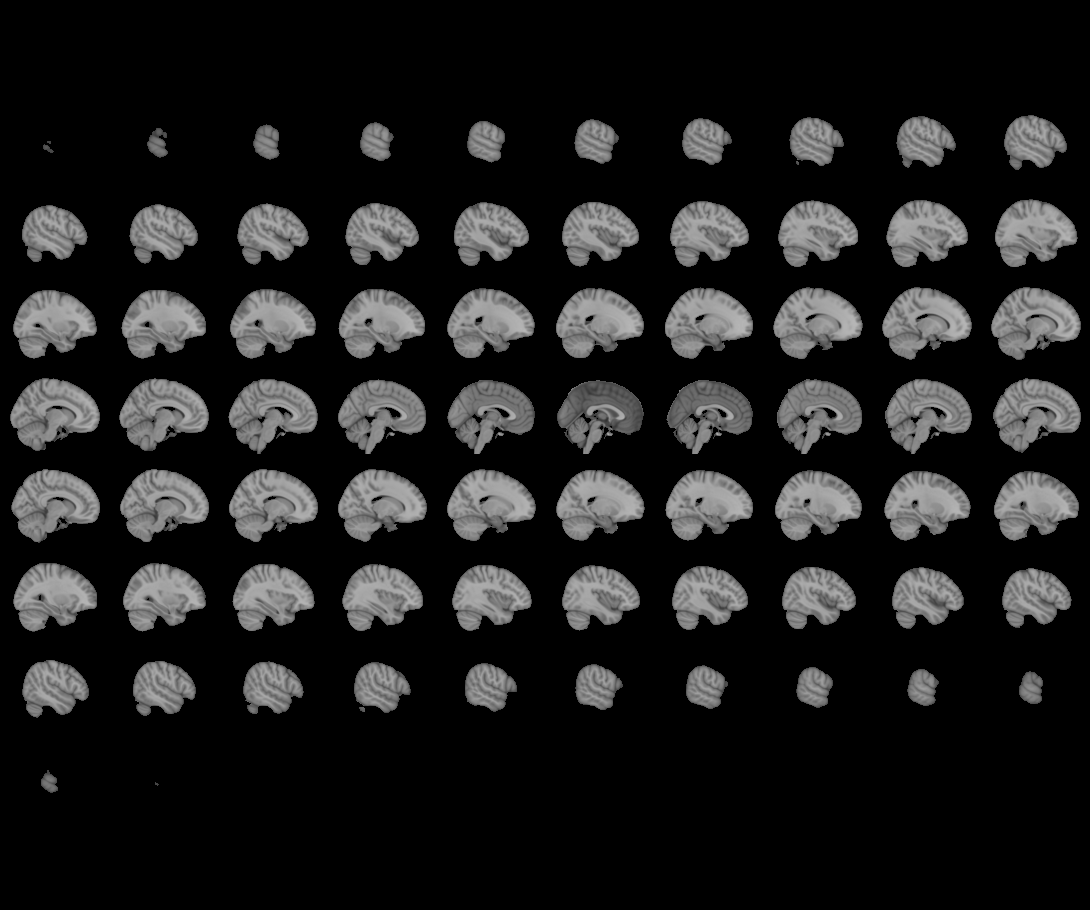
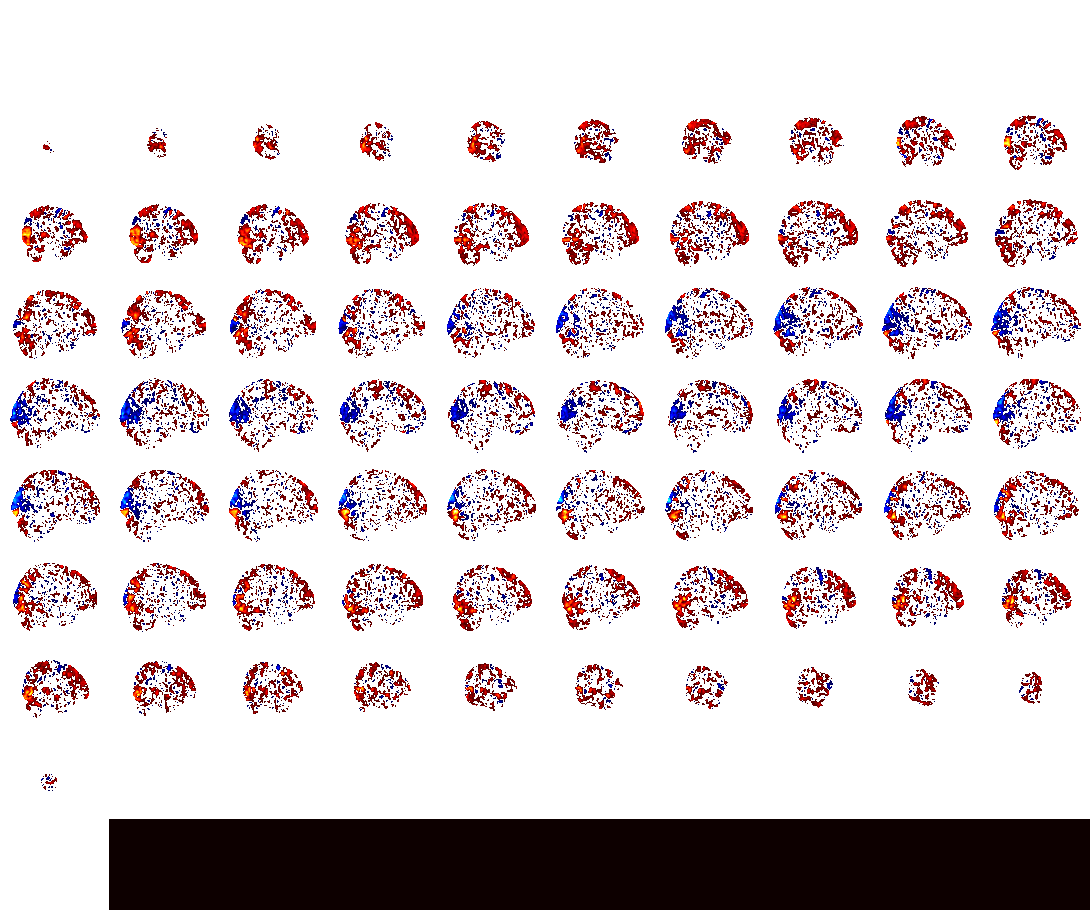

In [111]:
poly_fmri = masking.unmask(polynomial_fmri, background_mask)
plotting.view_img(image.index_img(poly_fmri, 1), threshold=10)

In [121]:
polyreg.get_params()

{'memory': None,
 'steps': [('polynomialfeatures', PolynomialFeatures(degree=9)),
  ('lasso', Lasso())],
 'verbose': False,
 'polynomialfeatures': PolynomialFeatures(degree=9),
 'lasso': Lasso(),
 'polynomialfeatures__degree': 9,
 'polynomialfeatures__include_bias': True,
 'polynomialfeatures__interaction_only': False,
 'polynomialfeatures__order': 'C',
 'lasso__alpha': 1.0,
 'lasso__copy_X': True,
 'lasso__fit_intercept': True,
 'lasso__max_iter': 1000,
 'lasso__normalize': False,
 'lasso__positive': False,
 'lasso__precompute': False,
 'lasso__random_state': None,
 'lasso__selection': 'cyclic',
 'lasso__tol': 0.0001,
 'lasso__warm_start': False}

In [76]:
t_fmri_wpms = t[:5]
print(t_fmri_wpms.shape)

(5, 229007)


In [85]:
polynomial_fmri = []
for i in tqdm(range(t_fmri_wpms.shape[1]), leave=False):
    polynomial_fmri.append(np.polyfit(words_per_min, t_fmri_wpms[:, i], 2))
polynomial_fmri = np.array(polynomial_fmri)
polynomial_fmri = polynomial_fmri.T
print(polynomial_fmri.shape)

(3, 229007)
